# Blood Pressure from PPG signal

In this notebook, you should solve the problem in Task 4 (blood pressure estimation from PPG signal) in the first assignment (<a href="http://kovan.ceng.metu.edu.tr/~sinan/DL/HW1.html">HW1</a>) using a CNN architecture that you should construct using the layers and the network you developed in this HW.

The notebook is intentionally composed of only this cell. You can copy-paste any text, data, cell, or code that you developed in this HW or HW1. You can add as many cells as you want. You can create files on the disk as freely as you like.

In [4]:
import random 
import numpy as np
from metu.data_utils import load_dataset
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from wavelets import WaveletAnalysis
import h5py
import scipy.signal as signal
from cs231n.classifiers.convnet import *
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%reload_ext autoreload
%autoreload 2


def rel_error(x, y):
    return np.max(np.abs(x-y)/(np.maximum(1e-8, np.abs(x)+np.abs(y))))

In [2]:

def get_data2D(datafile, input_size, min_dist, training_ratio=0.85, test_ratio=0.1, val_ratio=0.05):
    X, y = load_dataset(datafile, input_size, min_dist)
    X = spectrogramm(X)
    print("spectrogramm",X.shape)
    #dt = 30
    #wa = WaveletAnalysis(X, dt)
    #power = wa.wavelet_power
    #scales = wa.scales
    #t = wa.time
    
    #fig, ax = plt.subplots()
    #T, S = np.meshgrid(t, scales)
    #ax.contourf(T, S, power, 100)
    #fig.savefig('fig.png')
    #im = imread('fig.png')
    #print("img", im.shape)
    length=X.shape[0]
    num_training = int(length*training_ratio)
    num_val = int(length*val_ratio)
    num_test = min((length-num_training-num_val), int(length*test_ratio))
    mask = range(num_training-1)
    X_train = X[mask, :, :, :]
    X_train = np.transpose(X_train, (0, 3, 1, 2))
    y_train = y[mask]
    mask = range(num_training, num_training+num_test)
    X_test = np.transpose(X[mask, :, :, :], (0, 3, 1, 2))
    y_test = y[mask]
    mask = range(num_training+num_test, num_training+num_test+num_val)
    X_val = X[mask, :, :, :]
    X_val = np.transpose(X_val, (0, 3, 1, 2))
    y_val = y[mask]
  
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
def get_data(datafile, input_size, min_dist, training_ratio=0.85, test_ratio=0.1, val_ratio=0.05):
  # Load the PPG training data 
  X, y = load_dataset(datafile, input_size, min_dist)
    
  # TODO: Split the data into training, validation and test sets
  length=y.shape[0]
  print(length)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]
  
  return X_train, y_train, X_val, y_val, X_test, y_test

In [74]:
from sklearn.model_selection import train_test_split
def  get_data(datafile, input_size, min_dist, training_ratio=0.85, test_ratio=0.1, val_ratio=0.05):
    X, y = load_dataset(datafile, input_size, min_dist)
    print(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [67]:
from wavelets import WaveletAnalysis
import matplotlib.pyplot as plt

def spectrogramm(X):
    T = 1.0 / 800.0
    dataset = []
    for x in X:
        up = np.percentile(x, 95)
        down =np.percentile(x, 5)
        x[x>up] = up
        x[x<down] = down
        N = x.shape[0]
        x/=x.max()
        # and a sample spacing

        dt = 125

        wa = WaveletAnalysis(x, dt=dt)
        # wavelet power spectrum
        power = wa.wavelet_power

        # scales 
        scales = wa.scales

        # associated time vector
        t = wa.time

        # reconstruction of the original data
        rx = wa.reconstruction()
        fig, ax = plt.subplots()
        T, S = np.meshgrid(t, scales)
        ax.contourf(T, S, power, 10)
        ax.set_yscale('log')
        fig.savefig('/Users/alisa/Desktop/HW2/test_wavelet_power_spectrum.png')
        im = cv2.imread('/Users/alisa/Desktop/HW2/test_wavelet_power_spectrum.png')
        dataset.append(im)
    X = np.array(dataset)
    print(X.shape)
    return X

In [7]:
def get_data_disk():
    files = ['/Users/alisa/Desktop/HW2/xtrain.txt', '/Users/alisa/Desktop/HW2/xval.txt', '/Users/alisa/Desktop/HW2/xtest.txt']
    shape = np.loadtxt('/Users/alisa/Desktop/HW2/shape.txt')
    X_train = load_f(files[0], shape[0])
    print(same(data[0], X_train))
    X_val = load_f(files[1], shape[1])
    X_test = load_f(files[2], shape[2])

    y_train = np.loadtxt(y_files[0])
    y_val = np.loadtxt(y_files[1])
    y_test = np.loadtxt(y_files[2])
    return X_train, y_train, X_val, y_val, X_test, y_test

def save_f(data, file_name):
    data = data.astype(float)
    with open(file_name, 'w') as file:
        file.write('# Array shape: {0}\n'.format(data.shape))
        for data_slice in data:
            np.savetxt(file, data_slice, fmt='%-8.10f')
            f.write('#New slice\n')
def load_f(file_name, shape):
    new_data = np.loadtxt(file_name)
    new_data = new_data.reshape(shape)
    return new_data
def same(old, new):
    return np.all(old == new)

### Attempt to use wavelet histograms for windows

['#refs#', 'Part_1']


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(610, 288, 432, 3)
spectrogramm (610, 288, 432, 3)


TypeError: Mismatch between array dtype ('float64') and format specifier ('%-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f %-8.10f')

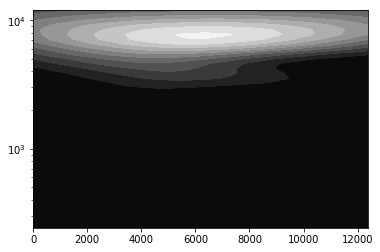

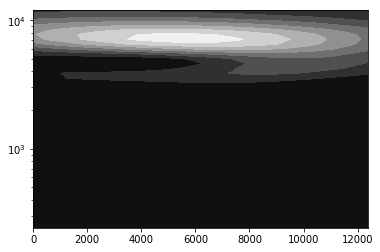

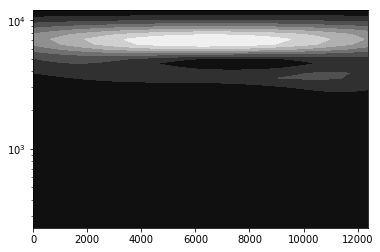

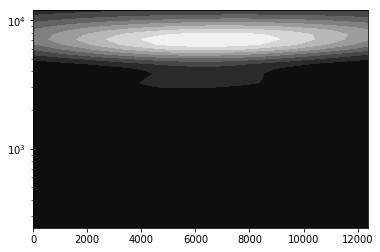

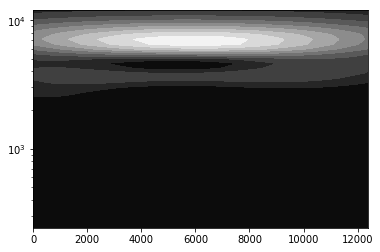

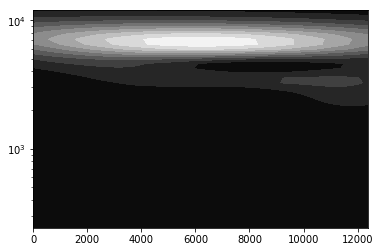

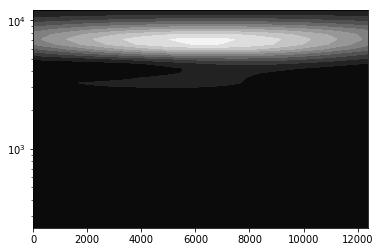

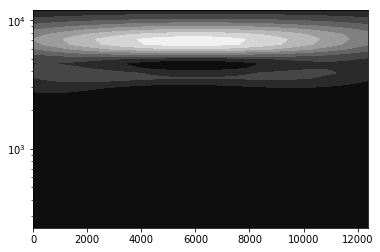

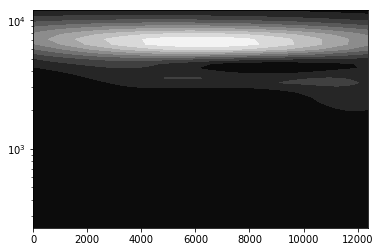

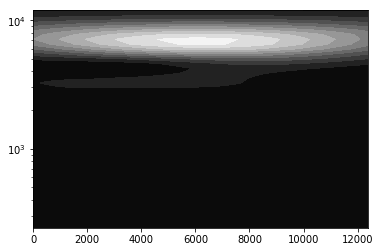

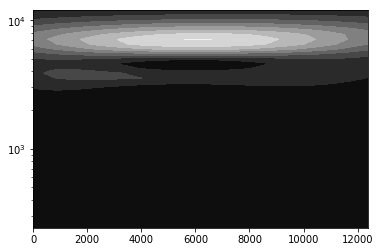

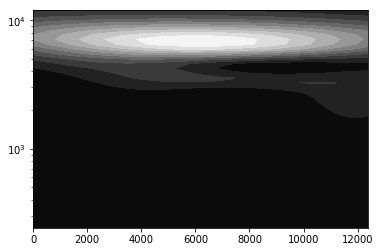

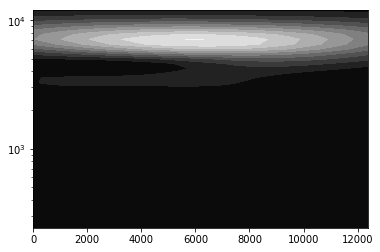

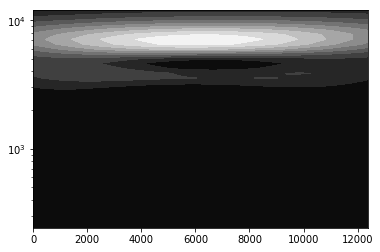

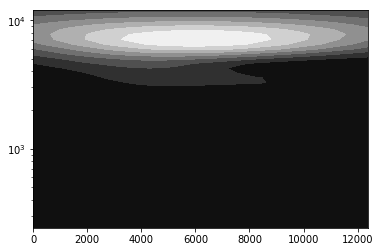

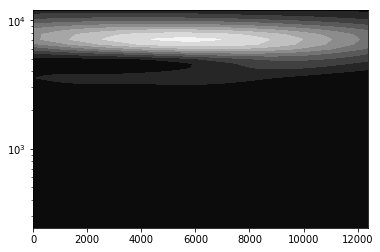

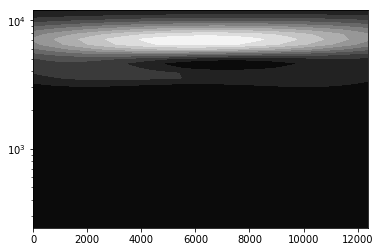

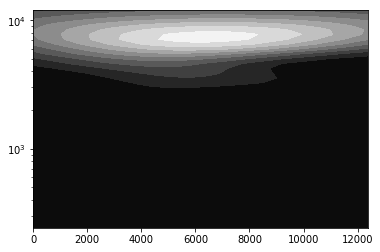

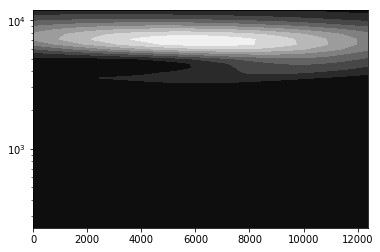

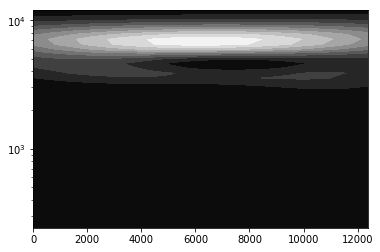

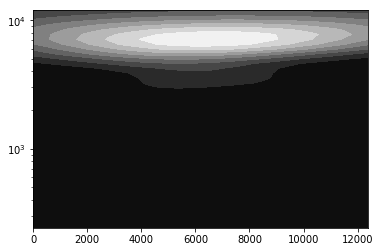

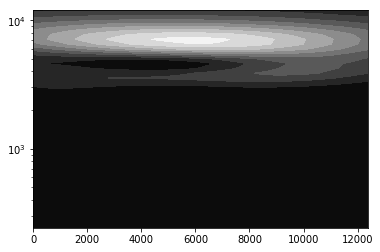

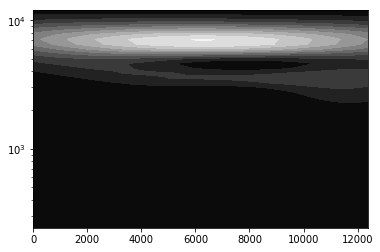

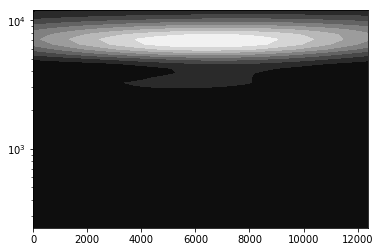

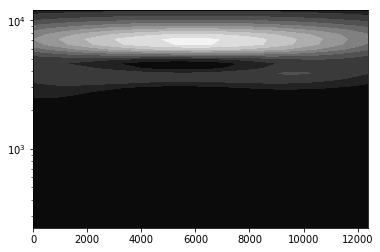

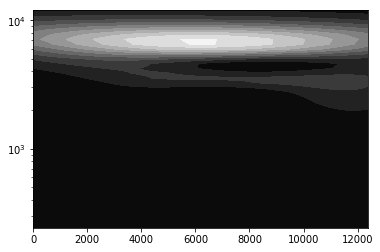

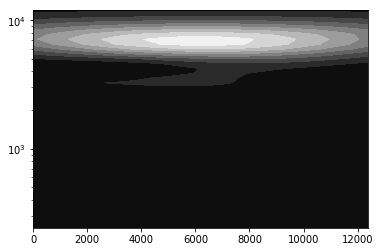

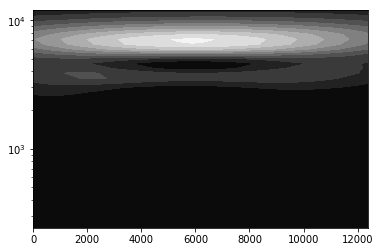

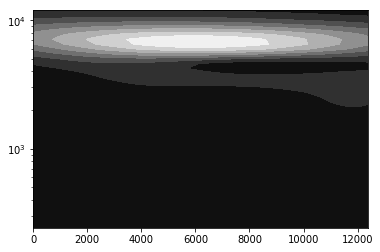

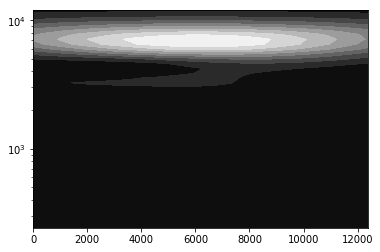

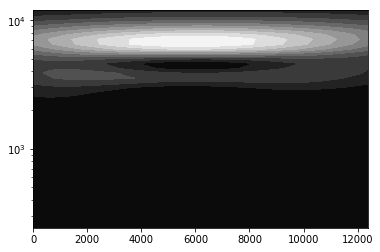

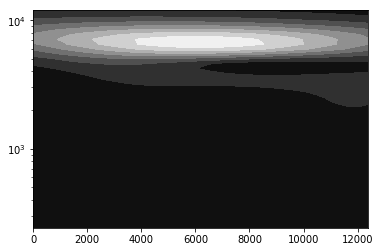

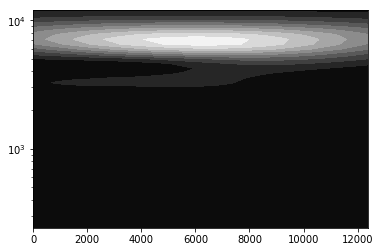

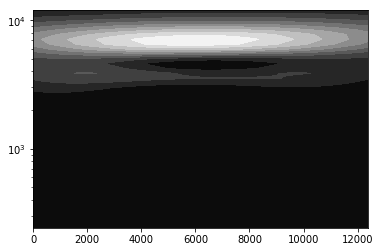

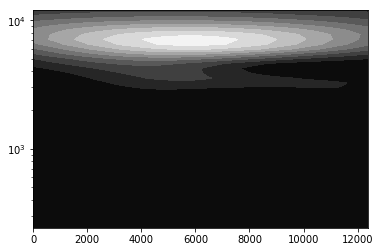

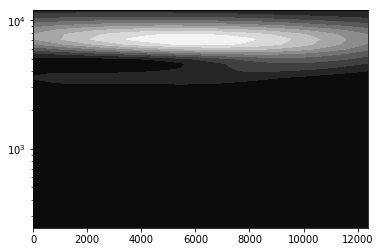

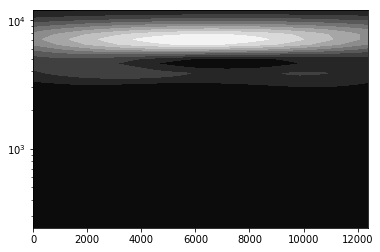

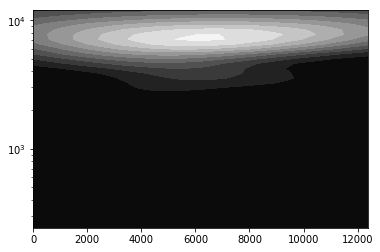

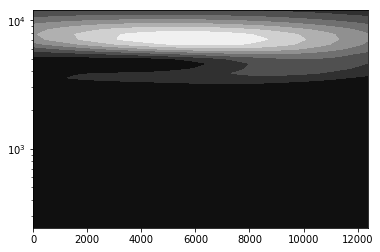

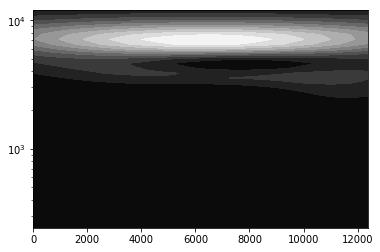

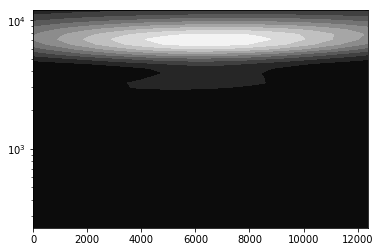

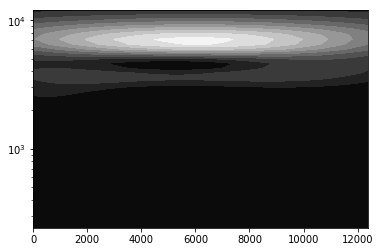

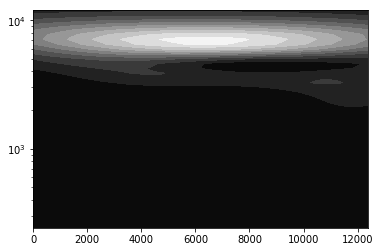

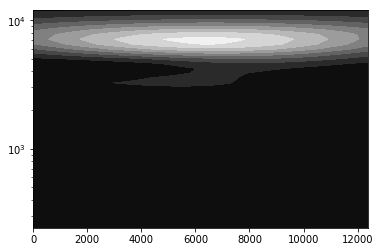

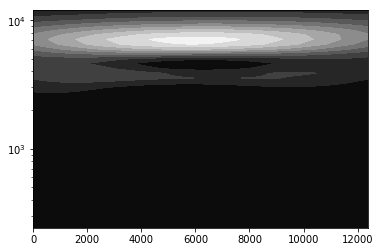

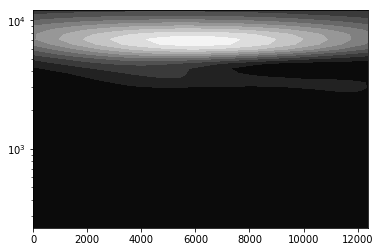

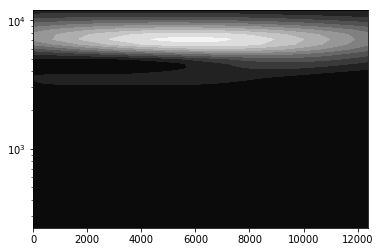

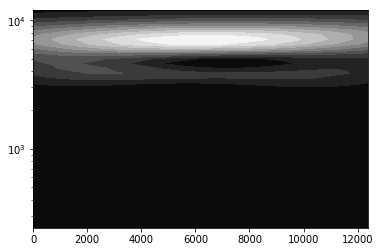

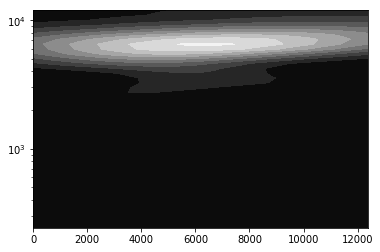

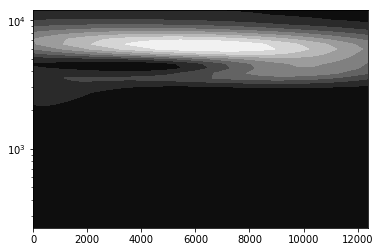

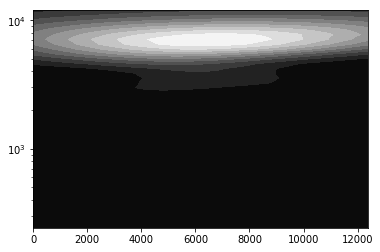

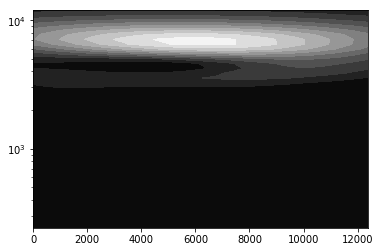

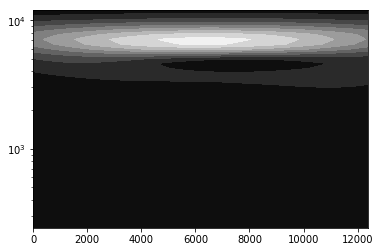

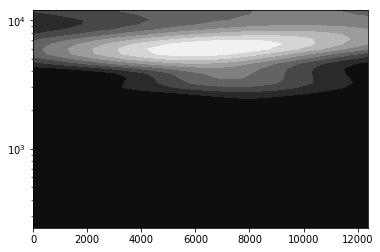

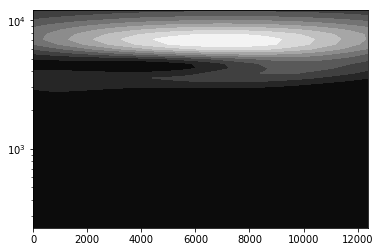

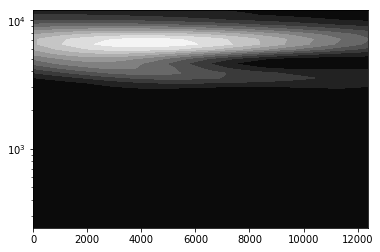

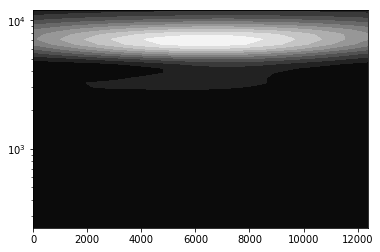

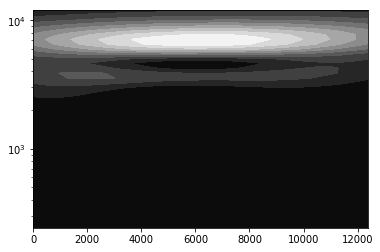

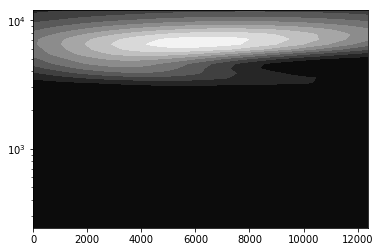

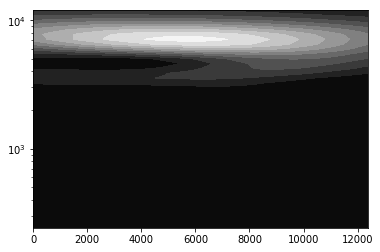

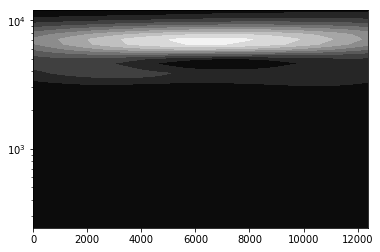

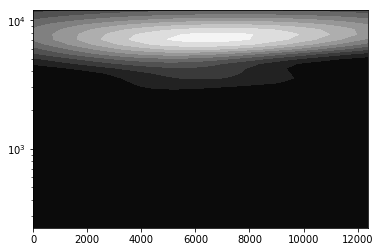

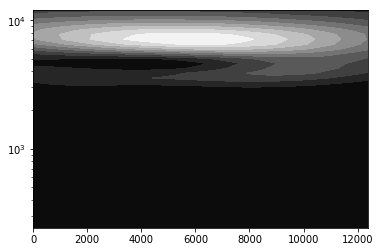

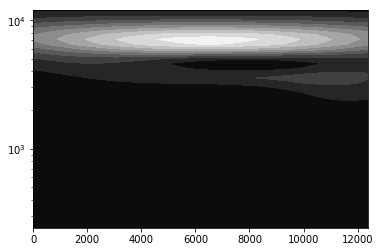

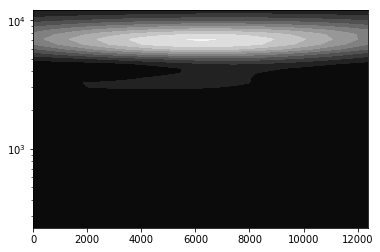

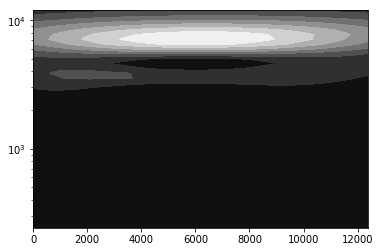

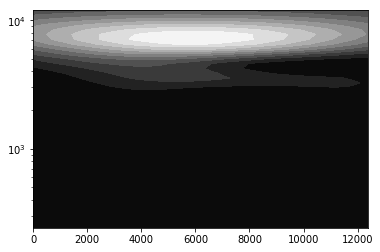

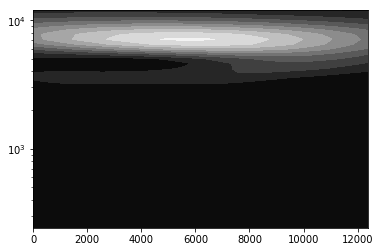

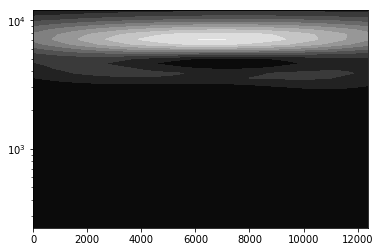

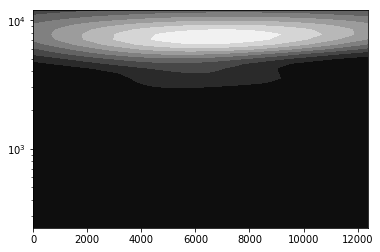

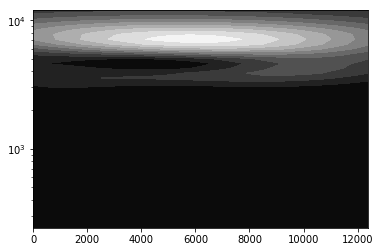

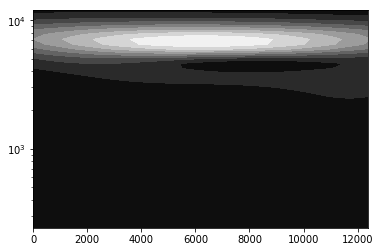

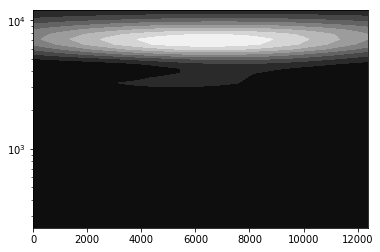

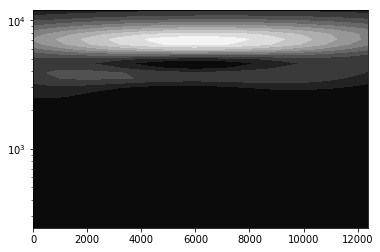

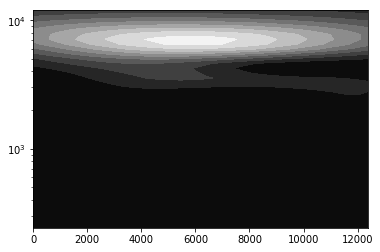

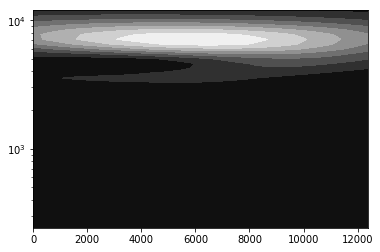

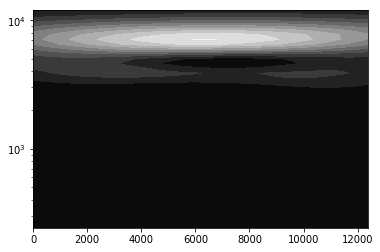

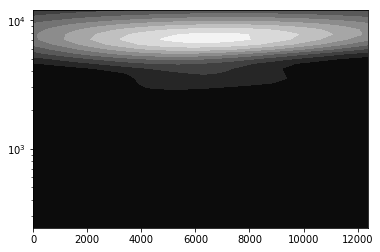

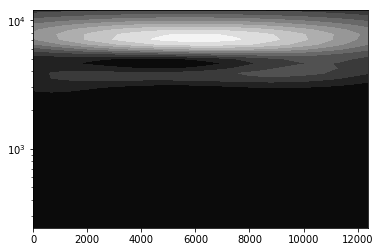

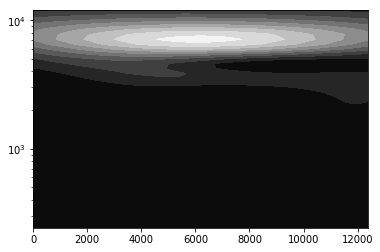

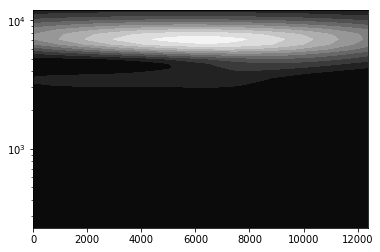

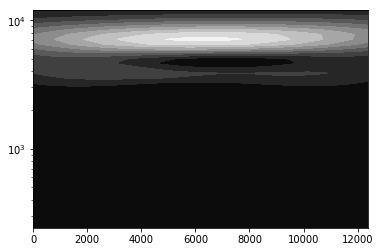

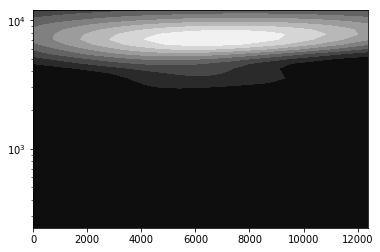

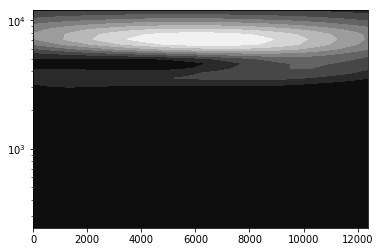

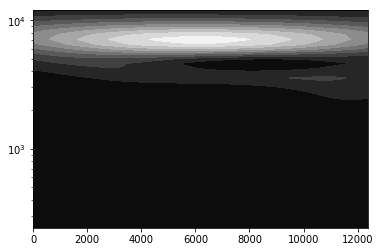

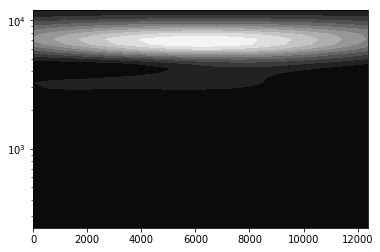

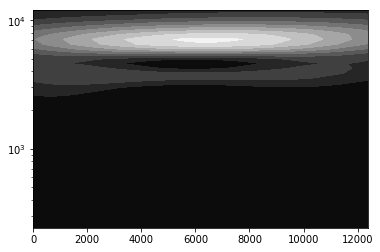

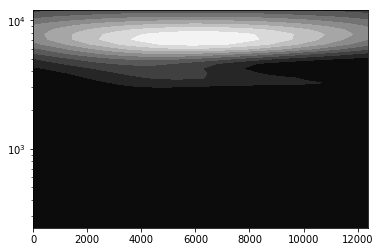

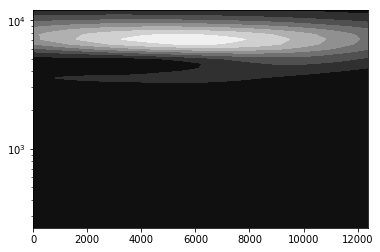

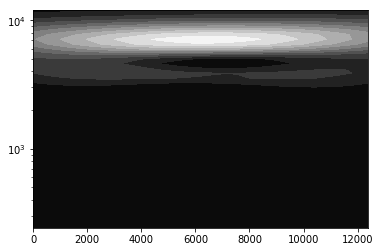

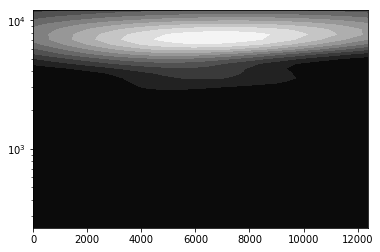

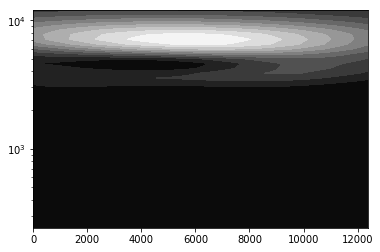

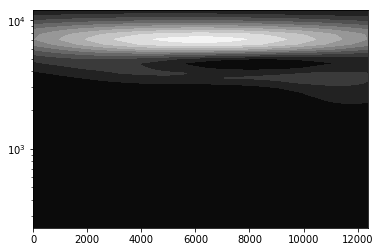

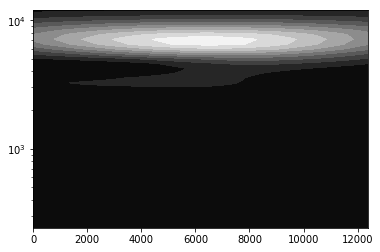

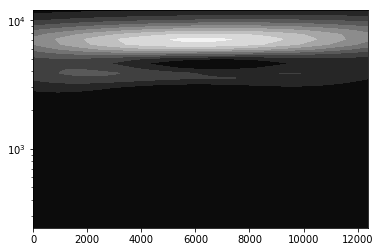

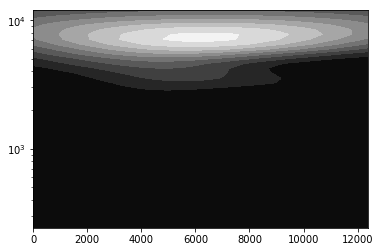

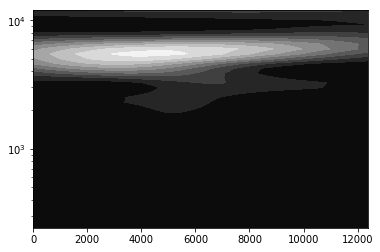

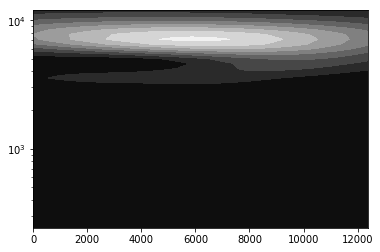

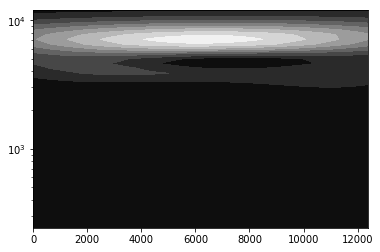

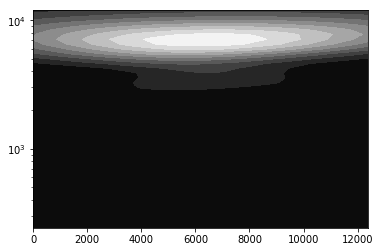

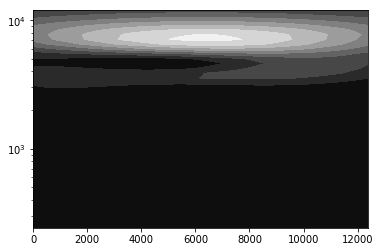

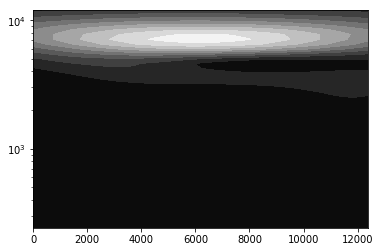

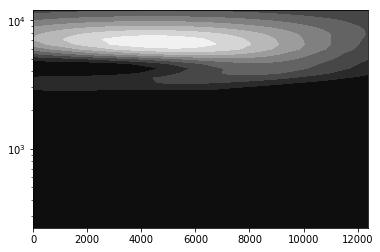

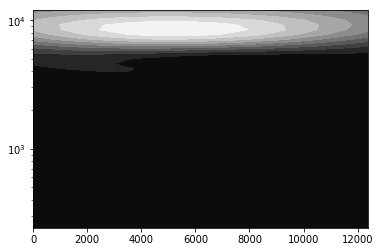

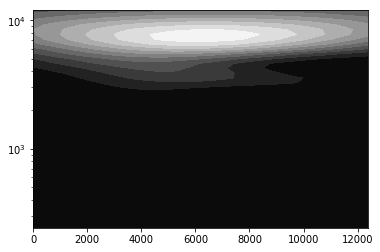

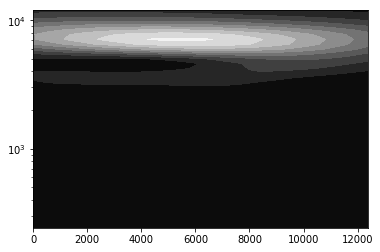

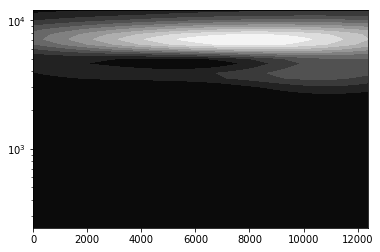

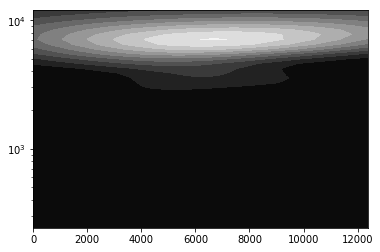

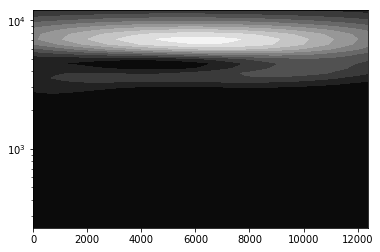

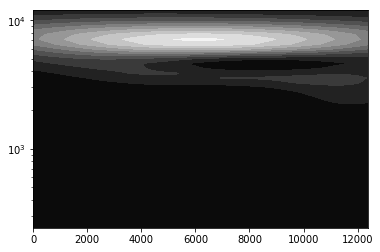

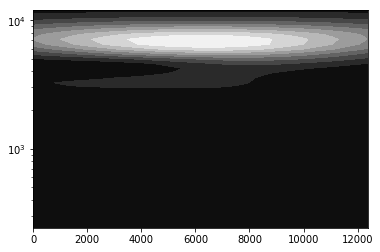

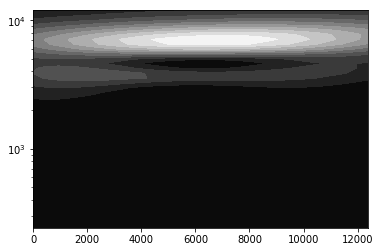

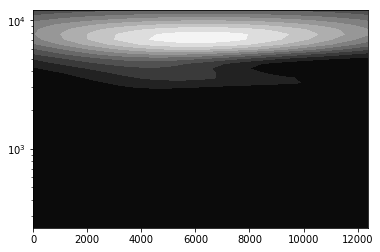

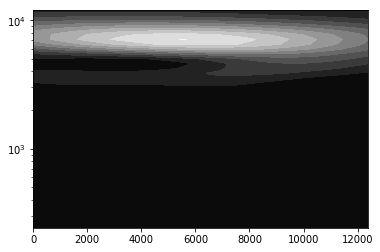

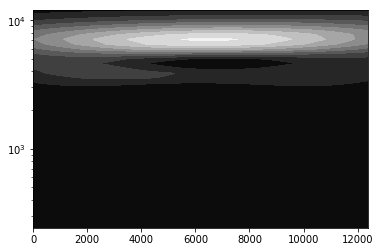

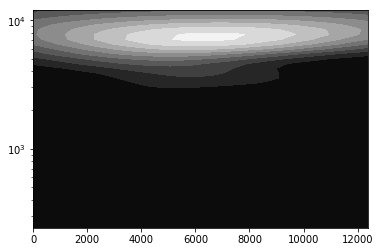

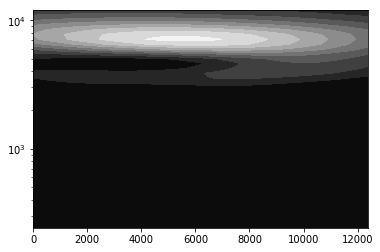

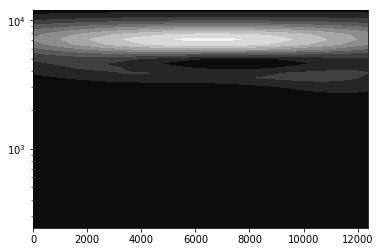

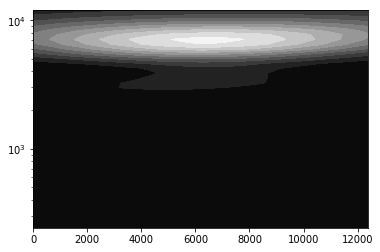

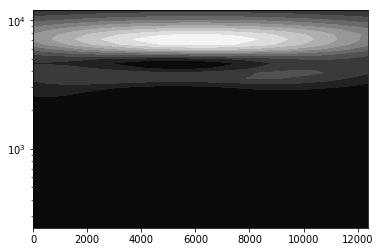

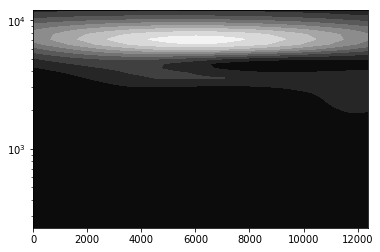

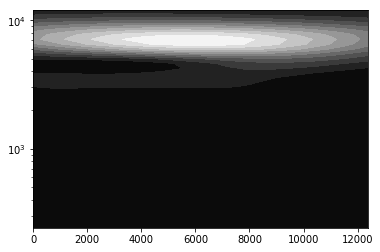

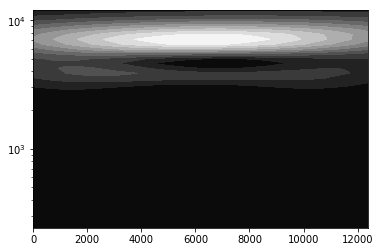

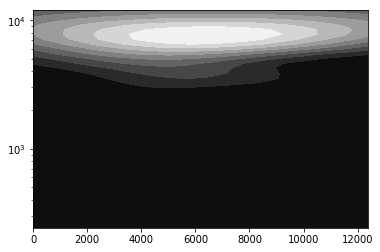

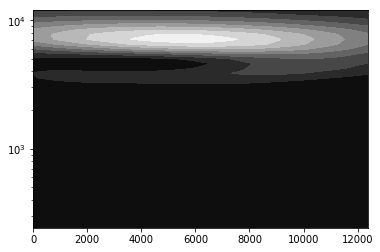

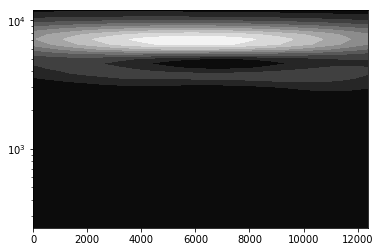

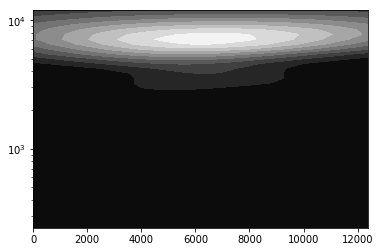

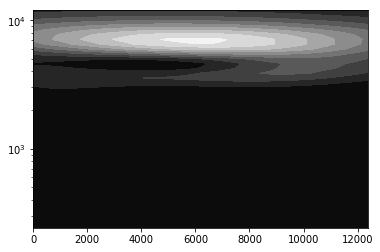

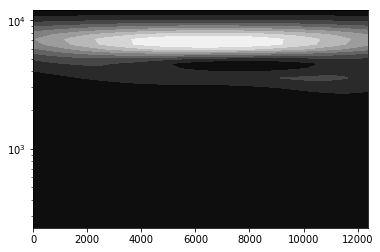

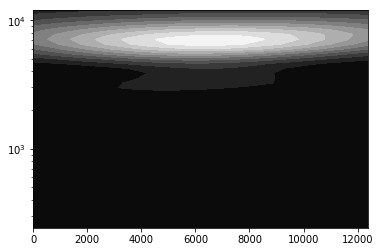

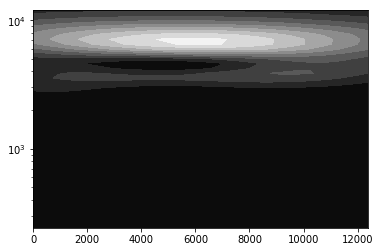

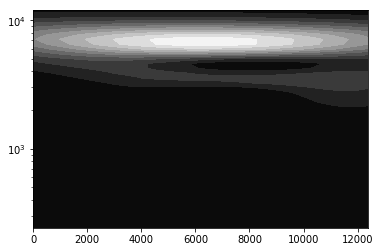

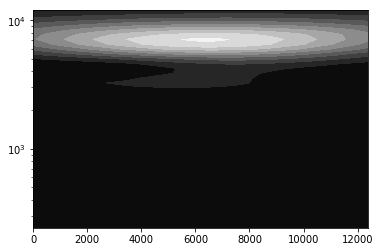

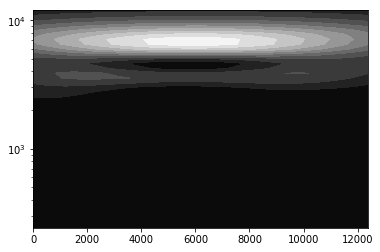

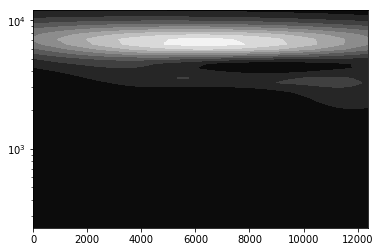

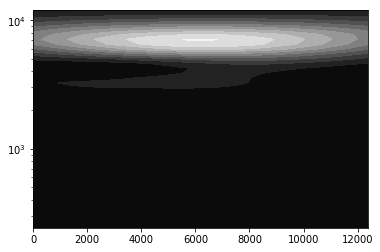

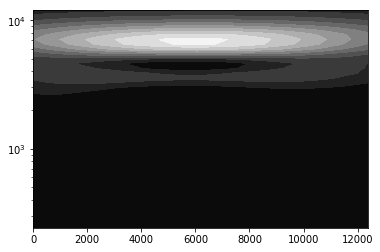

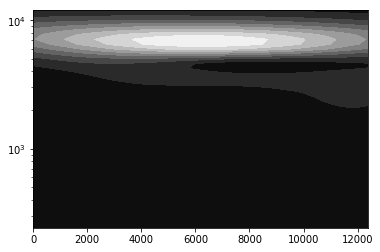

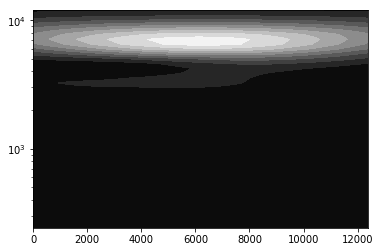

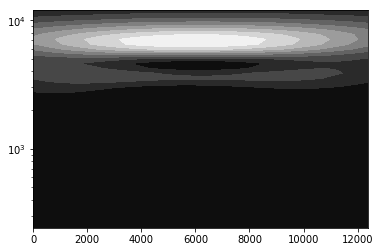

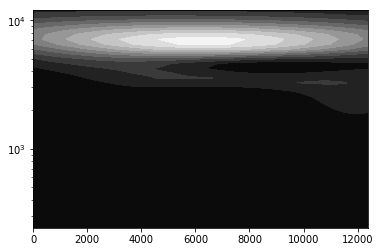

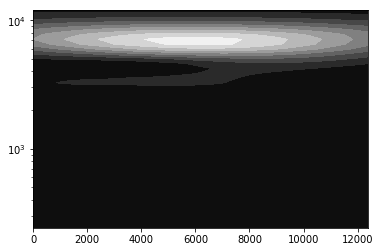

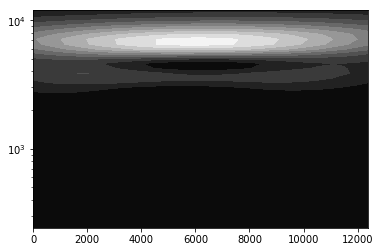

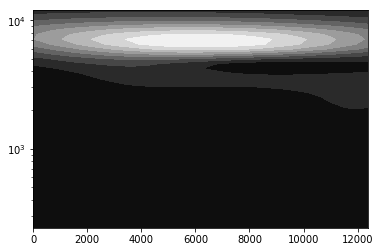

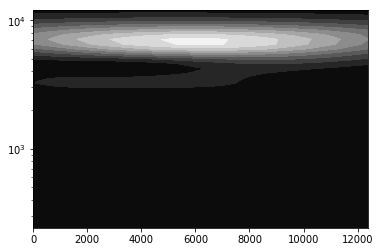

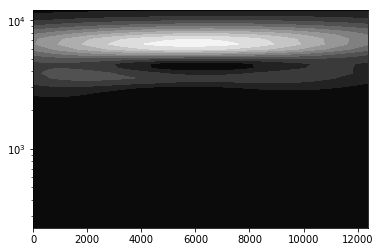

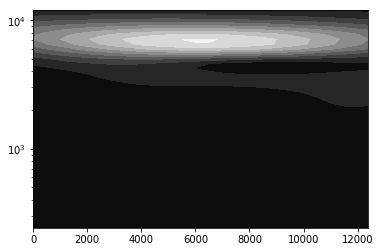

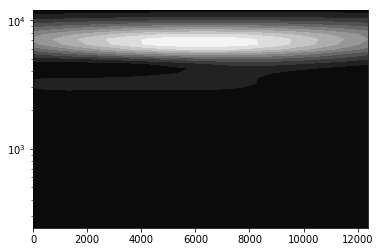

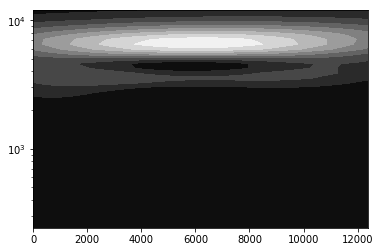

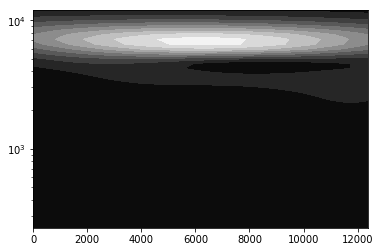

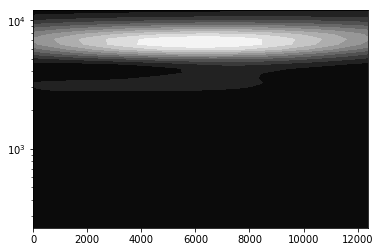

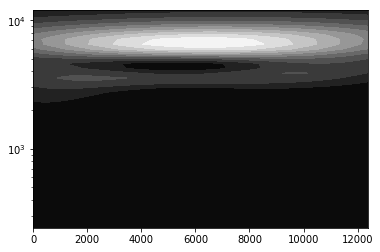

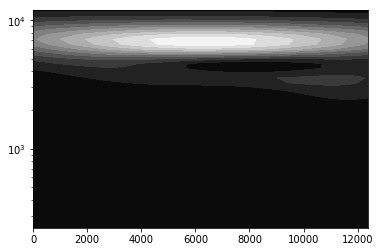

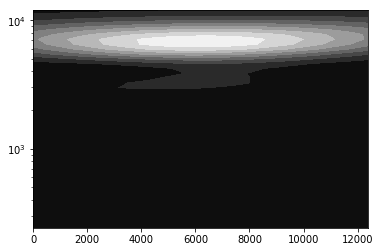

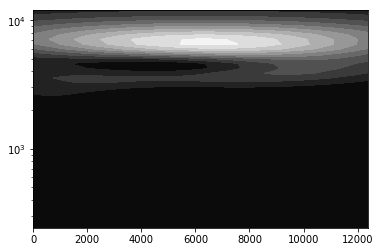

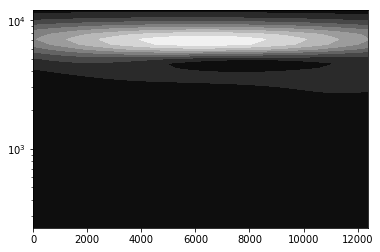

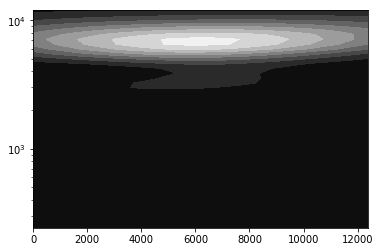

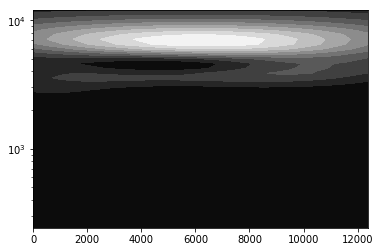

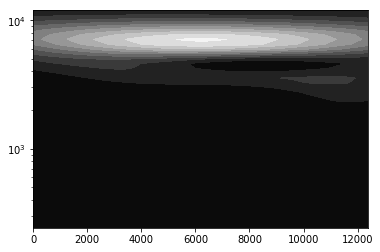

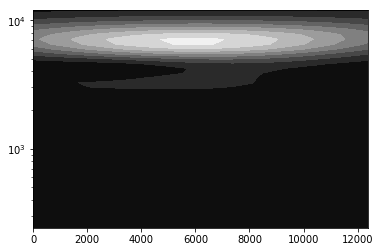

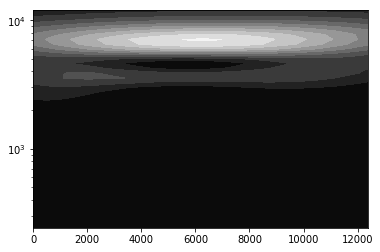

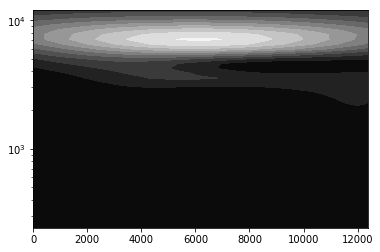

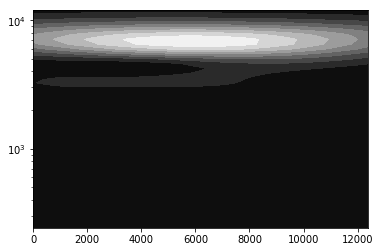

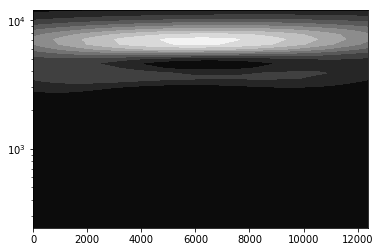

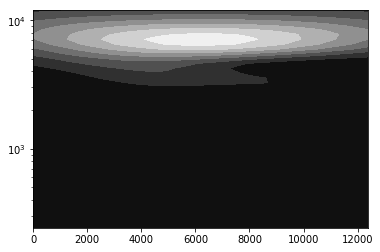

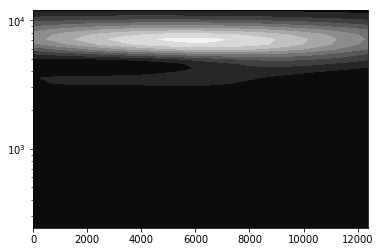

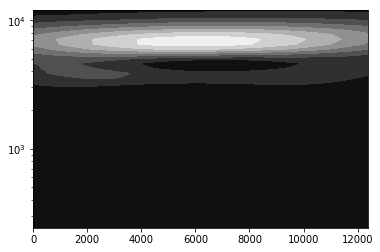

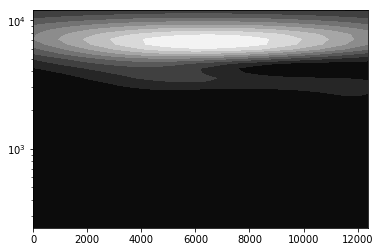

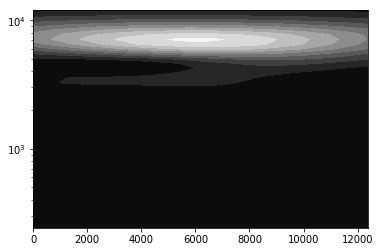

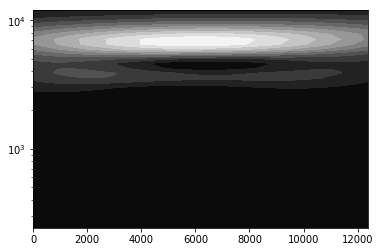

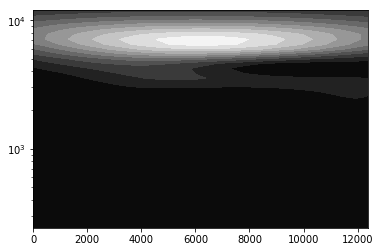

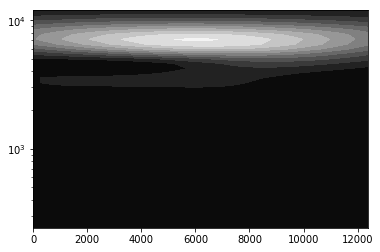

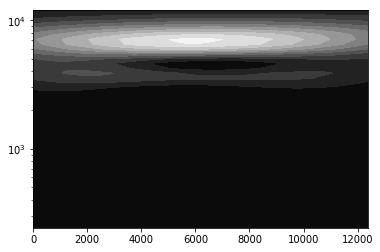

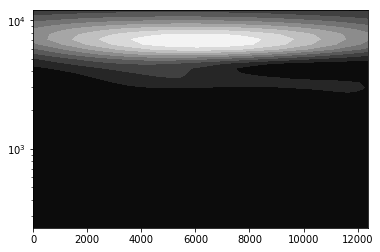

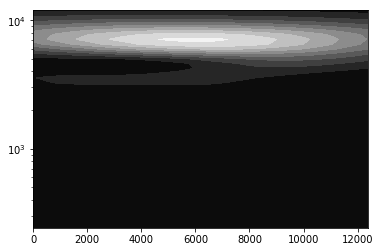

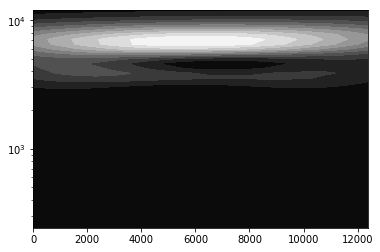

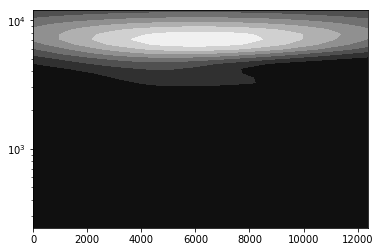

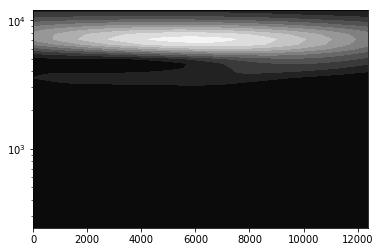

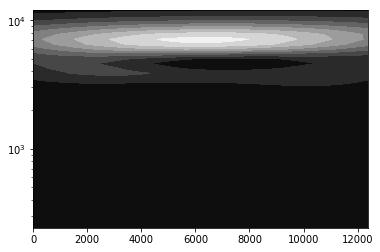

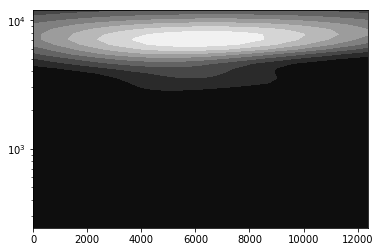

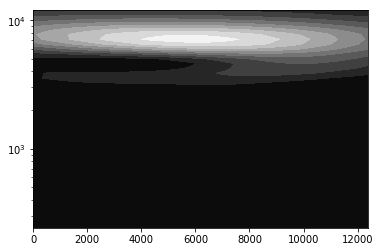

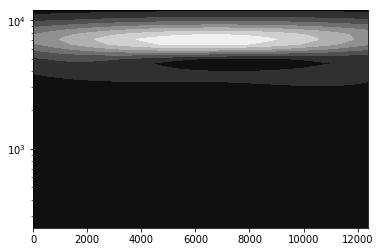

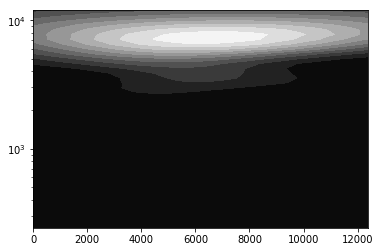

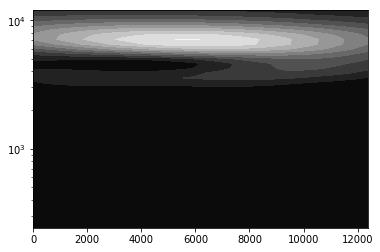

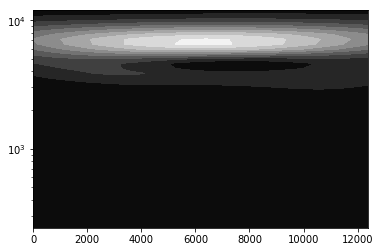

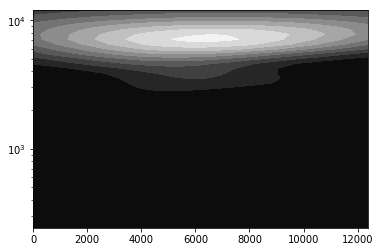

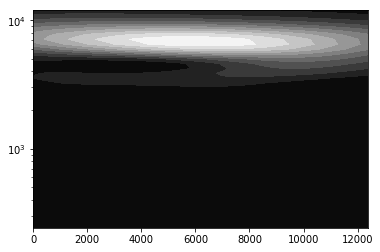

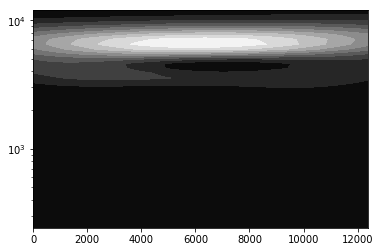

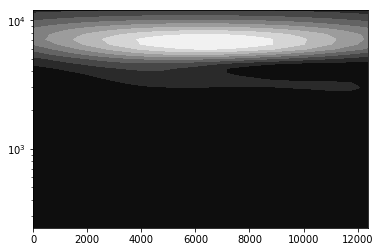

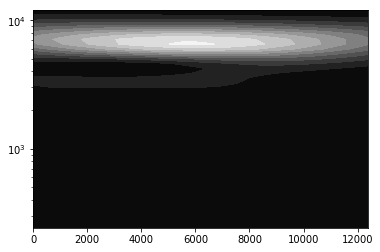

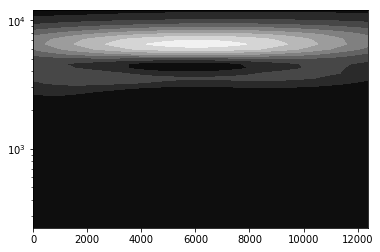

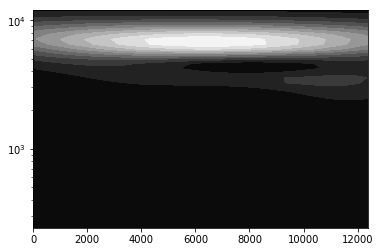

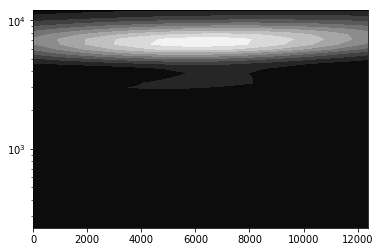

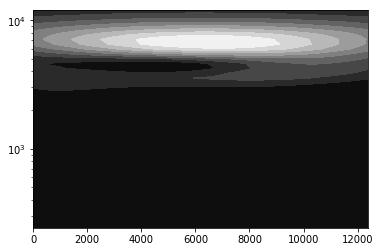

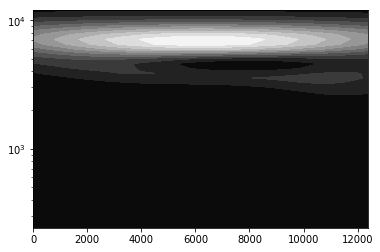

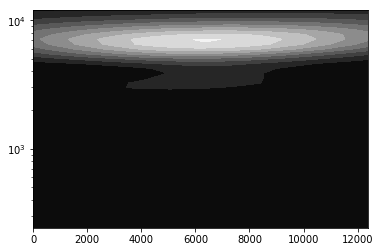

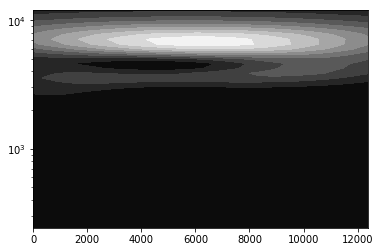

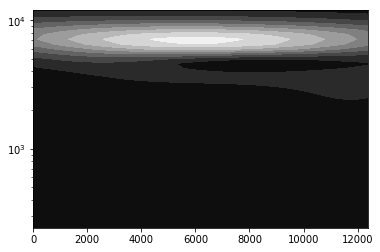

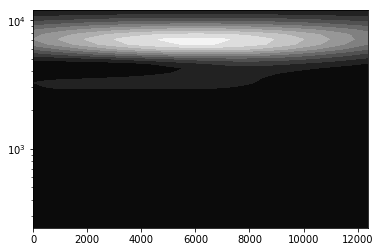

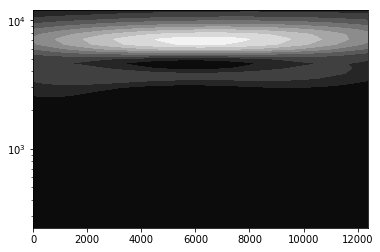

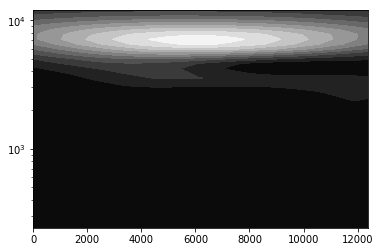

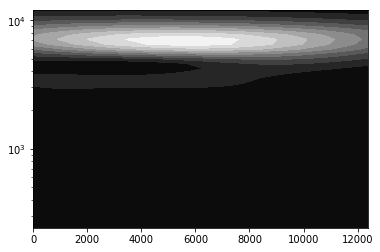

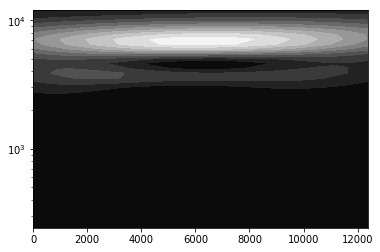

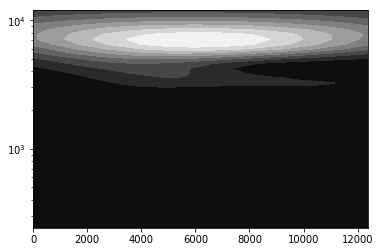

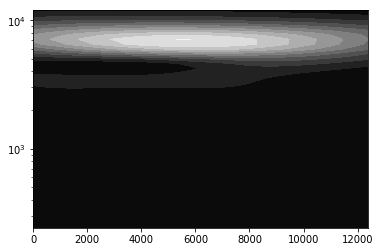

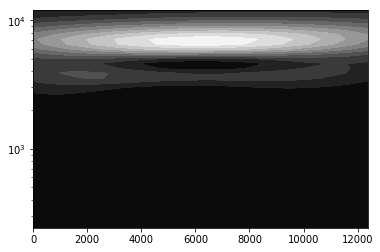

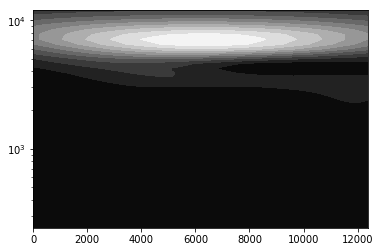

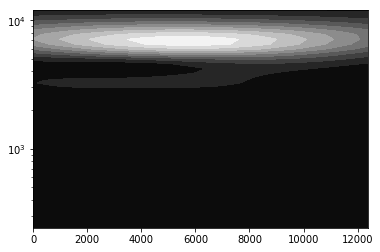

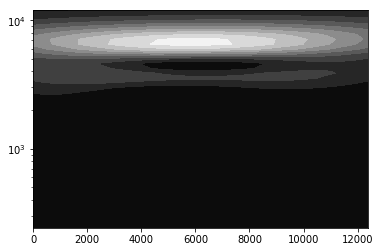

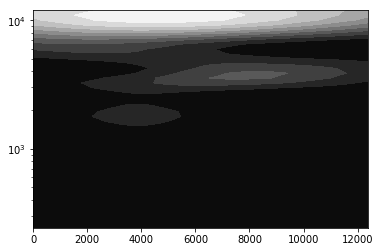

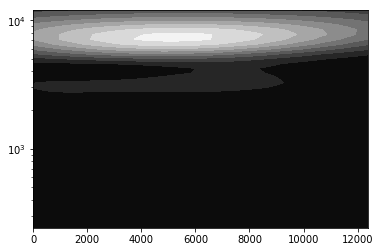

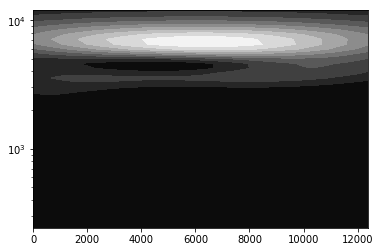

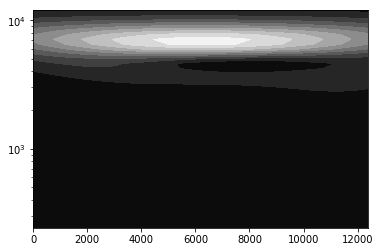

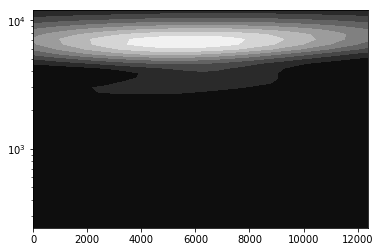

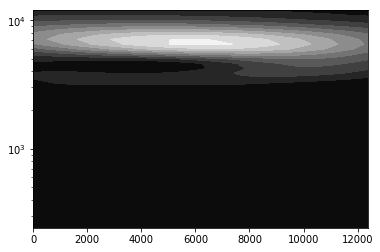

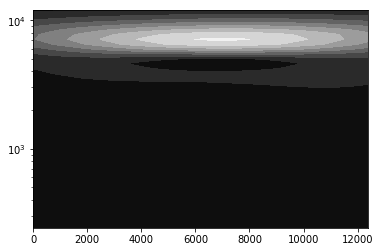

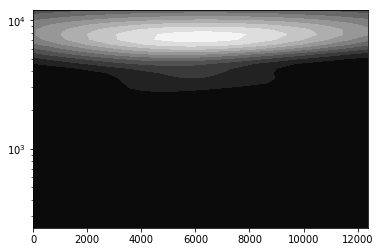

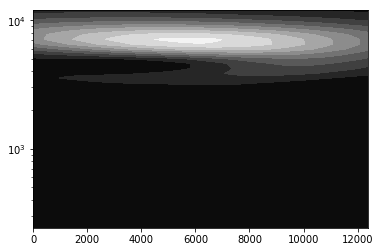

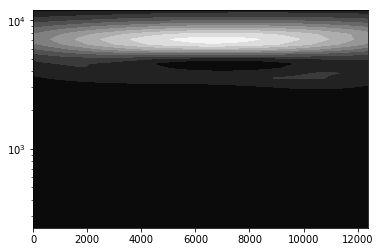

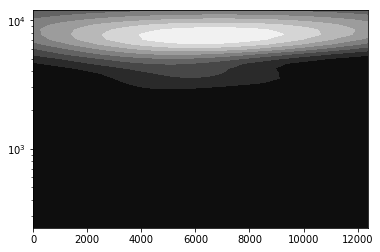

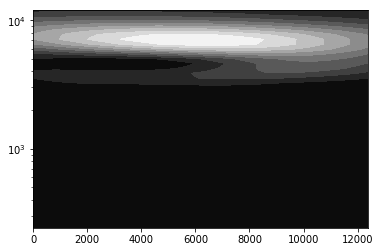

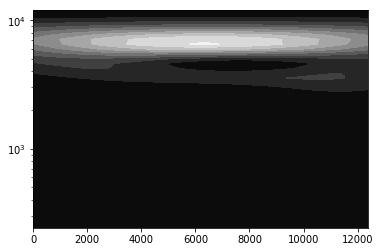

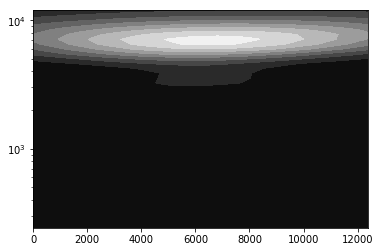

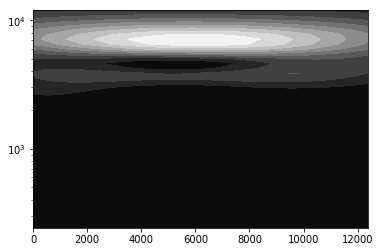

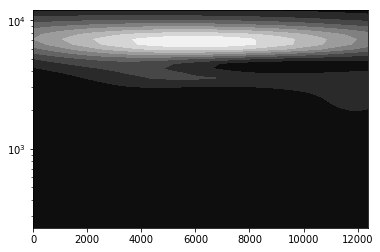

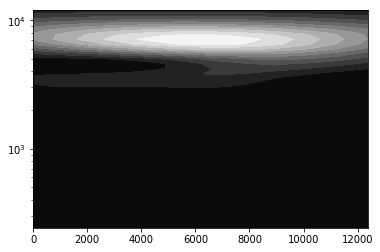

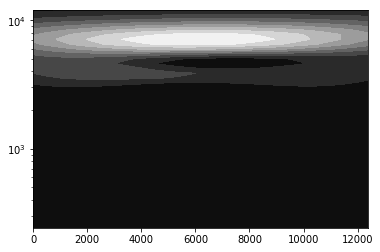

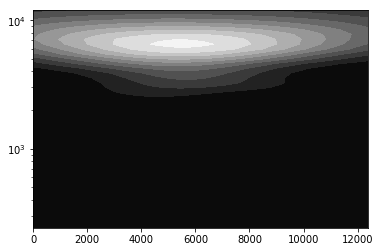

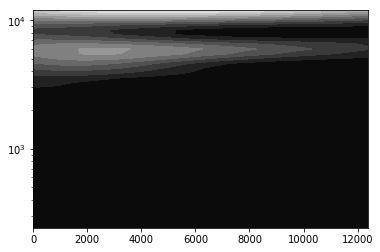

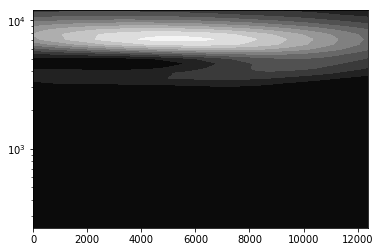

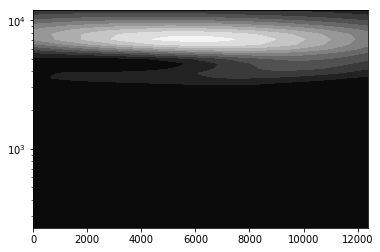

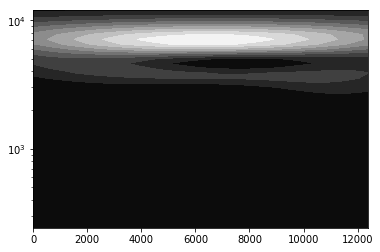

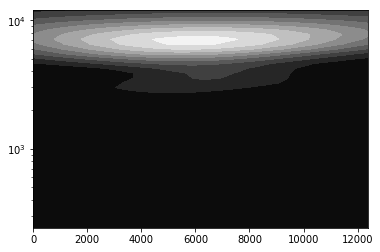

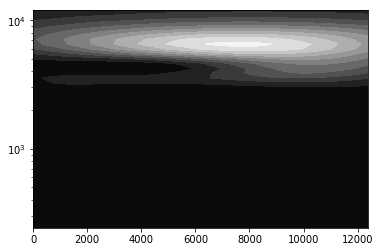

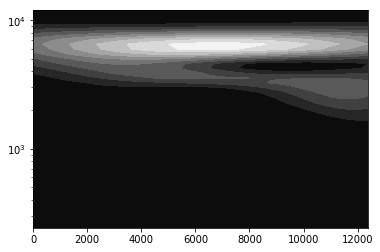

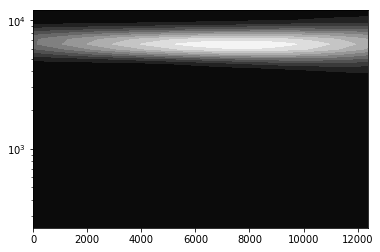

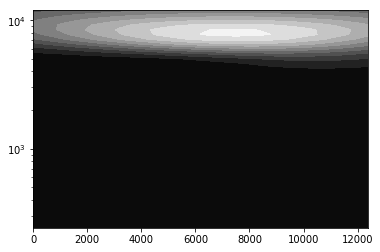

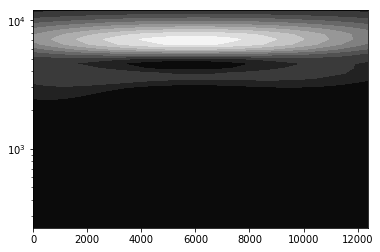

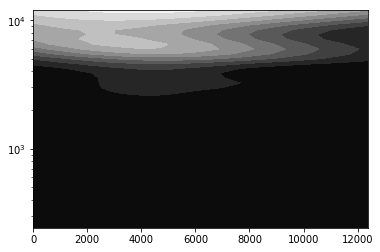

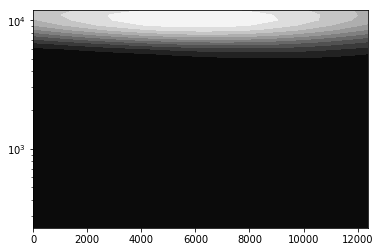

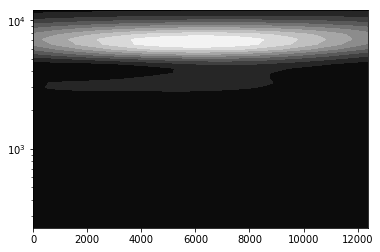

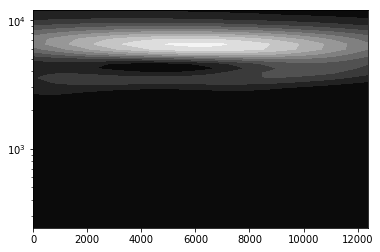

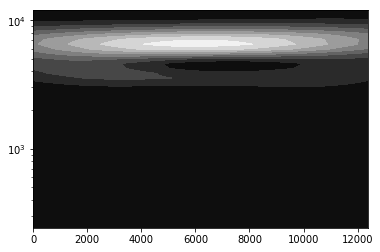

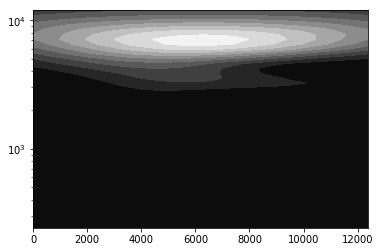

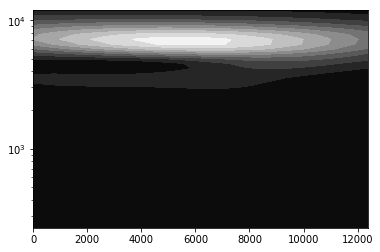

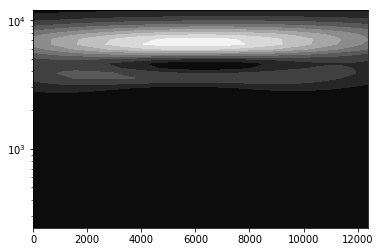

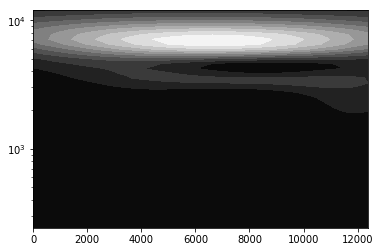

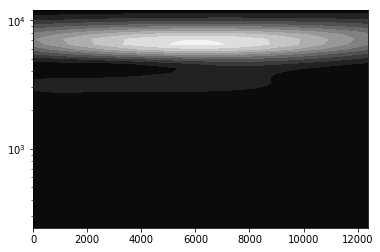

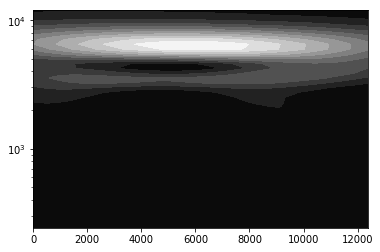

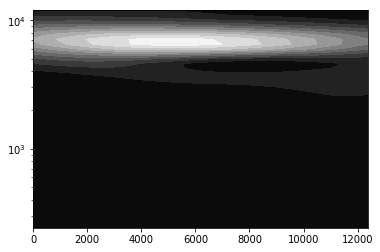

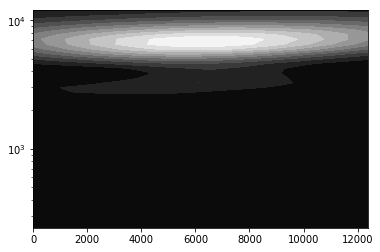

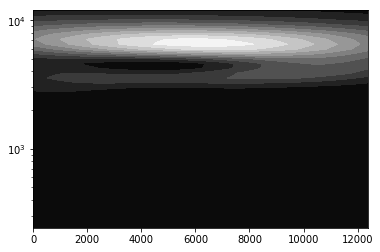

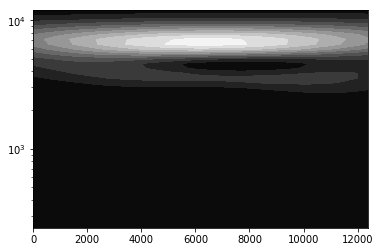

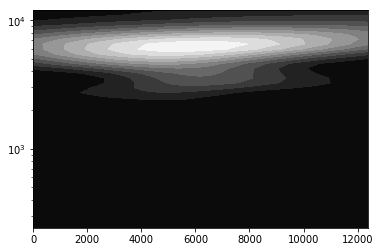

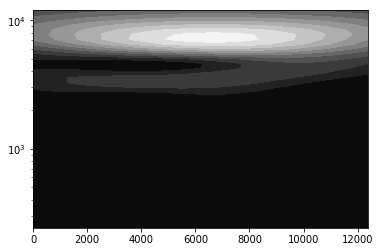

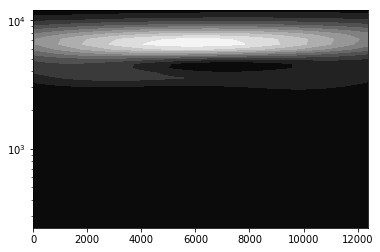

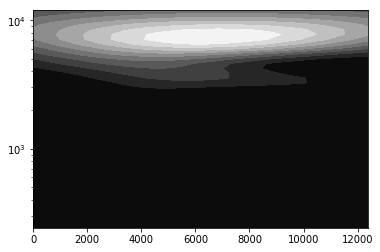

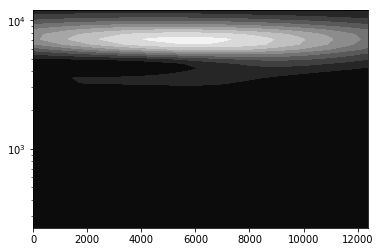

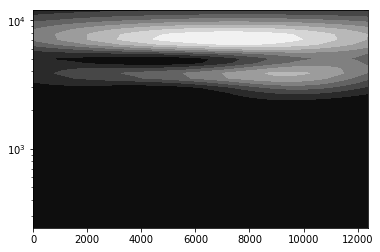

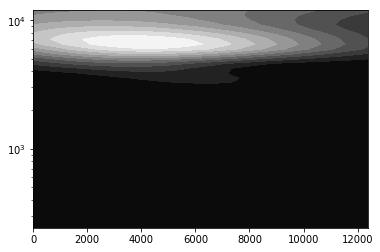

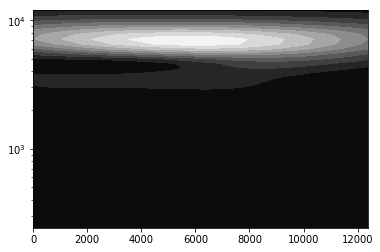

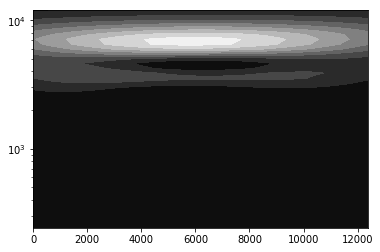

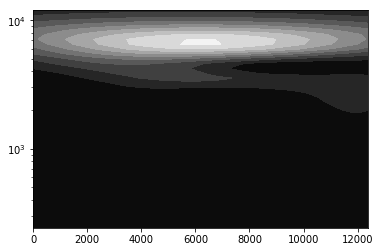

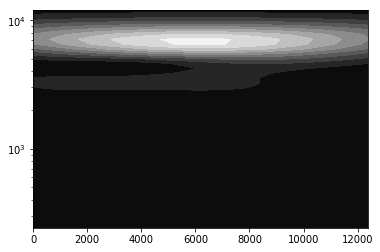

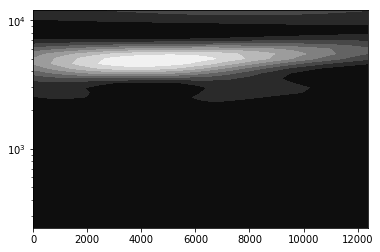

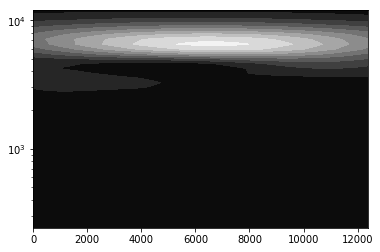

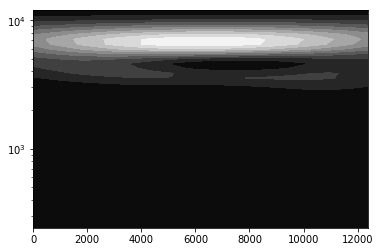

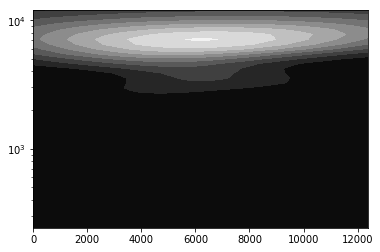

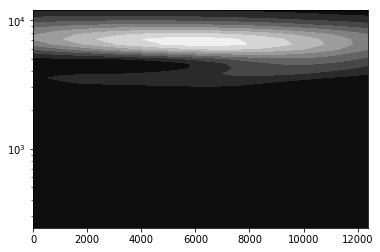

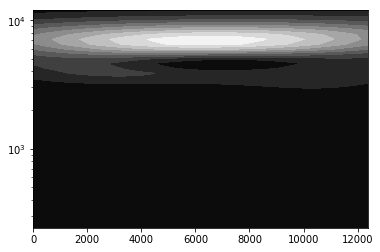

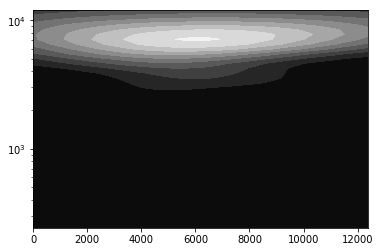

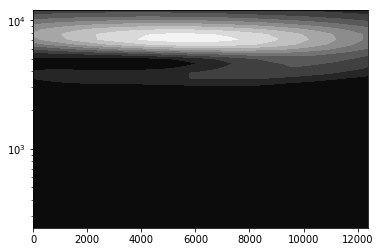

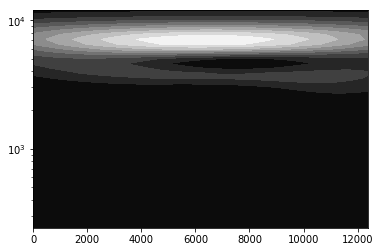

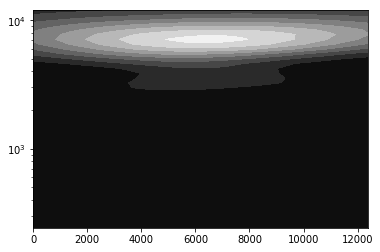

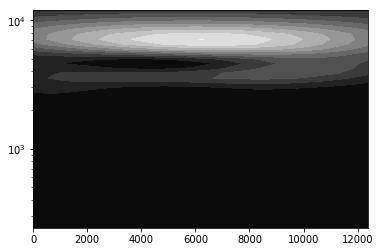

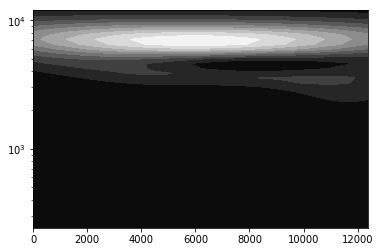

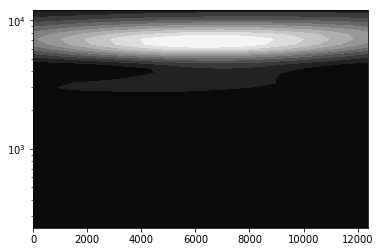

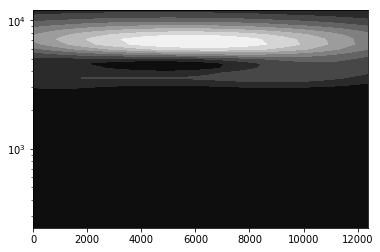

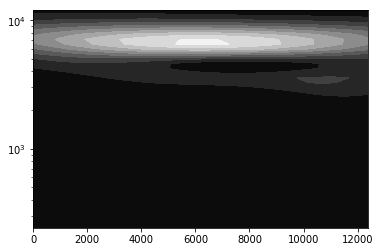

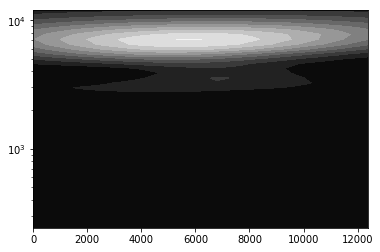

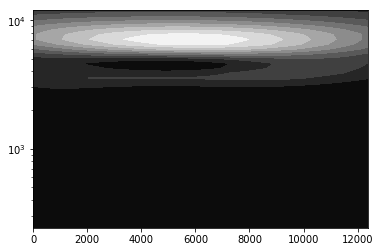

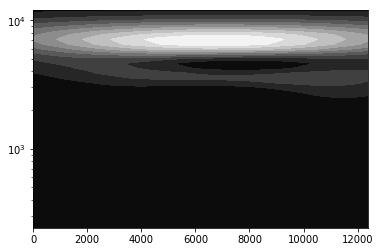

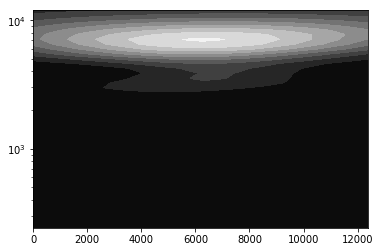

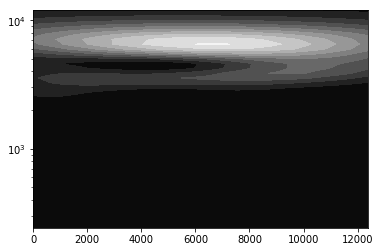

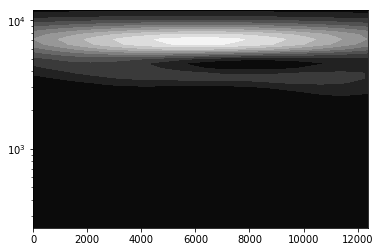

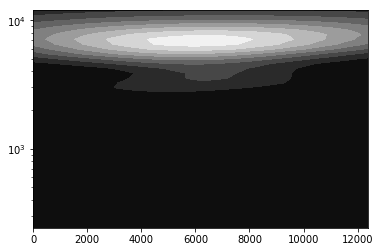

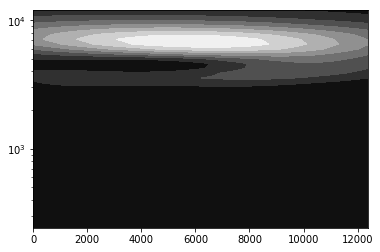

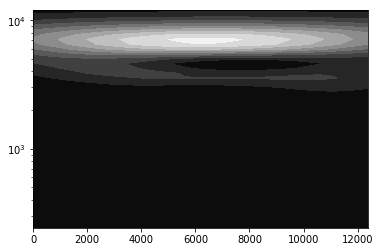

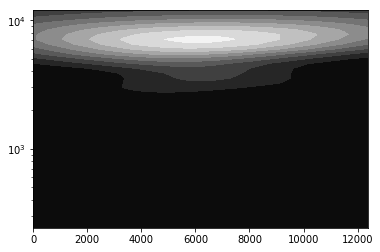

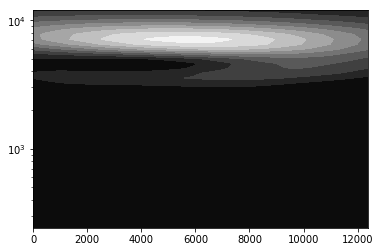

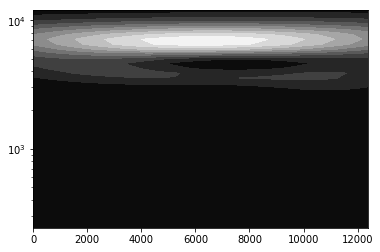

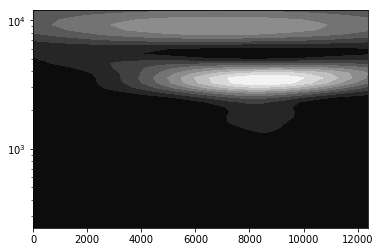

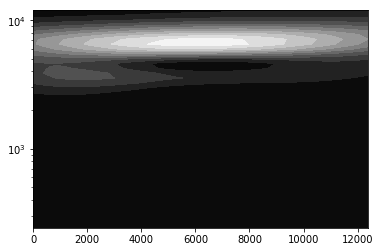

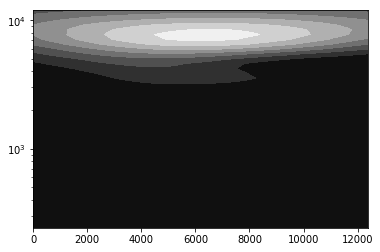

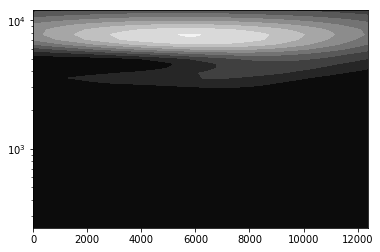

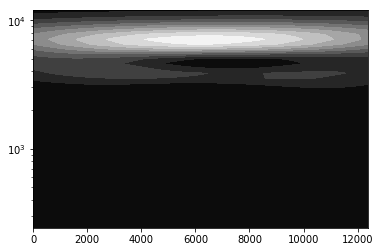

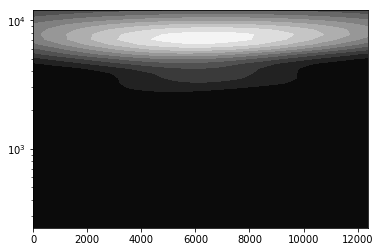

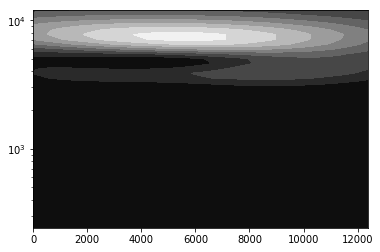

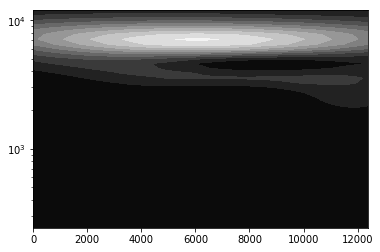

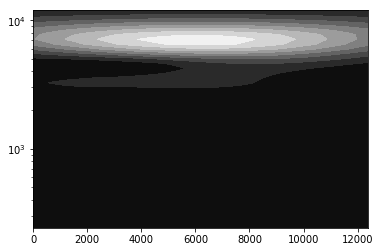

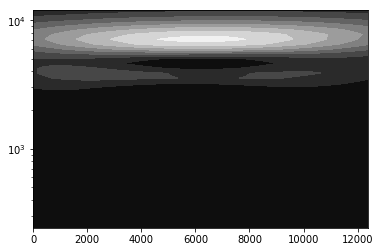

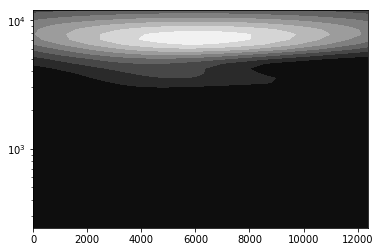

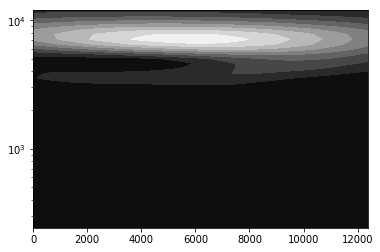

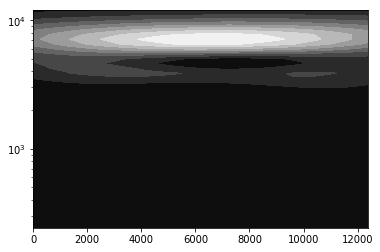

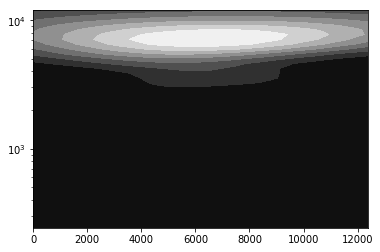

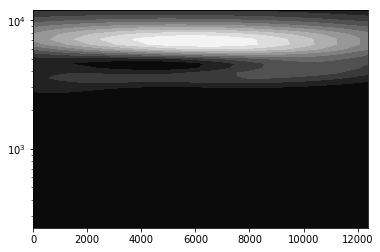

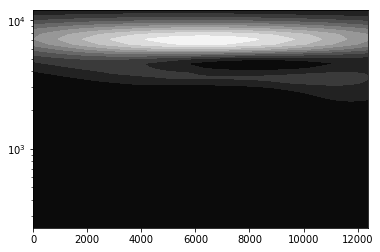

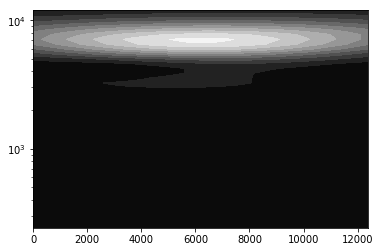

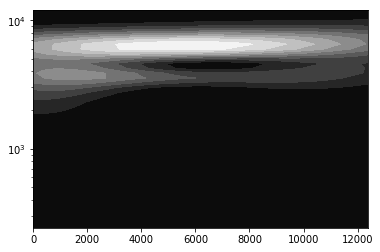

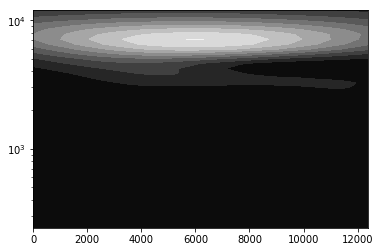

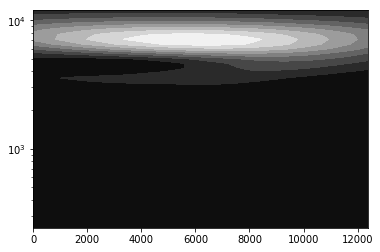

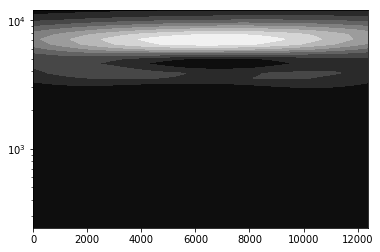

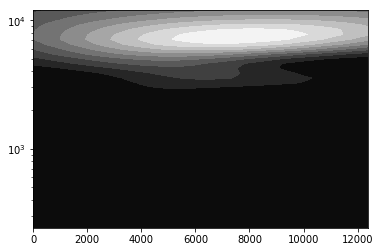

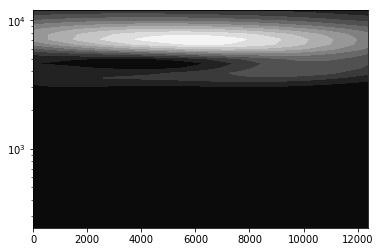

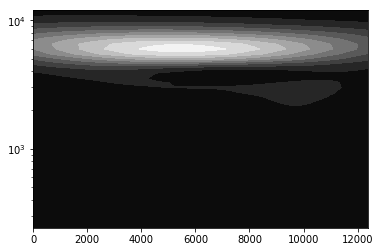

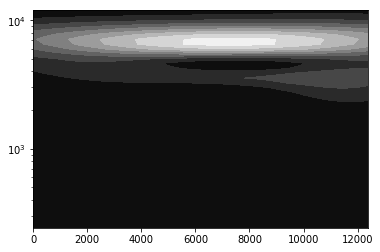

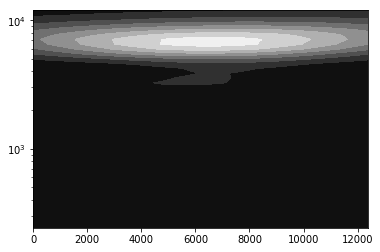

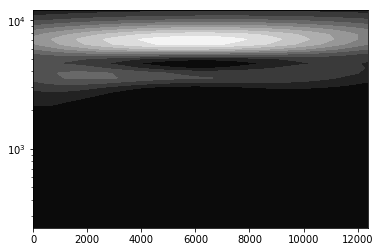

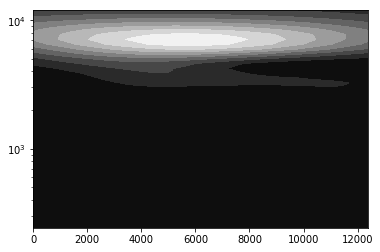

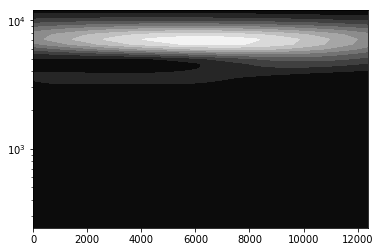

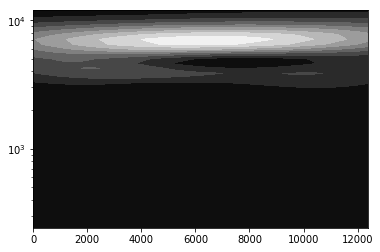

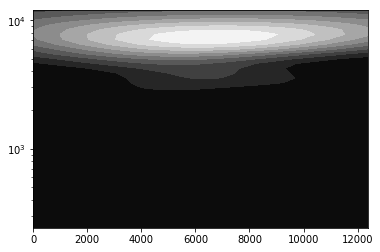

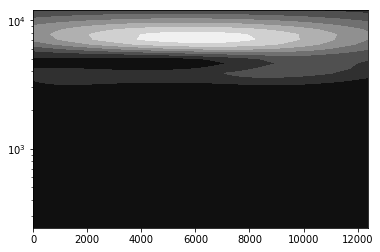

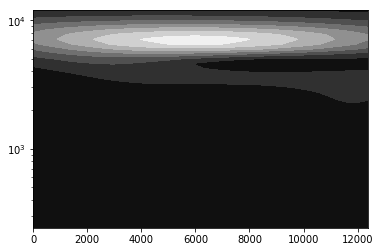

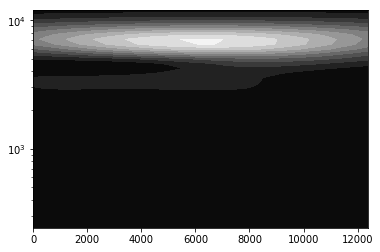

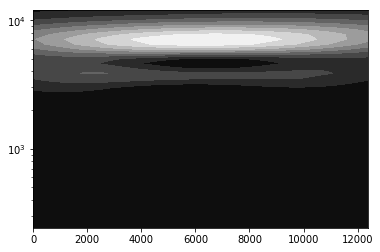

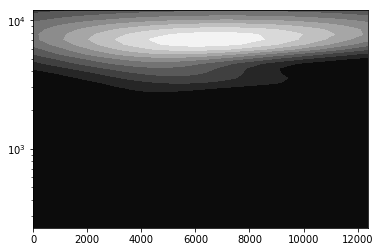

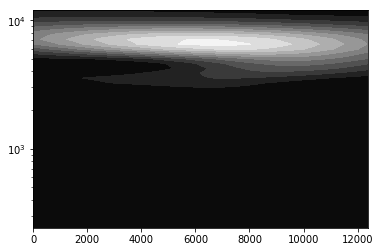

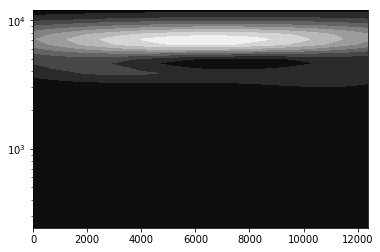

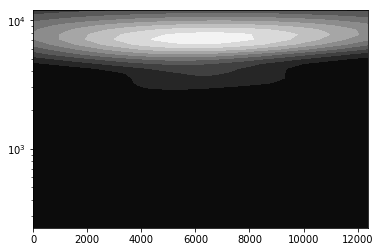

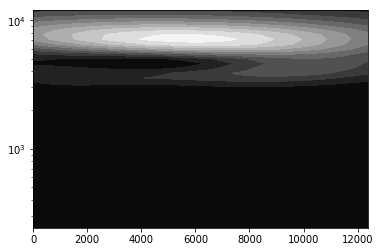

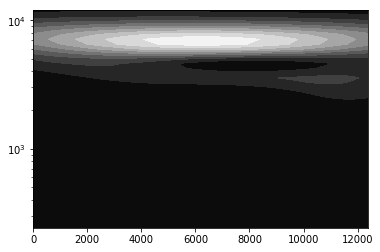

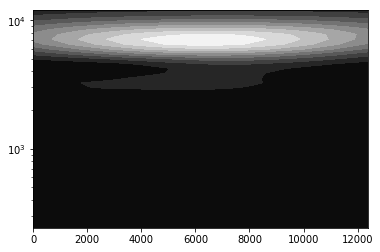

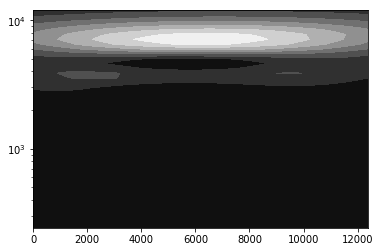

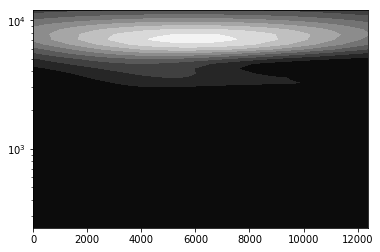

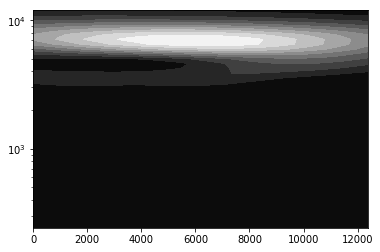

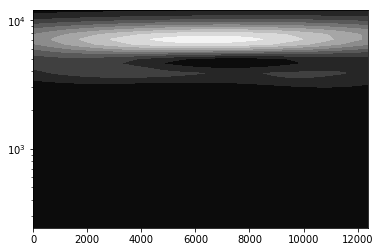

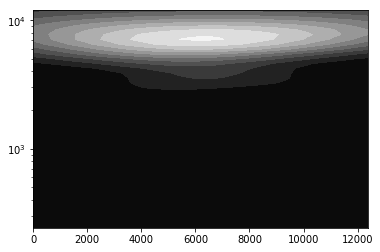

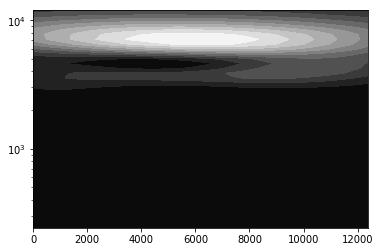

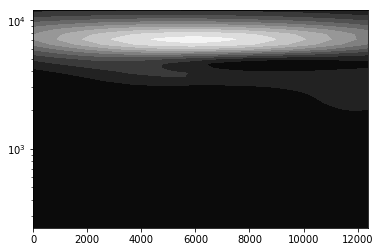

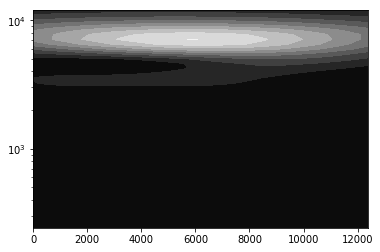

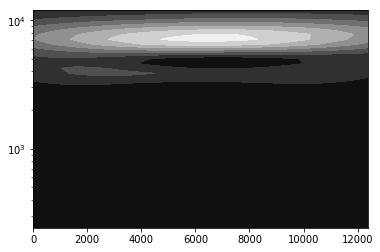

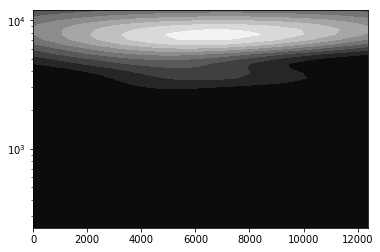

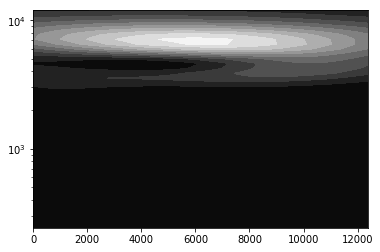

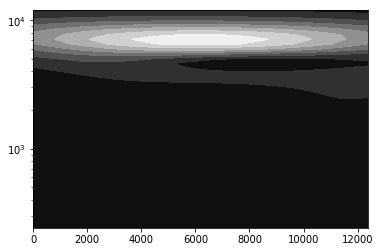

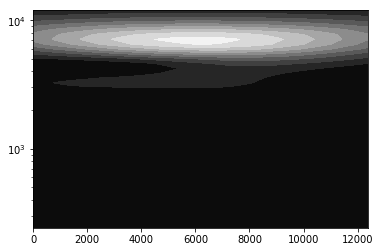

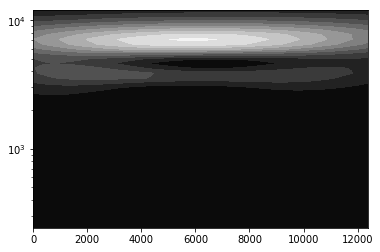

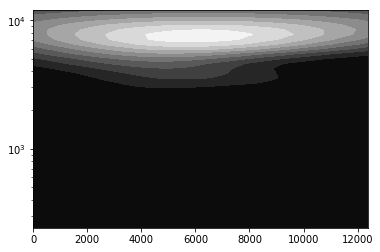

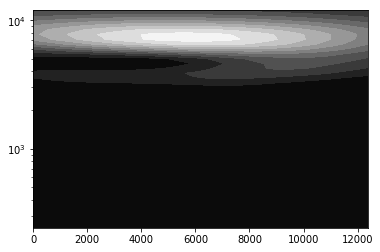

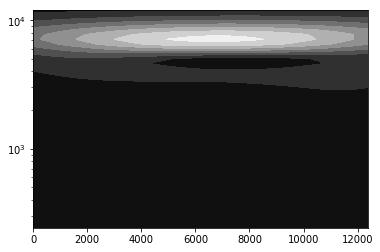

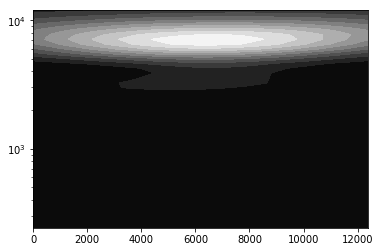

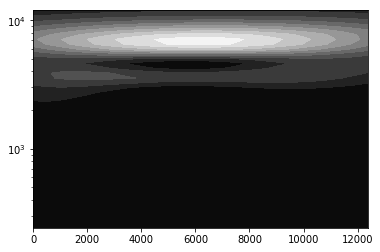

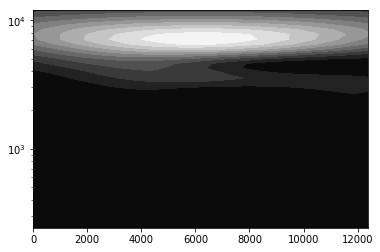

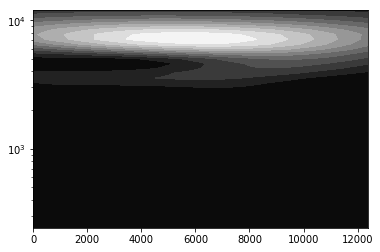

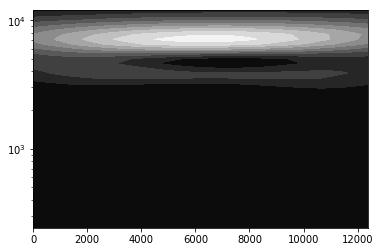

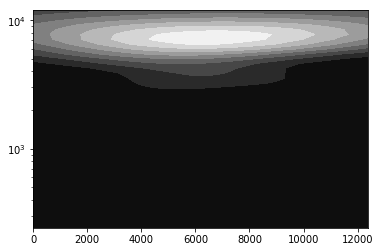

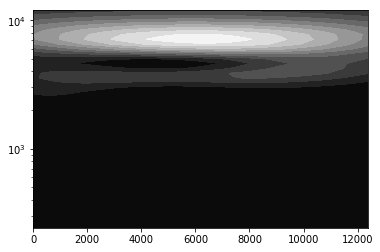

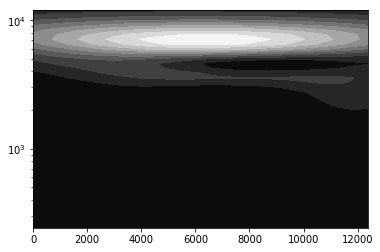

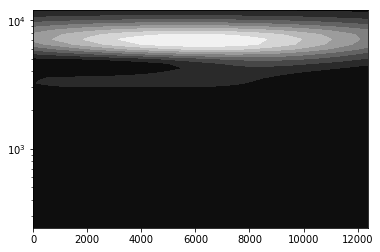

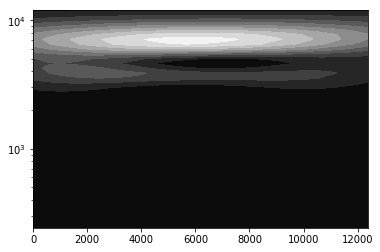

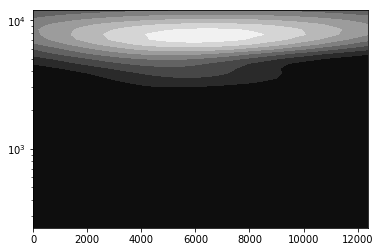

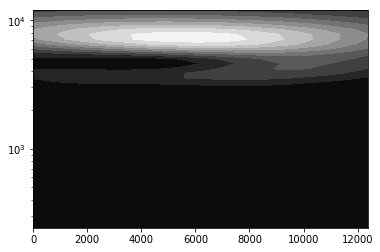

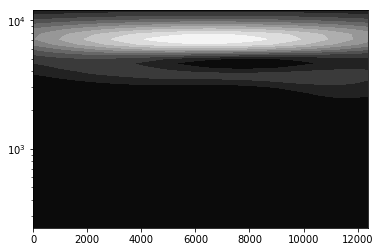

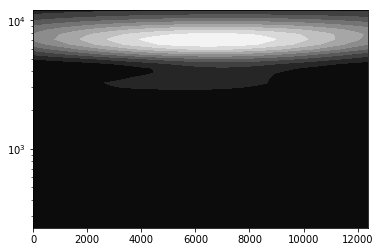

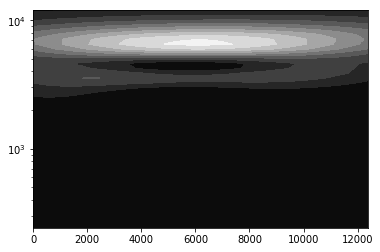

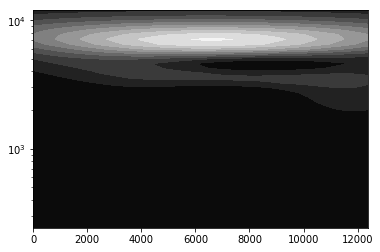

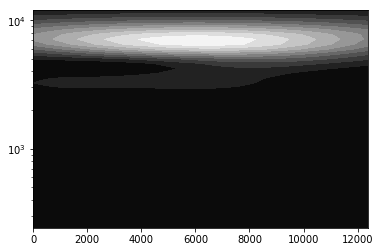

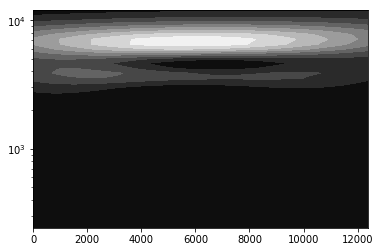

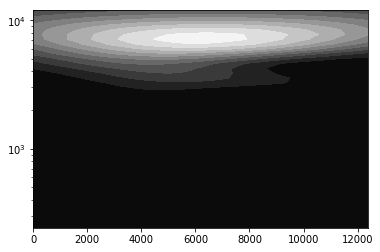

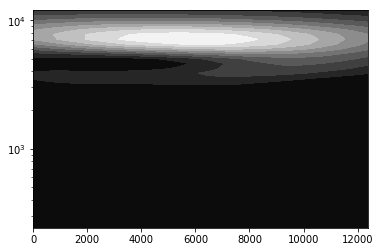

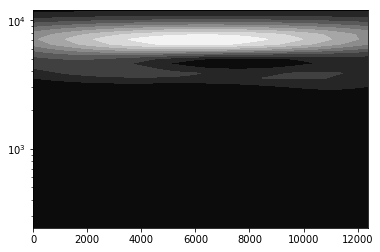

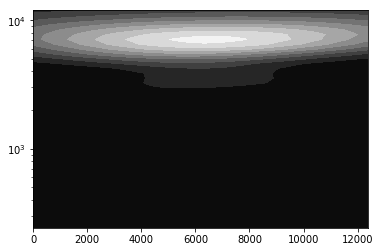

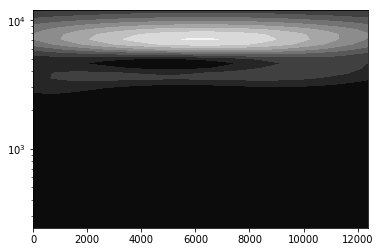

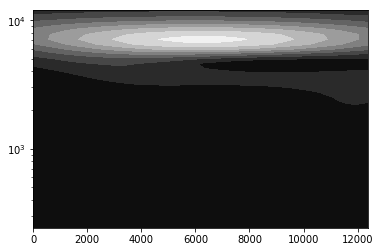

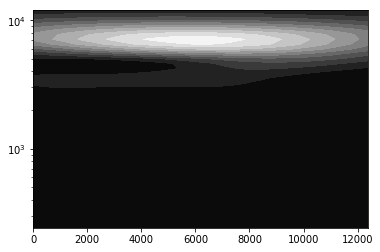

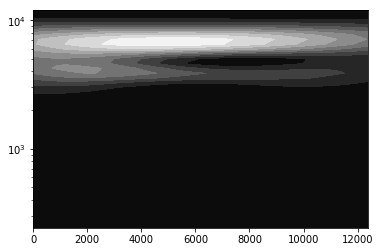

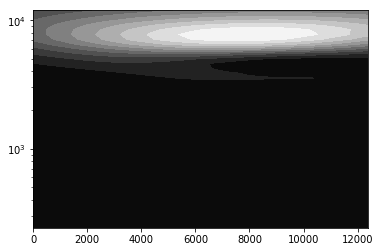

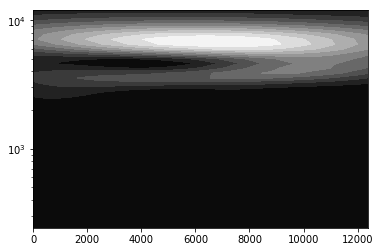

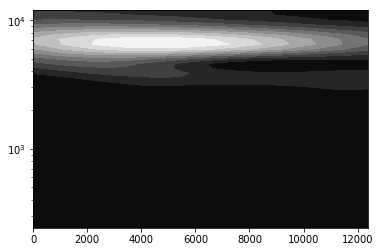

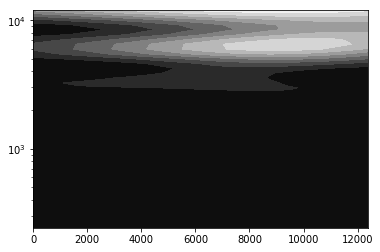

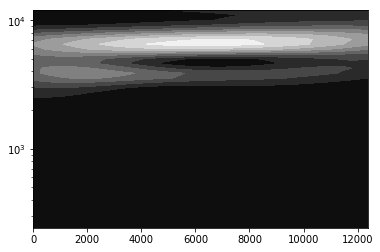

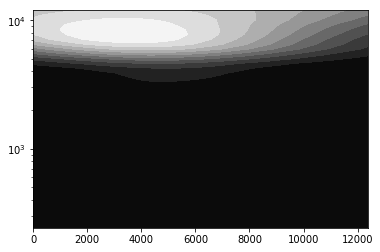

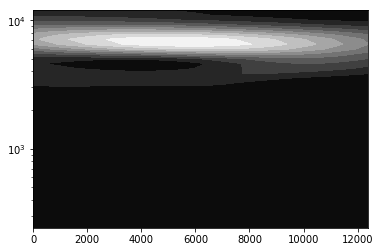

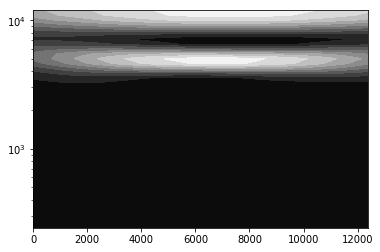

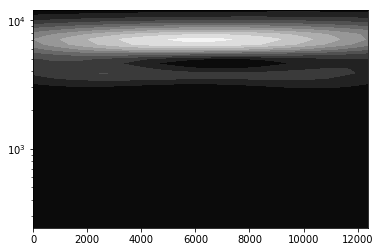

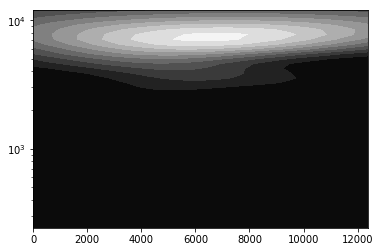

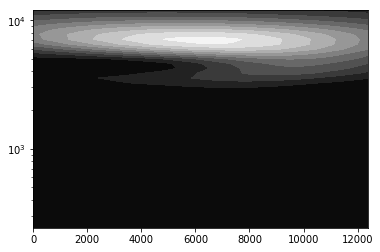

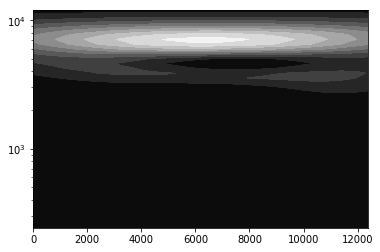

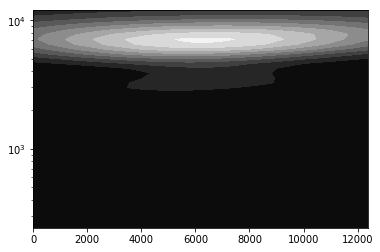

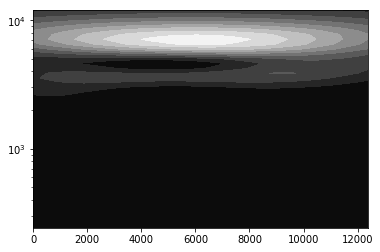

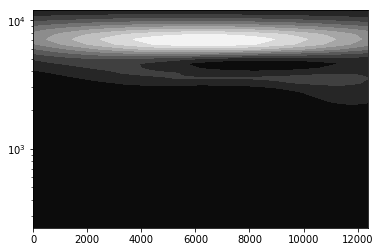

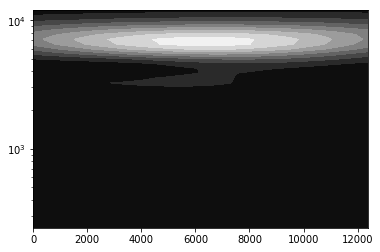

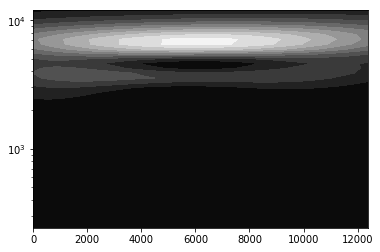

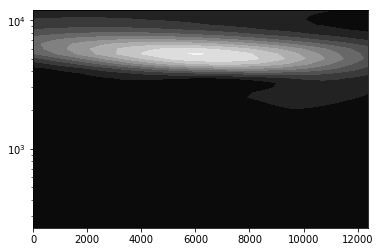

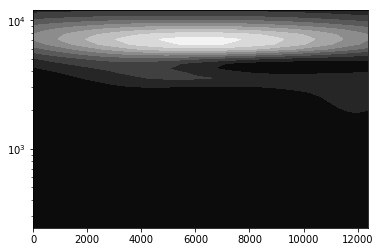

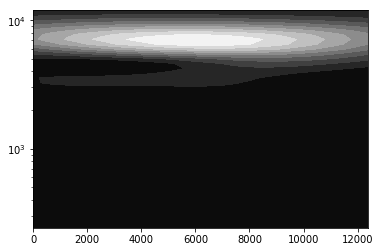

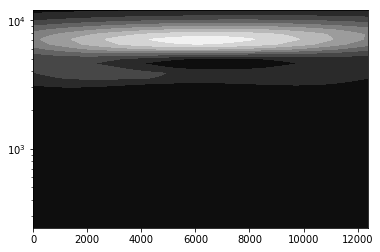

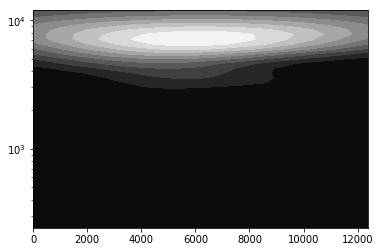

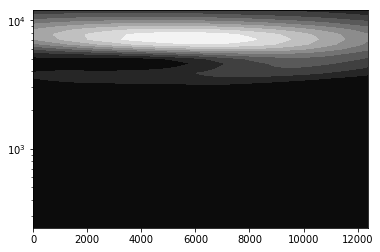

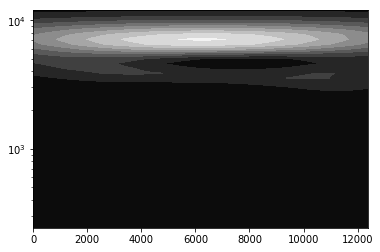

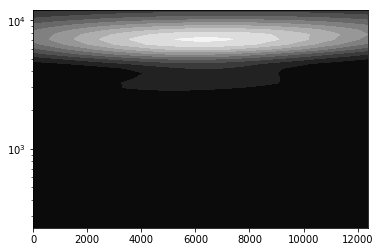

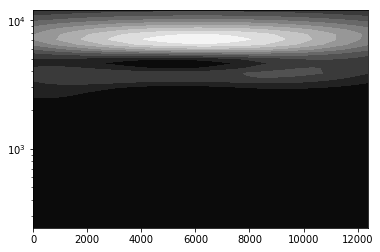

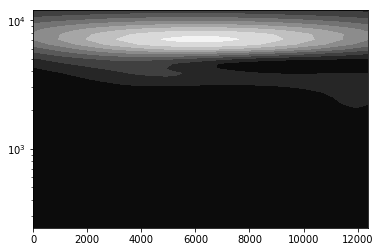

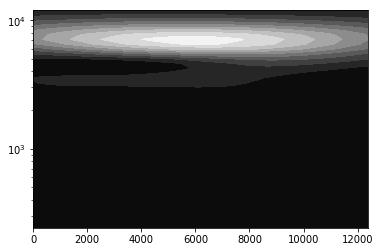

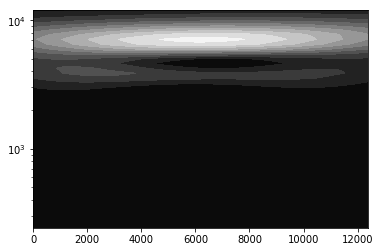

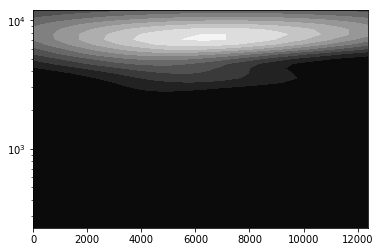

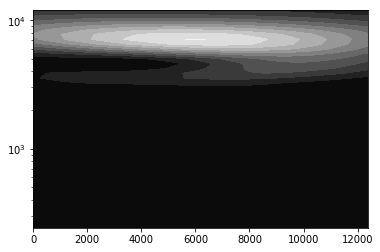

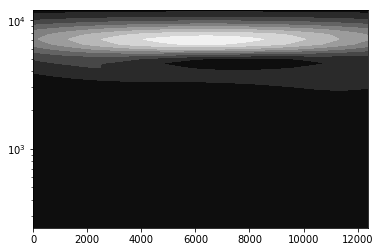

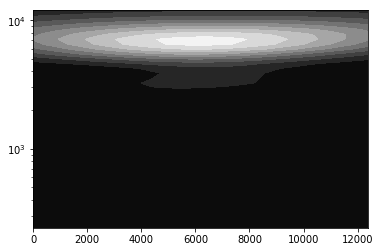

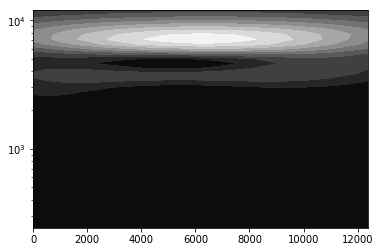

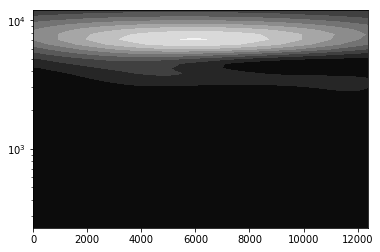

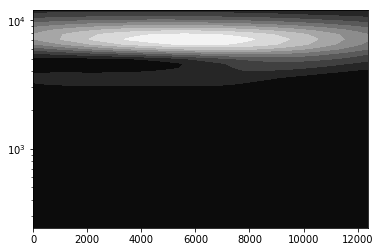

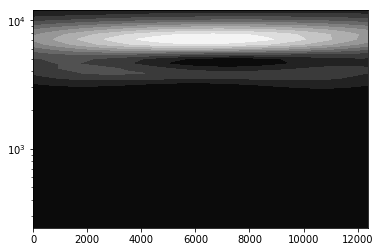

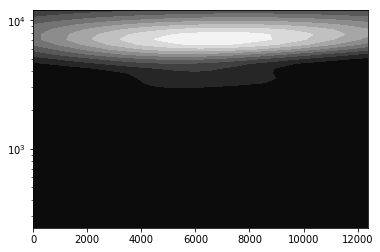

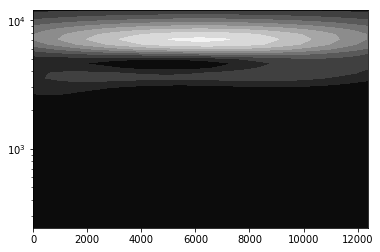

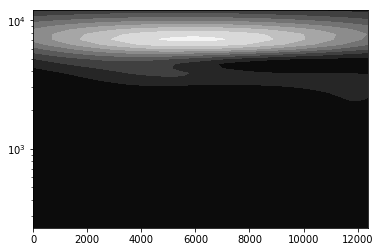

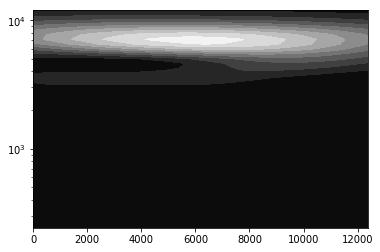

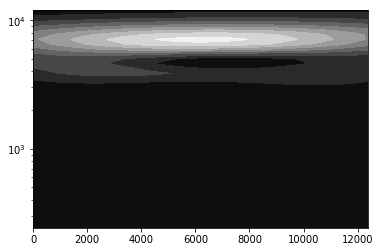

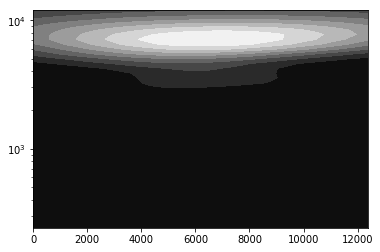

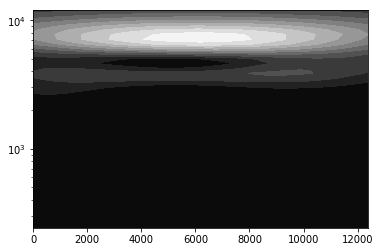

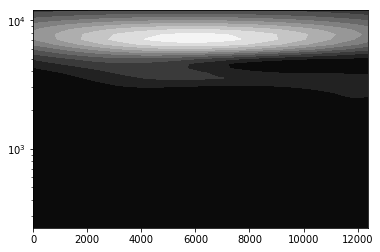

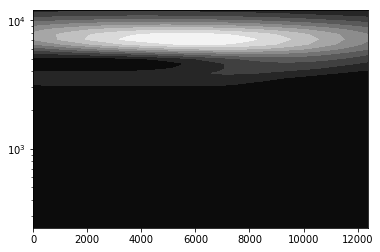

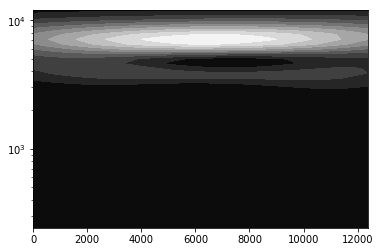

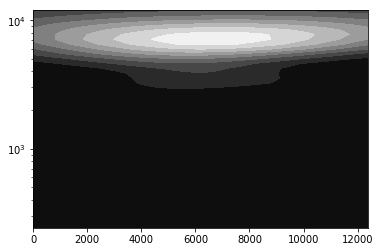

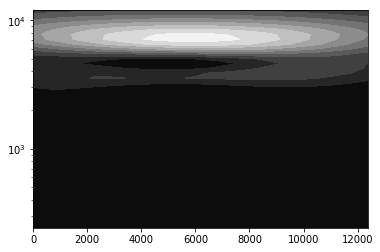

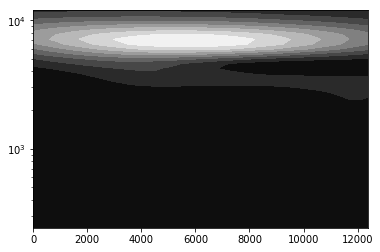

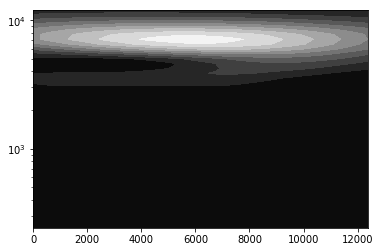

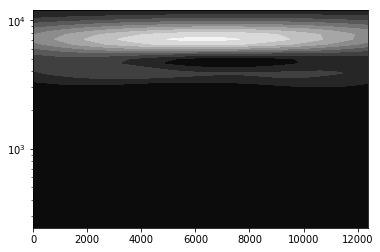

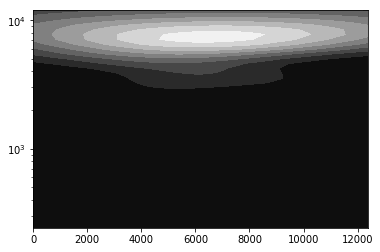

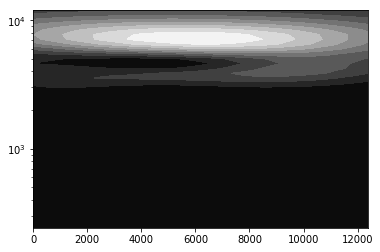

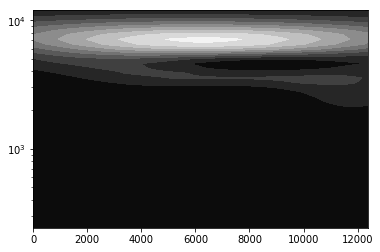

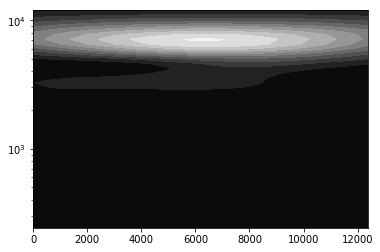

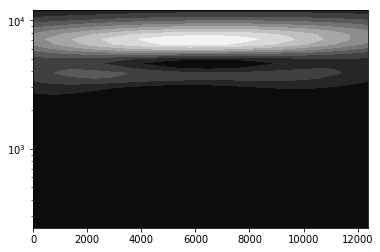

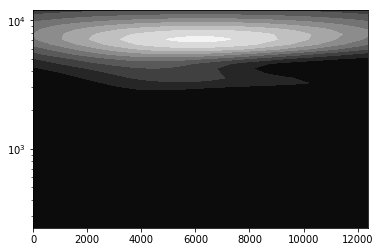

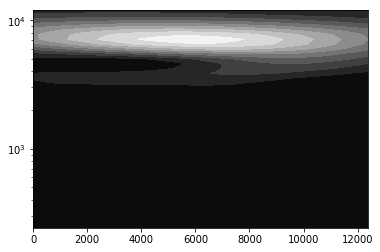

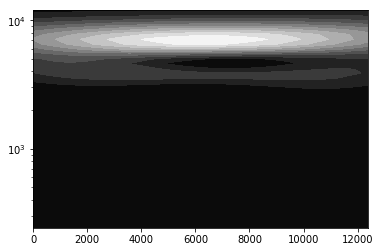

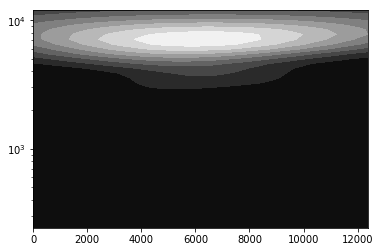

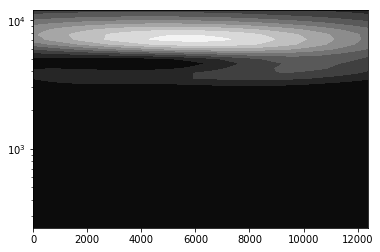

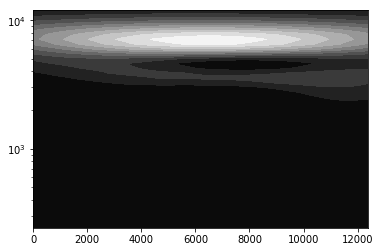

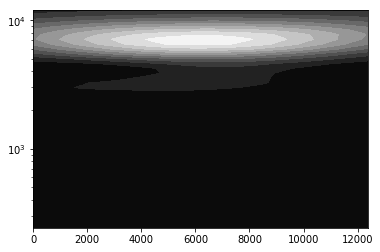

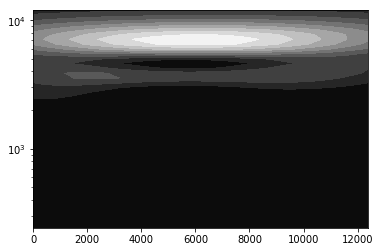

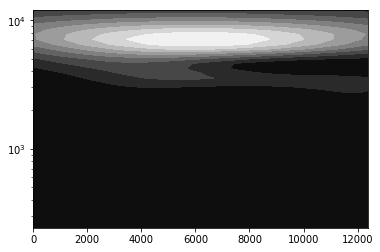

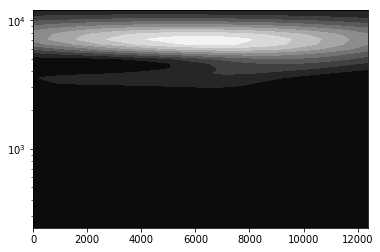

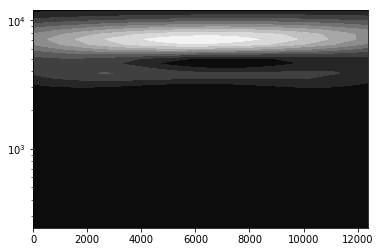

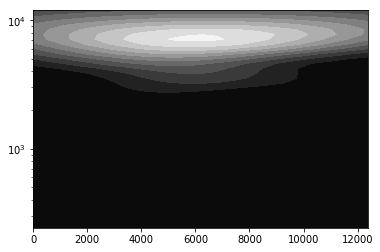

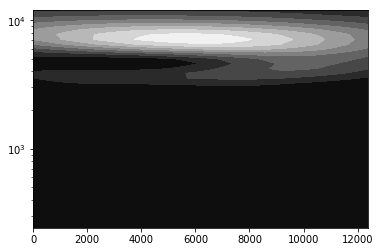

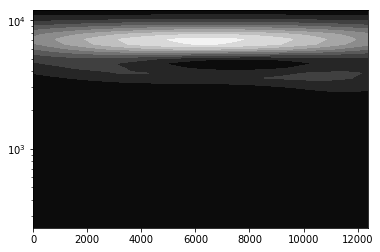

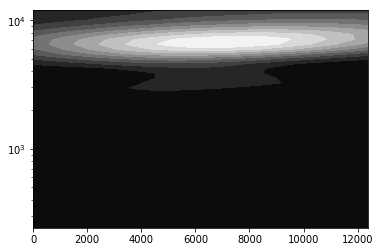

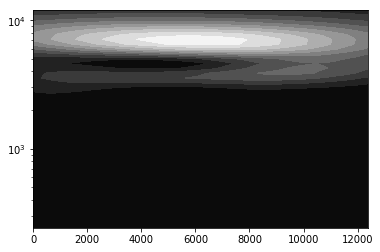

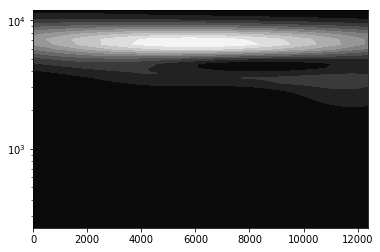

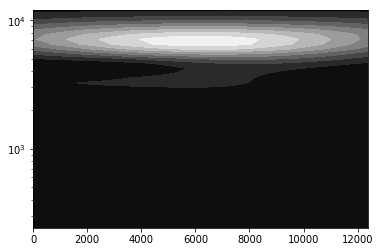

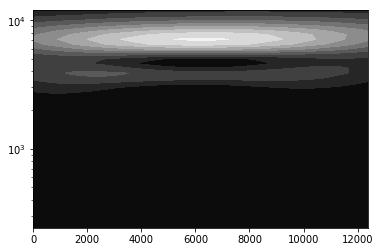

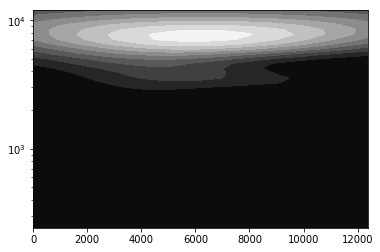

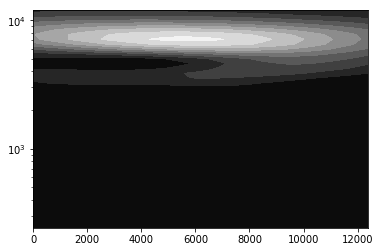

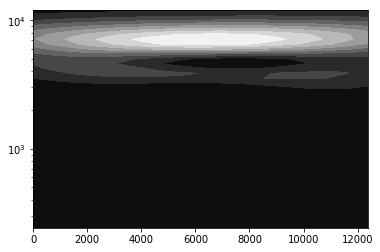

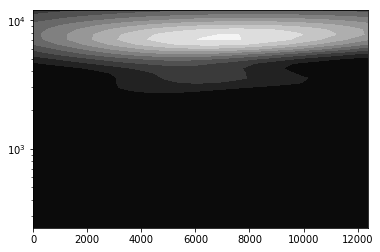

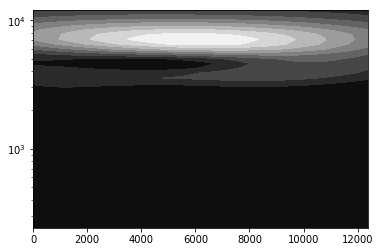

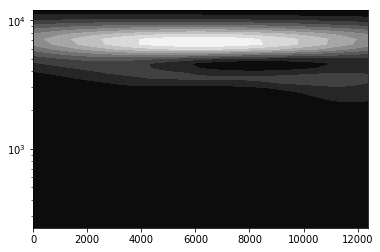

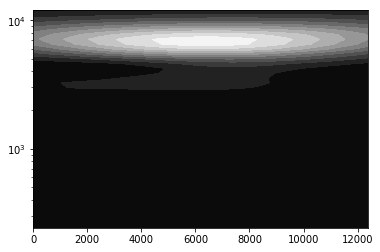

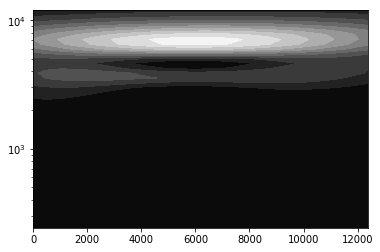

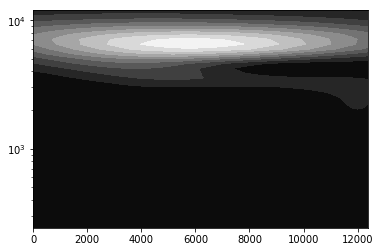

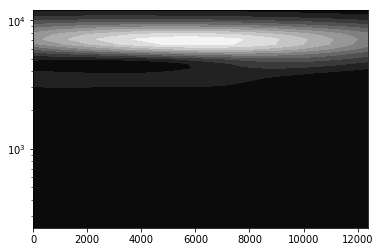

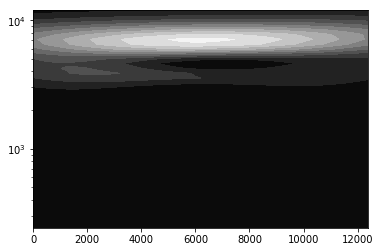

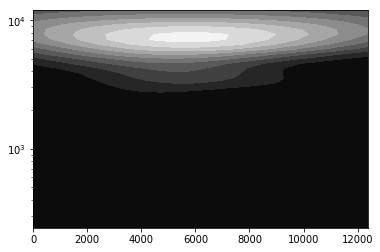

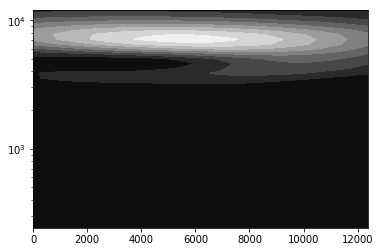

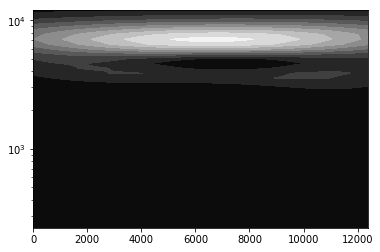

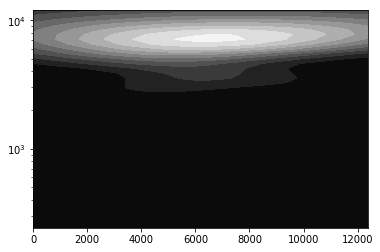

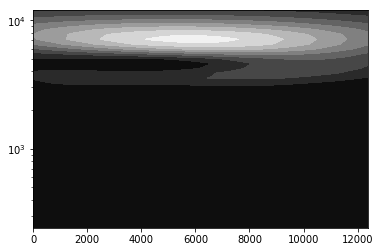

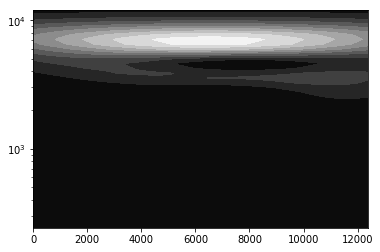

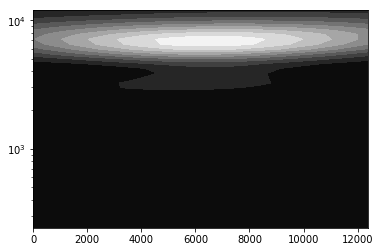

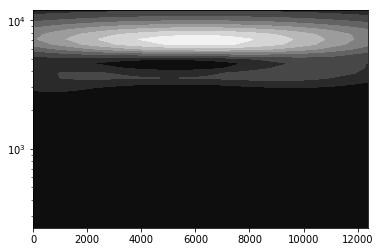

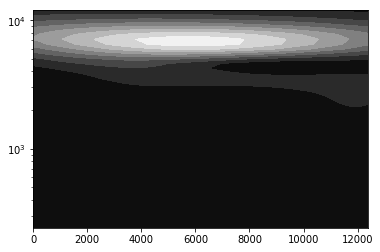

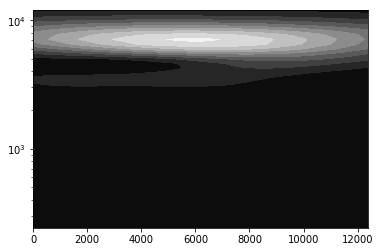

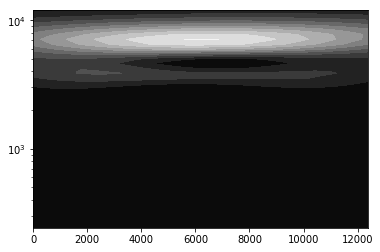

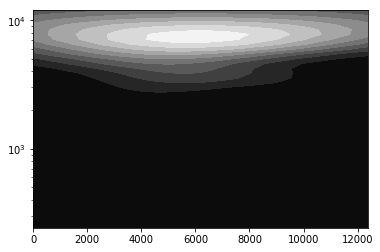

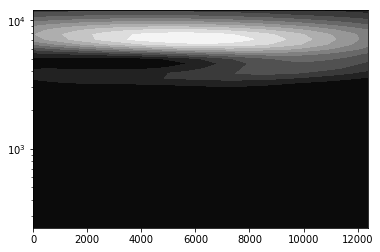

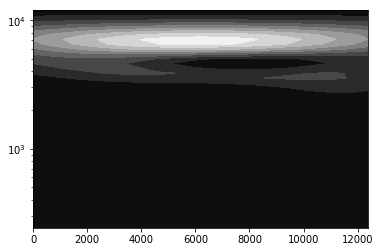

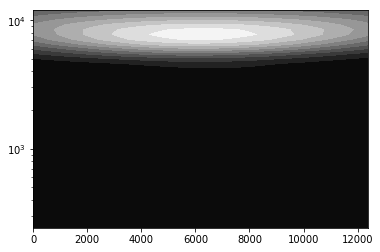

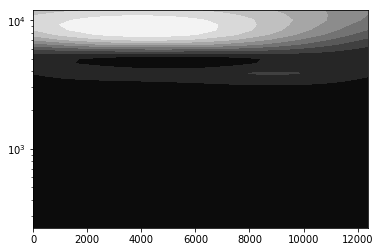

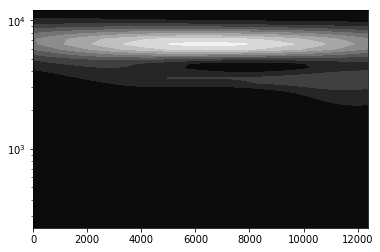

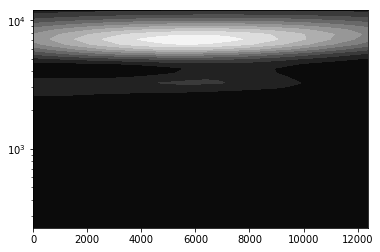

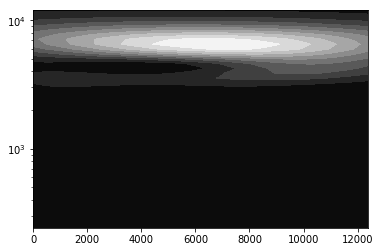

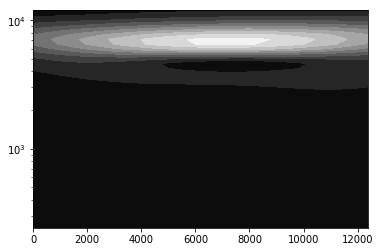

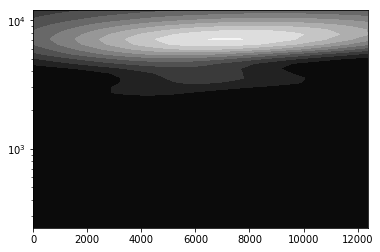

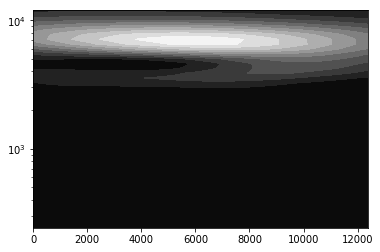

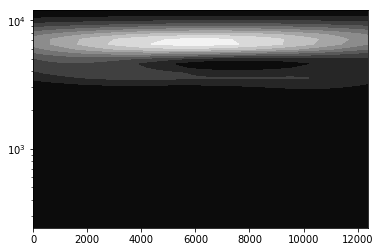

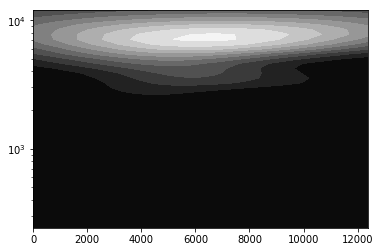

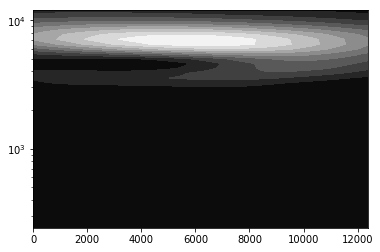

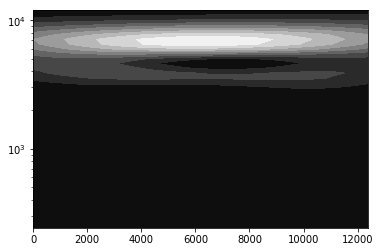

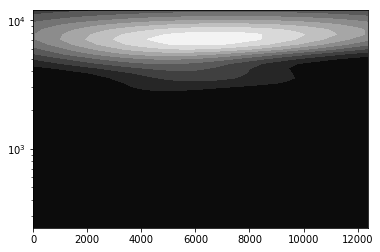

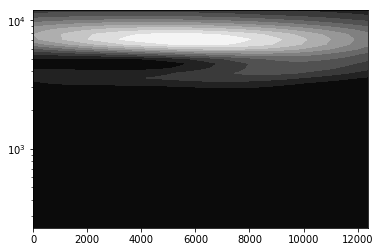

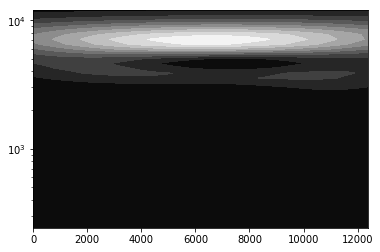

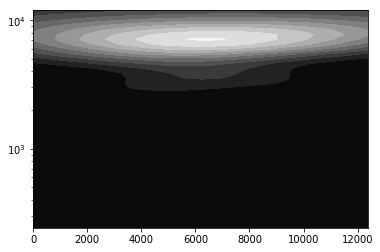

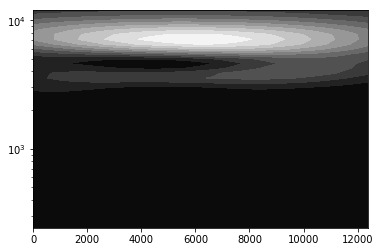

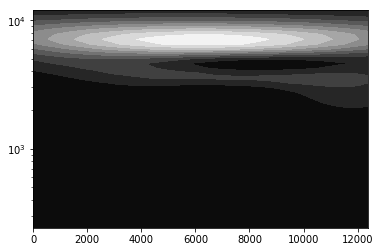

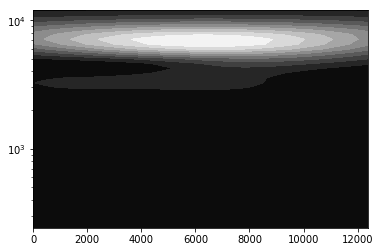

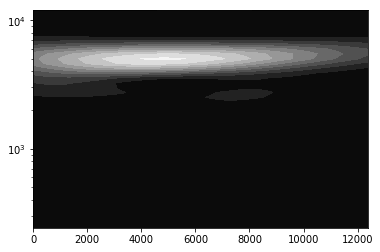

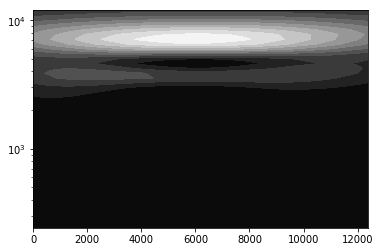

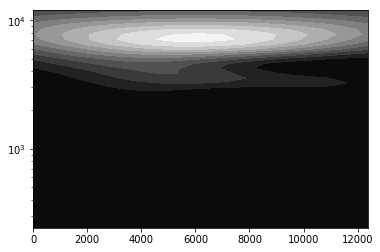

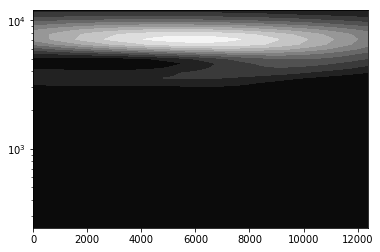

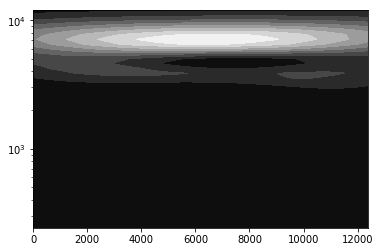

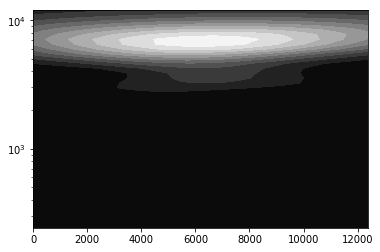

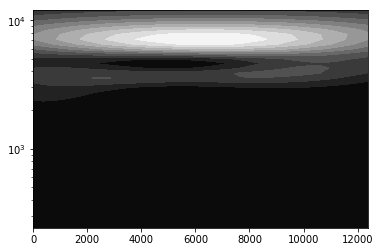

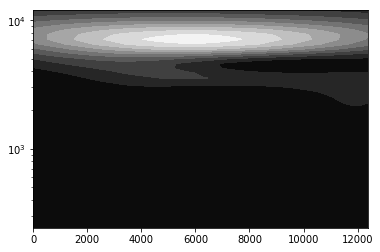

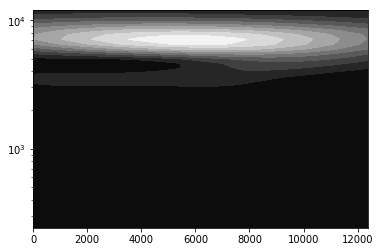

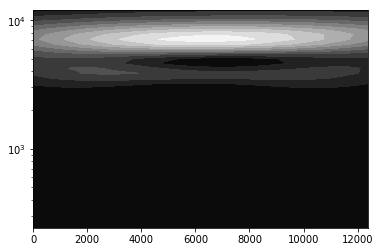

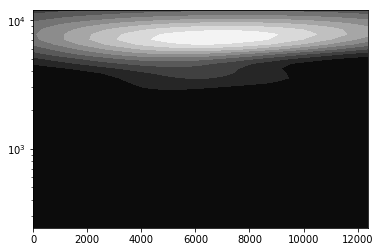

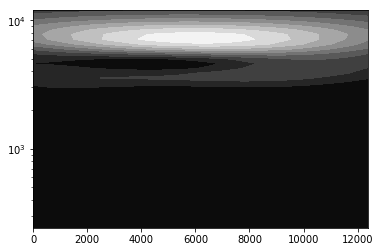

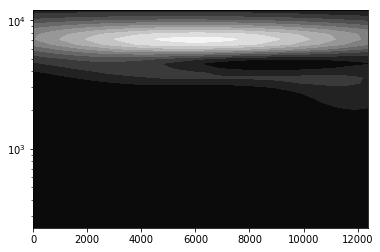

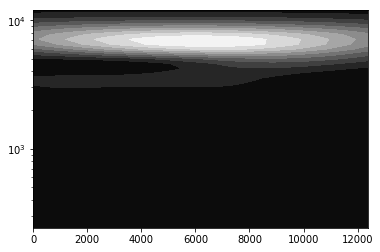

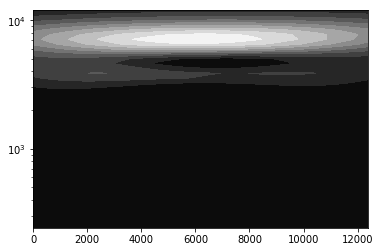

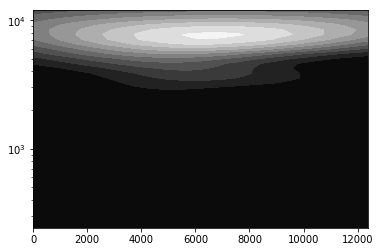

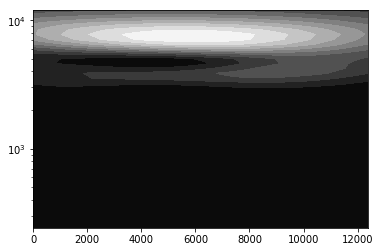

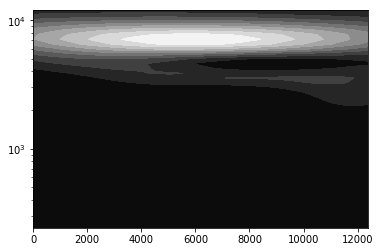

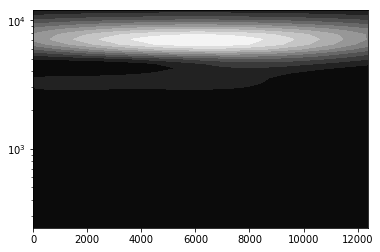

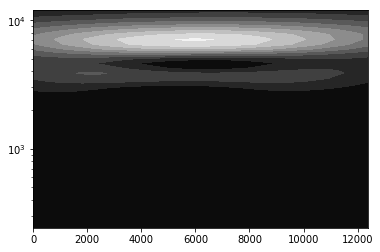

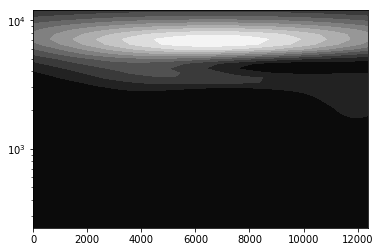

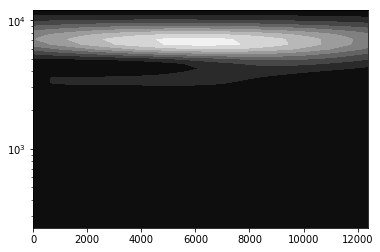

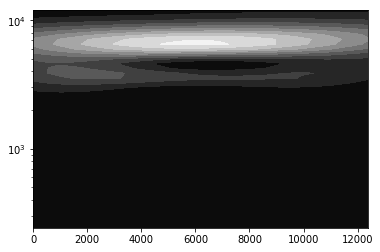

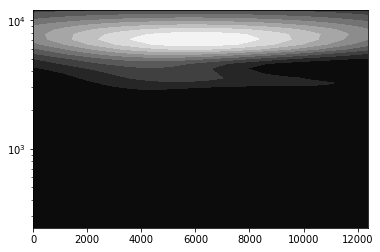

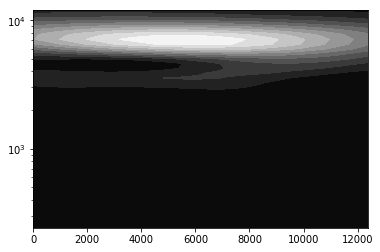

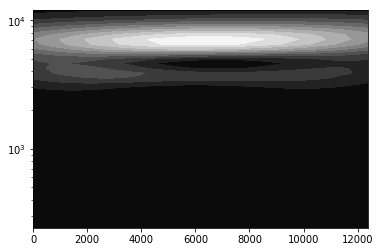

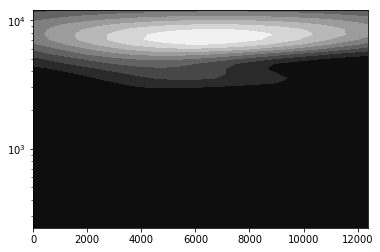

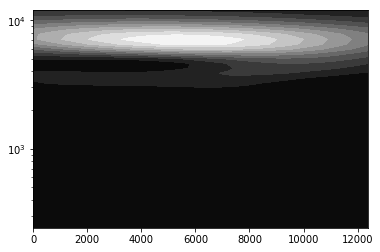

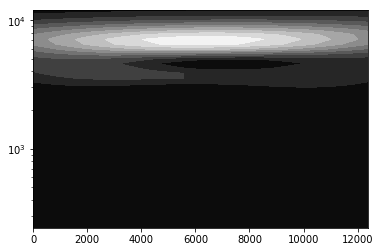

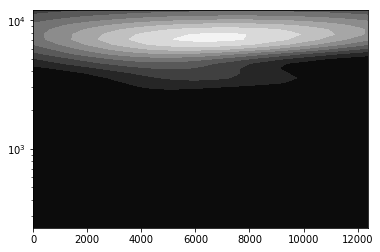

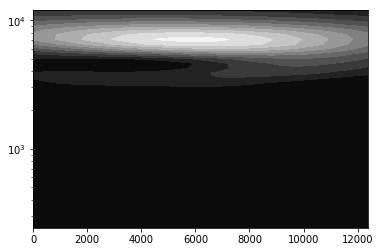

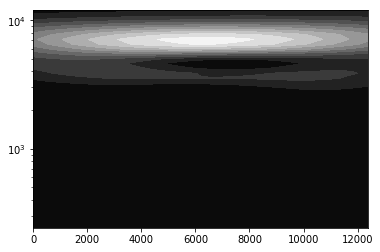

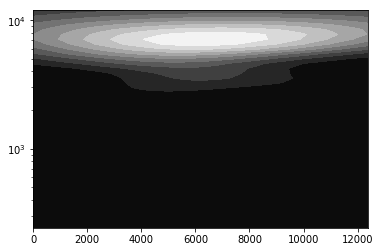

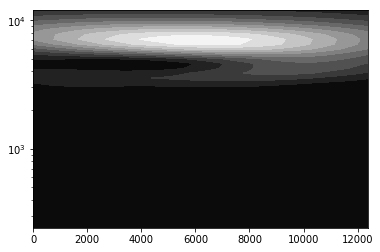

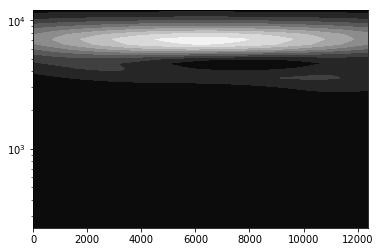

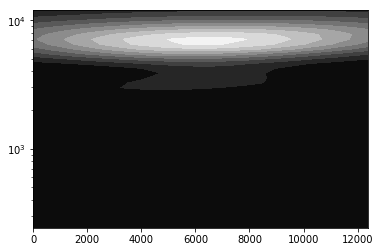

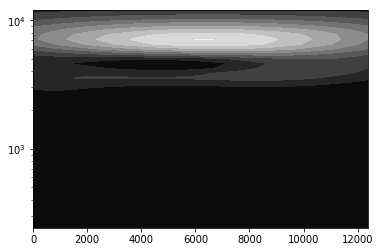

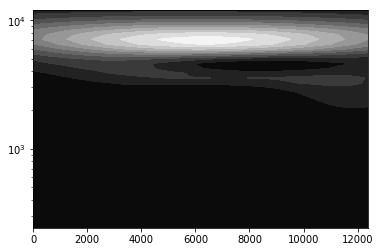

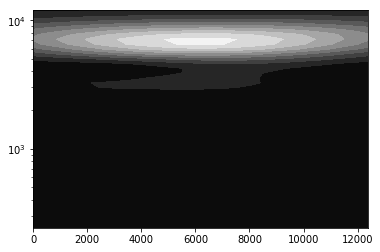

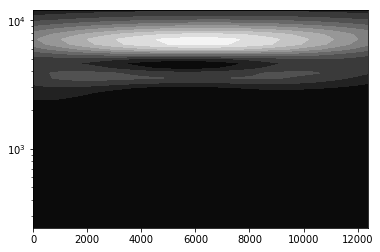

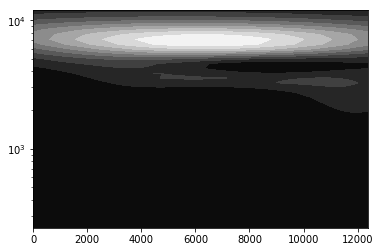

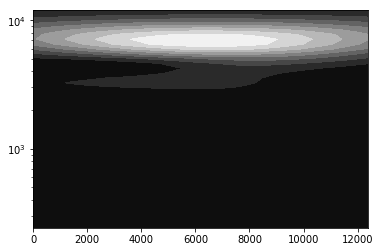

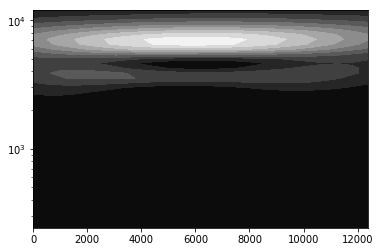

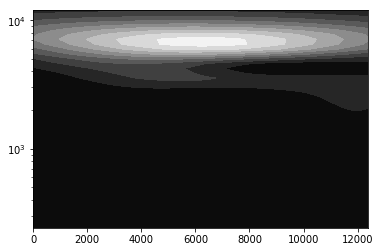

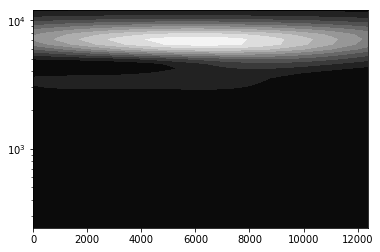

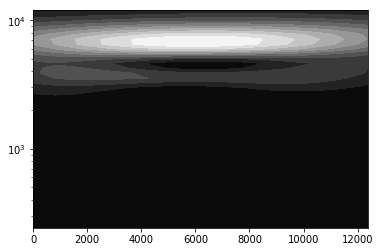

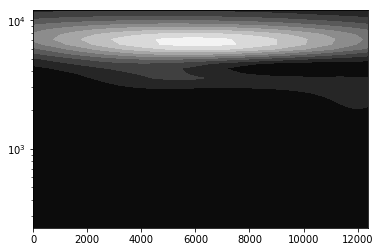

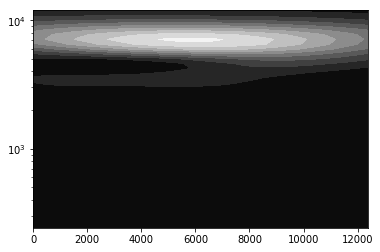

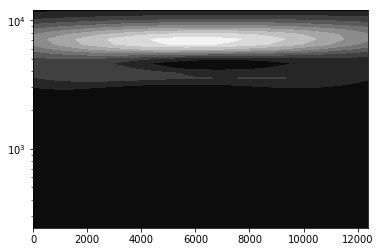

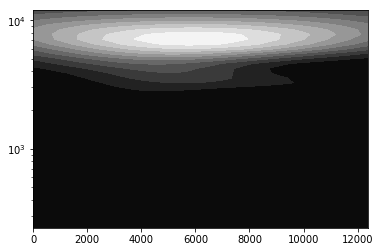

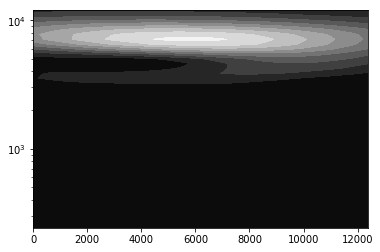

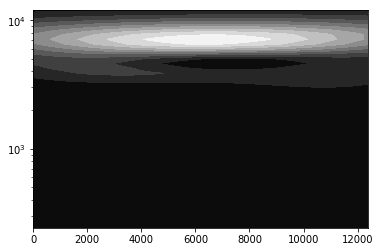

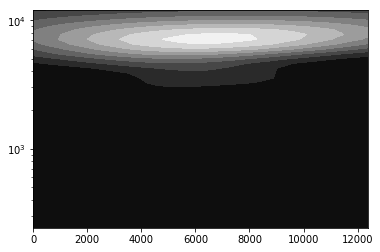

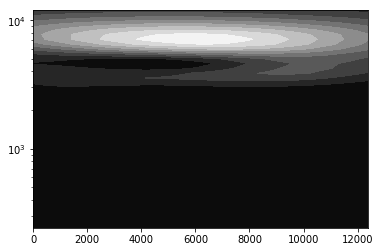

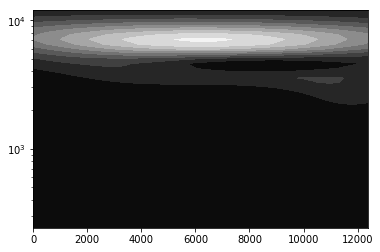

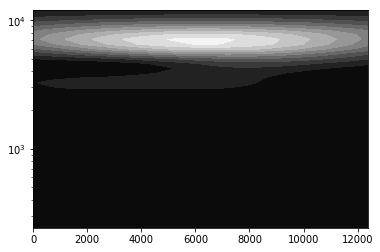

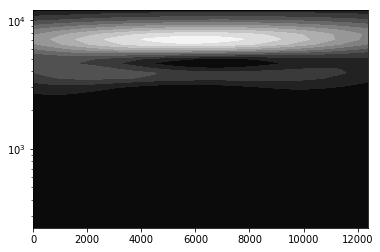

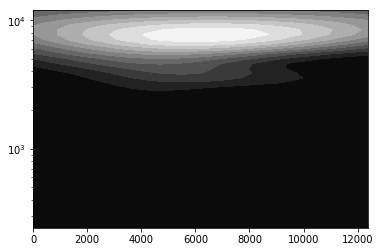

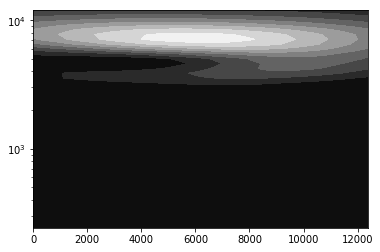

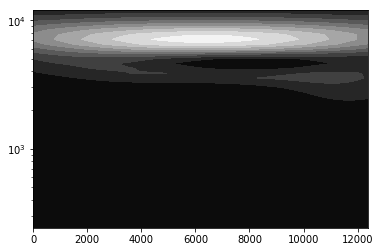

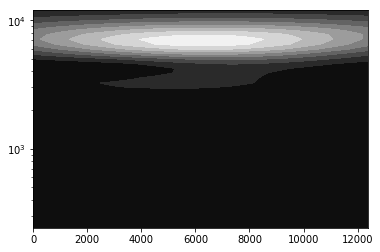

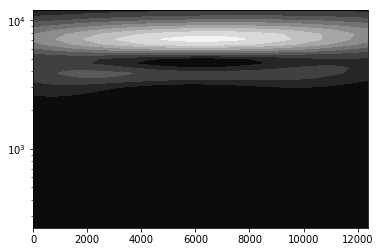

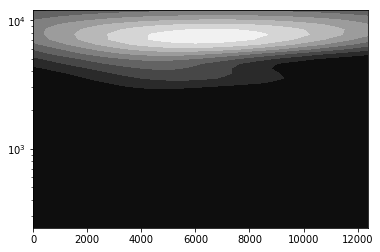

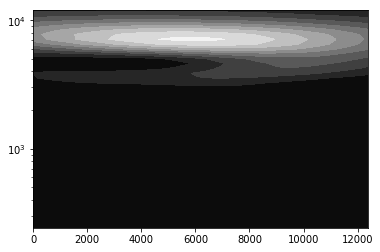

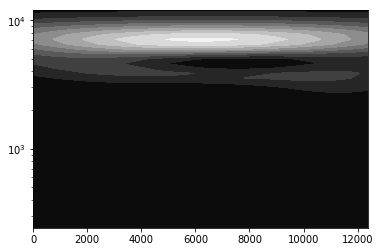

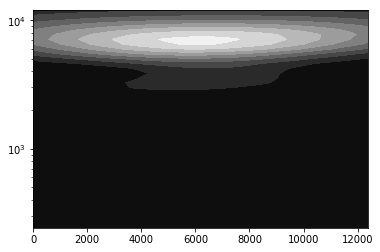

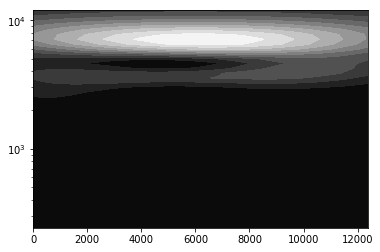

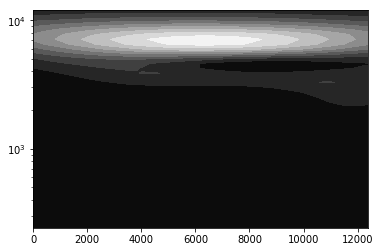

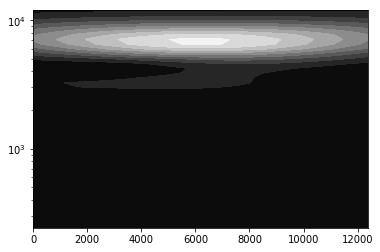

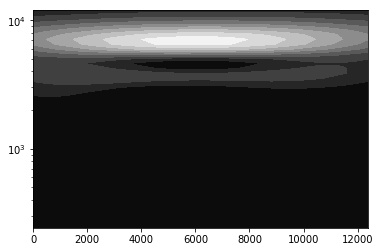

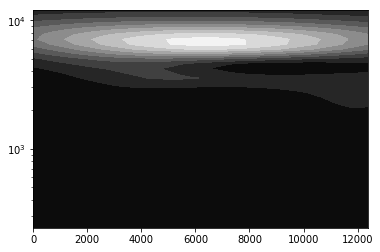

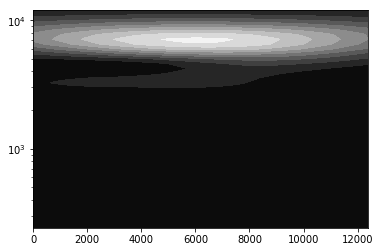

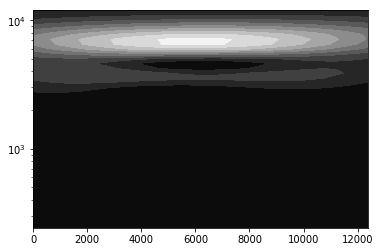

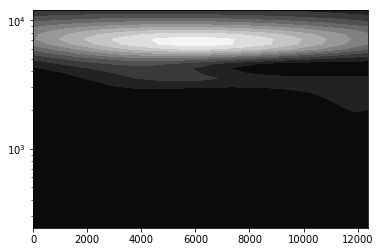

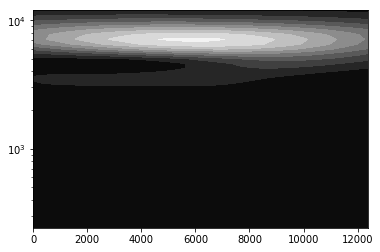

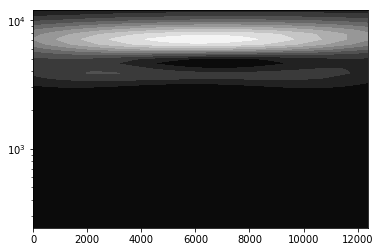

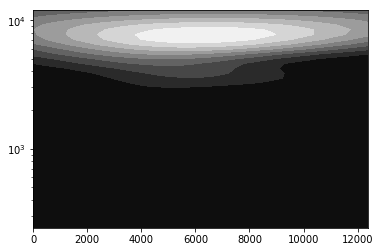

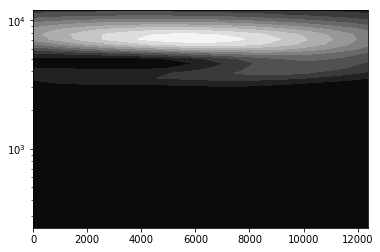

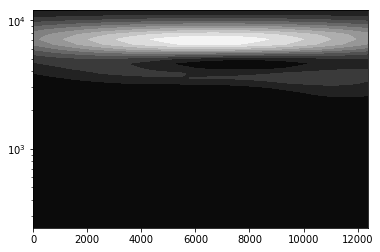

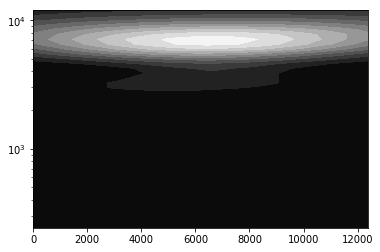

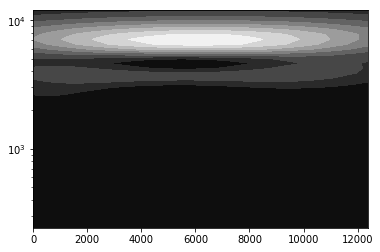

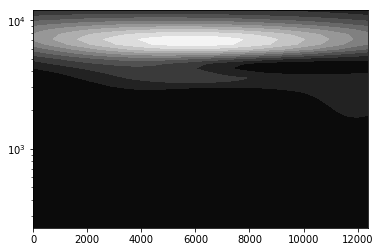

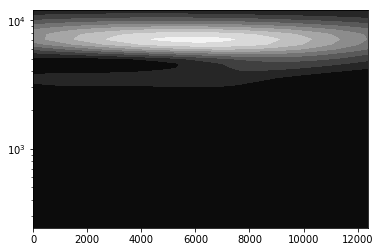

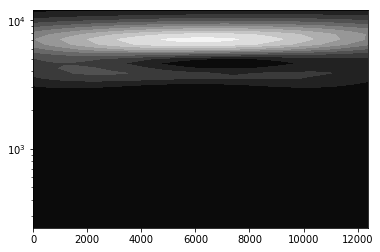

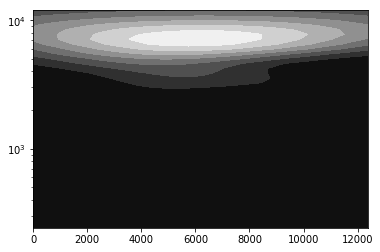

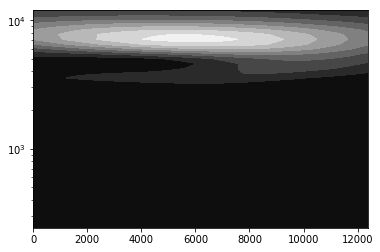

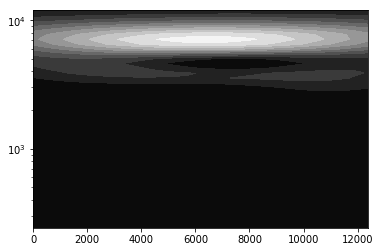

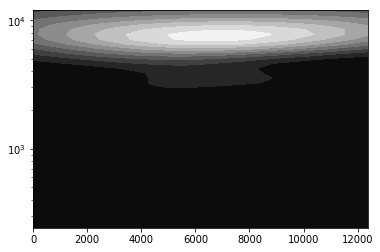

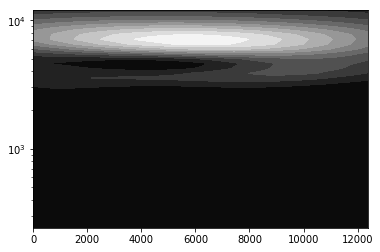

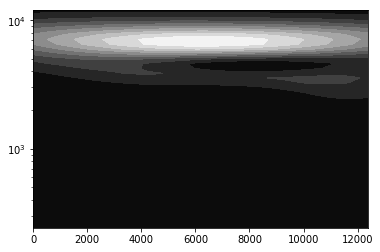

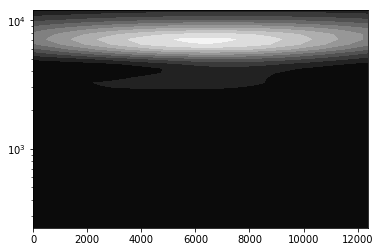

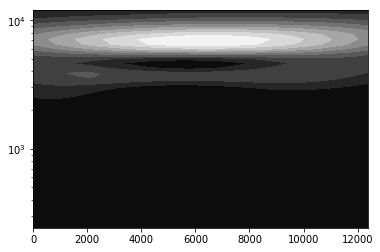

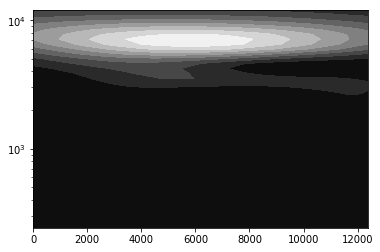

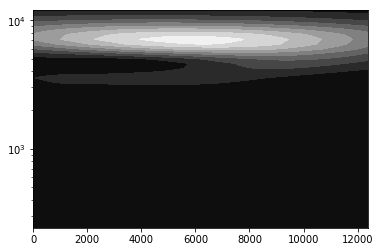

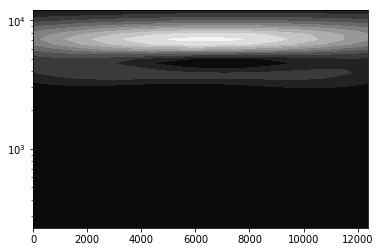

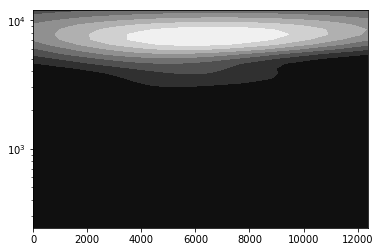

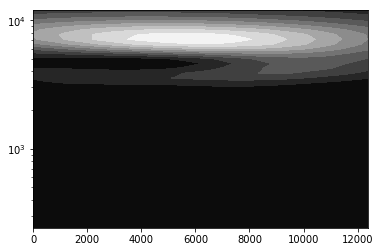

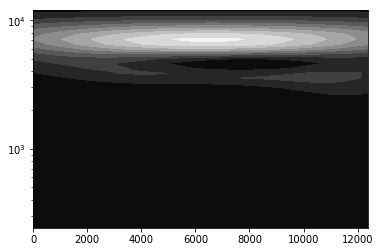

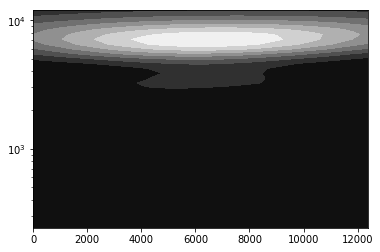

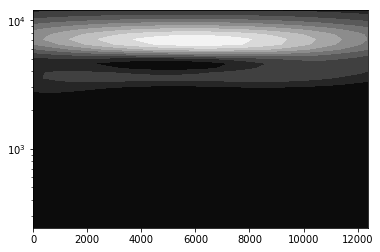

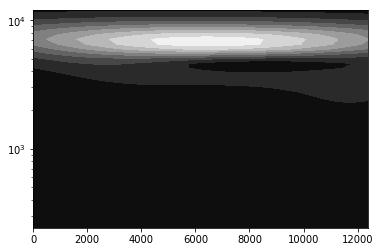

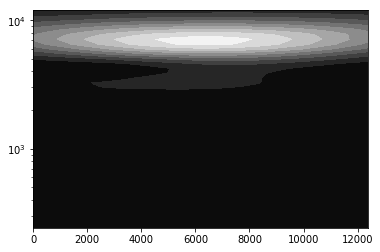

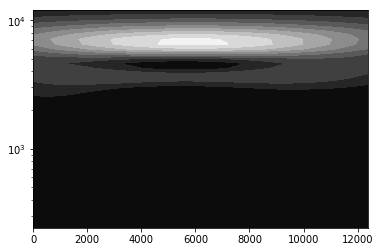

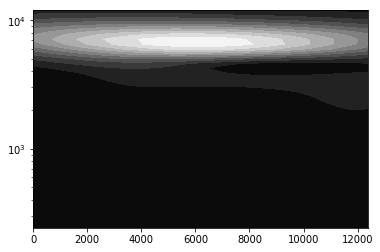

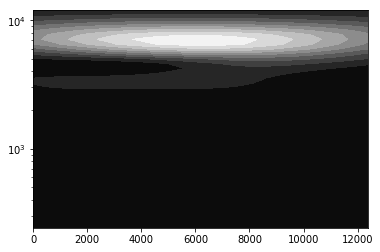

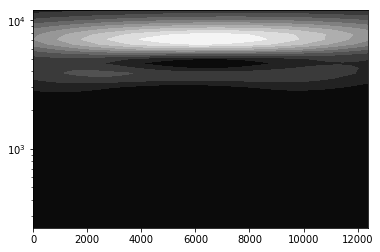

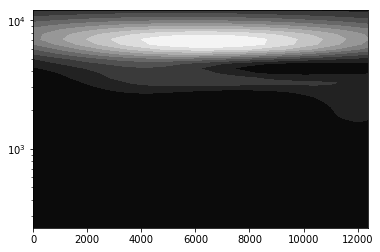

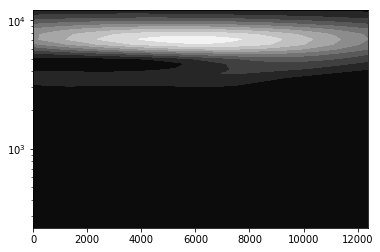

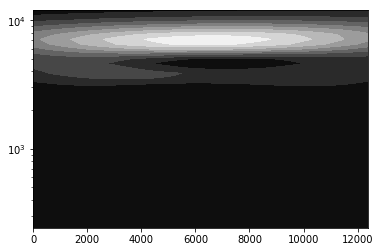

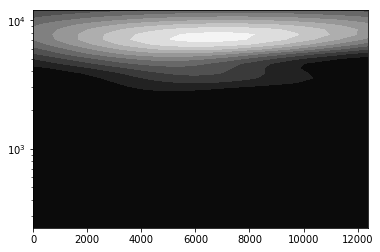

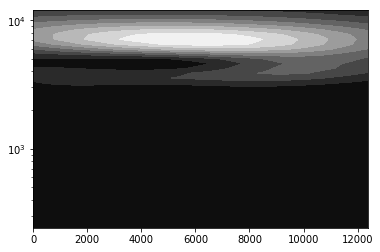

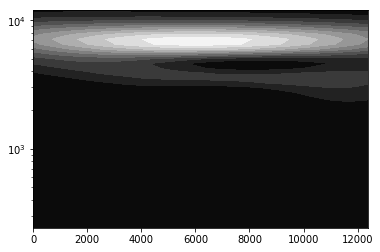

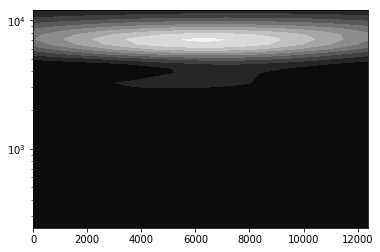

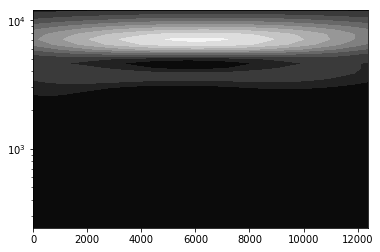

In [9]:
datafile = 'Part_1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data2D(datafile, input_size, 10)
#Saving X data tricky since it is 3D
shape = np.array([X_train.shape, X_val.shape, X_test.shape])
np.savetxt('/Users/alisa/Desktop/HW2/shape.txt', shape)
files = ['/Users/alisa/Desktop/HW2/xtrain.txt', '/Users/alisa/Desktop/HW2/xval.txt', '/Users/alisa/Desktop/HW2/xtest.txt']
data = [X_train, X_val, X_test]
for fil, dat in zip(files, data):
    save_f(dat.astype(float), fil)
    
#saving y data is simple has to be
y_files = ['/Users/alisa/Desktop/HW2/ytrain.txt', '/Users/alisa/Desktop/HW2/yval.txt', '/Users/alisa/Desktop/HW2/ytest.txt']
y_data = [y_train, y_val, y_test]

for fil, dat in zip(y_files, y_dat):
    np.savetxt(fil, dat.astype(float), fmt="%.10f")


### Save data

In [78]:
datafile = 'Part_1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile, input_size, 125)

y_files = ['/Users/alisa/Desktop/HW2/xtrain.txt', '/Users/alisa/Desktop/HW2/xval.txt', '/Users/alisa/Desktop/HW2/xtest.txt', '/Users/alisa/Desktop/HW2/ytrain.txt', '/Users/alisa/Desktop/HW2/yval.txt', '/Users/alisa/Desktop/HW2/ytest.txt']
y_data = [X_train, X_val, X_test, y_train, y_val, y_test]

for fil, dat in zip(y_files, y_data):
    np.savetxt(fil, dat.astype(float), fmt="%.10f")



['#refs#', 'Part_1']
dd 0 1000
dd 5 1005
dd 10 1010
dd 15 1015
dd 20 1020
dd 25 1025
dd 30 1030
dd 35 1035
dd 40 1040
dd 45 1045
dd 50 1050
dd 55 1055
dd 60 1060
dd 65 1065
dd 70 1070
dd 75 1075
dd 80 1080
dd 85 1085
dd 90 1090
dd 95 1095
dd 100 1100
dd 105 1105
dd 110 1110
dd 115 1115
dd 120 1120
dd 125 1125
dd 130 1130
dd 135 1135
dd 140 1140
dd 145 1145
dd 150 1150
dd 155 1155
dd 160 1160
dd 165 1165
dd 170 1170
dd 175 1175
dd 180 1180
dd 185 1185
dd 190 1190
dd 195 1195
dd 200 1200
dd 205 1205
dd 210 1210
dd 215 1215
dd 220 1220
dd 225 1225
dd 230 1230
dd 235 1235
dd 240 1240
dd 245 1245
dd 250 1250
dd 255 1255
dd 260 1260
dd 265 1265
dd 270 1270
dd 275 1275
dd 280 1280
dd 285 1285
dd 290 1290
dd 295 1295
dd 300 1300
dd 305 1305
dd 310 1310
dd 315 1315
dd 320 1320
dd 325 1325
dd 330 1330
dd 335 1335
dd 340 1340
dd 345 1345
dd 350 1350
dd 355 1355
dd 360 1360
dd 365 1365
dd 370 1370
dd 375 1375
dd 380 1380
dd 385 1385
dd 390 1390
dd 395 1395
dd 400 1400
dd 405 1405
dd 410 1410
dd 41

dd 3280 4280
dd 3285 4285
dd 3290 4290
dd 3295 4295
dd 3300 4300
dd 3305 4305
dd 3310 4310
dd 3315 4315
dd 3320 4320
dd 3325 4325
dd 3330 4330
dd 3335 4335
dd 3340 4340
dd 3345 4345
dd 3350 4350
dd 3355 4355
dd 3360 4360
dd 3365 4365
dd 3370 4370
dd 3375 4375
dd 3380 4380
dd 3385 4385
dd 3390 4390
dd 3395 4395
dd 3400 4400
dd 3405 4405
dd 3410 4410
dd 3415 4415
dd 3420 4420
dd 3425 4425
dd 3430 4430
dd 3435 4435
dd 3440 4440
dd 3445 4445
dd 3450 4450
dd 3455 4455
dd 3460 4460
dd 3465 4465
dd 3470 4470
dd 3475 4475
dd 3480 4480
dd 3485 4485
dd 3490 4490
dd 3495 4495
dd 3500 4500
dd 3505 4505
dd 3510 4510
dd 3515 4515
dd 3520 4520
dd 3525 4525
dd 3530 4530
dd 3535 4535
dd 3540 4540
dd 3545 4545
dd 3550 4550
dd 3555 4555
dd 3560 4560
dd 3565 4565
dd 3570 4570
dd 3575 4575
dd 3580 4580
dd 3585 4585
dd 3590 4590
dd 3595 4595
dd 3600 4600
dd 3605 4605
dd 3610 4610
dd 3615 4615
dd 3620 4620
dd 3625 4625
dd 3630 4630
dd 3635 4635
dd 3640 4640
dd 3645 4645
dd 3650 4650
dd 3655 4655
dd 3660 4660

dd 7220 8220
dd 7225 8225
dd 7230 8230
dd 7235 8235
dd 7240 8240
dd 7245 8245
dd 7250 8250
dd 7255 8255
dd 7260 8260
dd 7265 8265
dd 7270 8270
dd 7275 8275
dd 7280 8280
dd 7285 8285
dd 7290 8290
dd 7295 8295
dd 7300 8300
dd 7305 8305
dd 7310 8310
dd 7315 8315
dd 7320 8320
dd 7325 8325
dd 7330 8330
dd 7335 8335
dd 7340 8340
dd 7345 8345
dd 7350 8350
dd 7355 8355
dd 7360 8360
dd 7365 8365
dd 7370 8370
dd 7375 8375
dd 7380 8380
dd 7385 8385
dd 7390 8390
dd 7395 8395
dd 7400 8400
dd 7405 8405
dd 7410 8410
dd 7415 8415
dd 7420 8420
dd 7425 8425
dd 7430 8430
dd 7435 8435
dd 7440 8440
dd 7445 8445
dd 7450 8450
dd 7455 8455
dd 7460 8460
dd 7465 8465
dd 7470 8470
dd 7475 8475
dd 7480 8480
dd 7485 8485
dd 7490 8490
dd 7495 8495
dd 7500 8500
dd 7505 8505
dd 7510 8510
dd 7515 8515
dd 7520 8520
dd 7525 8525
dd 7530 8530
dd 7535 8535
dd 7540 8540
dd 7545 8545
dd 7550 8550
dd 7555 8555
dd 7560 8560
dd 7565 8565
dd 7570 8570
dd 7575 8575
dd 7580 8580
dd 7585 8585
dd 7590 8590
dd 7595 8595
dd 7600 8600

dd 10555 11555
dd 10560 11560
dd 10565 11565
dd 10570 11570
dd 10575 11575
dd 10580 11580
dd 10585 11585
dd 10590 11590
dd 10595 11595
dd 10600 11600
dd 10605 11605
dd 10610 11610
dd 10615 11615
dd 10620 11620
dd 10625 11625
dd 10630 11630
dd 10635 11635
dd 10640 11640
dd 10645 11645
dd 10650 11650
dd 10655 11655
dd 10660 11660
dd 10665 11665
dd 10670 11670
dd 10675 11675
dd 10680 11680
dd 10685 11685
dd 10690 11690
dd 10695 11695
dd 10700 11700
dd 10705 11705
dd 10710 11710
dd 10715 11715
dd 10720 11720
dd 10725 11725
dd 10730 11730
dd 10735 11735
dd 10740 11740
dd 10745 11745
dd 10750 11750
dd 10755 11755
dd 10760 11760
dd 10765 11765
dd 10770 11770
dd 10775 11775
dd 10780 11780
dd 10785 11785
dd 10790 11790
dd 10795 11795
dd 10800 11800
dd 10805 11805
dd 10810 11810
dd 10815 11815
dd 10820 11820
dd 10825 11825
dd 10830 11830
dd 10835 11835
dd 10840 11840
dd 10845 11845
dd 10850 11850
dd 10855 11855
dd 10860 11860
dd 10865 11865
dd 10870 11870
dd 10875 11875
dd 10880 11880
dd 10885 1

dd 13495 14495
dd 13500 14500
dd 13505 14505
dd 13510 14510
dd 13515 14515
dd 13520 14520
dd 13525 14525
dd 13530 14530
dd 13535 14535
dd 13540 14540
dd 13545 14545
dd 13550 14550
dd 13555 14555
dd 13560 14560
dd 13565 14565
dd 13570 14570
dd 13575 14575
dd 13580 14580
dd 13585 14585
dd 13590 14590
dd 13595 14595
dd 13600 14600
dd 13605 14605
dd 13610 14610
dd 13615 14615
dd 13620 14620
dd 13625 14625
dd 13630 14630
dd 13635 14635
dd 13640 14640
dd 13645 14645
dd 13650 14650
dd 13655 14655
dd 13660 14660
dd 13665 14665
dd 13670 14670
dd 13675 14675
dd 13680 14680
dd 13685 14685
dd 13690 14690
dd 13695 14695
dd 13700 14700
dd 13705 14705
dd 13710 14710
dd 13715 14715
dd 13720 14720
dd 13725 14725
dd 13730 14730
dd 13735 14735
dd 13740 14740
dd 13745 14745
dd 13750 14750
dd 13755 14755
dd 13760 14760
dd 13765 14765
dd 13770 14770
dd 13775 14775
dd 13780 14780
dd 13785 14785
dd 13790 14790
dd 13795 14795
dd 13800 14800
dd 13805 14805
dd 13810 14810
dd 13815 14815
dd 13820 14820
dd 13825 1

dd 16440 17440
dd 16445 17445
dd 16450 17450
dd 16455 17455
dd 16460 17460
dd 16465 17465
dd 16470 17470
dd 16475 17475
dd 16480 17480
dd 16485 17485
dd 16490 17490
dd 16495 17495
dd 16500 17500
dd 16505 17505
dd 16510 17510
dd 16515 17515
dd 16520 17520
dd 16525 17525
dd 16530 17530
dd 16535 17535
dd 16540 17540
dd 16545 17545
dd 16550 17550
dd 16555 17555
dd 16560 17560
dd 16565 17565
dd 16570 17570
dd 16575 17575
dd 16580 17580
dd 16585 17585
dd 16590 17590
dd 16595 17595
dd 16600 17600
dd 16605 17605
dd 16610 17610
dd 16615 17615
dd 16620 17620
dd 16625 17625
dd 16630 17630
dd 16635 17635
dd 16640 17640
dd 16645 17645
dd 16650 17650
dd 16655 17655
dd 16660 17660
dd 16665 17665
dd 16670 17670
dd 16675 17675
dd 16680 17680
dd 16685 17685
dd 16690 17690
dd 16695 17695
dd 16700 17700
dd 16705 17705
dd 16710 17710
dd 16715 17715
dd 16720 17720
dd 16725 17725
dd 16730 17730
dd 16735 17735
dd 16740 17740
dd 16745 17745
dd 16750 17750
dd 16755 17755
dd 16760 17760
dd 16765 17765
dd 16770 1

dd 19480 20480
dd 19485 20485
dd 19490 20490
dd 19495 20495
dd 19500 20500
dd 19505 20505
dd 19510 20510
dd 19515 20515
dd 19520 20520
dd 19525 20525
dd 19530 20530
dd 19535 20535
dd 19540 20540
dd 19545 20545
dd 19550 20550
dd 19555 20555
dd 19560 20560
dd 19565 20565
dd 19570 20570
dd 19575 20575
dd 19580 20580
dd 19585 20585
dd 19590 20590
dd 19595 20595
dd 19600 20600
dd 19605 20605
dd 19610 20610
dd 19615 20615
dd 19620 20620
dd 19625 20625
dd 19630 20630
dd 19635 20635
dd 19640 20640
dd 19645 20645
dd 19650 20650
dd 19655 20655
dd 19660 20660
dd 19665 20665
dd 19670 20670
dd 19675 20675
dd 19680 20680
dd 19685 20685
dd 19690 20690
dd 19695 20695
dd 19700 20700
dd 19705 20705
dd 19710 20710
dd 19715 20715
dd 19720 20720
dd 19725 20725
dd 19730 20730
dd 19735 20735
dd 19740 20740
dd 19745 20745
dd 19750 20750
dd 19755 20755
dd 19760 20760
dd 19765 20765
dd 19770 20770
dd 19775 20775
dd 19780 20780
dd 19785 20785
dd 19790 20790
dd 19795 20795
dd 19800 20800
dd 19805 20805
dd 19810 2

dd 22250 23250
dd 22255 23255
dd 22260 23260
dd 22265 23265
dd 22270 23270
dd 22275 23275
dd 22280 23280
dd 22285 23285
dd 22290 23290
dd 22295 23295
dd 22300 23300
dd 22305 23305
dd 22310 23310
dd 22315 23315
dd 22320 23320
dd 22325 23325
dd 22330 23330
dd 22335 23335
dd 22340 23340
dd 22345 23345
dd 22350 23350
dd 22355 23355
dd 22360 23360
dd 22365 23365
dd 22370 23370
dd 22375 23375
dd 22380 23380
dd 22385 23385
dd 22390 23390
dd 22395 23395
dd 22400 23400
dd 22405 23405
dd 22410 23410
dd 22415 23415
dd 22420 23420
dd 22425 23425
dd 22430 23430
dd 22435 23435
dd 22440 23440
dd 22445 23445
dd 22450 23450
dd 22455 23455
dd 22460 23460
dd 22465 23465
dd 22470 23470
dd 22475 23475
dd 22480 23480
dd 22485 23485
dd 22490 23490
dd 22495 23495
dd 22500 23500
dd 22505 23505
dd 22510 23510
dd 22515 23515
dd 22520 23520
dd 22525 23525
dd 22530 23530
dd 22535 23535
dd 22540 23540
dd 22545 23545
dd 22550 23550
dd 22555 23555
dd 22560 23560
dd 22565 23565
dd 22570 23570
dd 22575 23575
dd 22580 2

dd 25115 26115
dd 25120 26120
dd 25125 26125
dd 25130 26130
dd 25135 26135
dd 25140 26140
dd 25145 26145
dd 25150 26150
dd 25155 26155
dd 25160 26160
dd 25165 26165
dd 25170 26170
dd 25175 26175
dd 25180 26180
dd 25185 26185
dd 25190 26190
dd 25195 26195
dd 25200 26200
dd 25205 26205
dd 25210 26210
dd 25215 26215
dd 25220 26220
dd 25225 26225
dd 25230 26230
dd 25235 26235
dd 25240 26240
dd 25245 26245
dd 25250 26250
dd 25255 26255
dd 25260 26260
dd 25265 26265
dd 25270 26270
dd 25275 26275
dd 25280 26280
dd 25285 26285
dd 25290 26290
dd 25295 26295
dd 25300 26300
dd 25305 26305
dd 25310 26310
dd 25315 26315
dd 25320 26320
dd 25325 26325
dd 25330 26330
dd 25335 26335
dd 25340 26340
dd 25345 26345
dd 25350 26350
dd 25355 26355
dd 25360 26360
dd 25365 26365
dd 25370 26370
dd 25375 26375
dd 25380 26380
dd 25385 26385
dd 25390 26390
dd 25395 26395
dd 25400 26400
dd 25405 26405
dd 25410 26410
dd 25415 26415
dd 25420 26420
dd 25425 26425
dd 25430 26430
dd 25435 26435
dd 25440 26440
dd 25445 2

dd 27985 28985
dd 27990 28990
dd 27995 28995
dd 28000 29000
dd 28005 29005
dd 28010 29010
dd 28015 29015
dd 28020 29020
dd 28025 29025
dd 28030 29030
dd 28035 29035
dd 28040 29040
dd 28045 29045
dd 28050 29050
dd 28055 29055
dd 28060 29060
dd 28065 29065
dd 28070 29070
dd 28075 29075
dd 28080 29080
dd 28085 29085
dd 28090 29090
dd 28095 29095
dd 28100 29100
dd 28105 29105
dd 28110 29110
dd 28115 29115
dd 28120 29120
dd 28125 29125
dd 28130 29130
dd 28135 29135
dd 28140 29140
dd 28145 29145
dd 28150 29150
dd 28155 29155
dd 28160 29160
dd 28165 29165
dd 28170 29170
dd 28175 29175
dd 28180 29180
dd 28185 29185
dd 28190 29190
dd 28195 29195
dd 28200 29200
dd 28205 29205
dd 28210 29210
dd 28215 29215
dd 28220 29220
dd 28225 29225
dd 28230 29230
dd 28235 29235
dd 28240 29240
dd 28245 29245
dd 28250 29250
dd 28255 29255
dd 28260 29260
dd 28265 29265
dd 28270 29270
dd 28275 29275
dd 28280 29280
dd 28285 29285
dd 28290 29290
dd 28295 29295
dd 28300 29300
dd 28305 29305
dd 28310 29310
dd 28315 2

dd 31260 32260
dd 31265 32265
dd 31270 32270
dd 31275 32275
dd 31280 32280
dd 31285 32285
dd 31290 32290
dd 31295 32295
dd 31300 32300
dd 31305 32305
dd 31310 32310
dd 31315 32315
dd 31320 32320
dd 31325 32325
dd 31330 32330
dd 31335 32335
dd 31340 32340
dd 31345 32345
dd 31350 32350
dd 31355 32355
dd 31360 32360
dd 31365 32365
dd 31370 32370
dd 31375 32375
dd 31380 32380
dd 31385 32385
dd 31390 32390
dd 31395 32395
dd 31400 32400
dd 31405 32405
dd 31410 32410
dd 31415 32415
dd 31420 32420
dd 31425 32425
dd 31430 32430
dd 31435 32435
dd 31440 32440
dd 31445 32445
dd 31450 32450
dd 31455 32455
dd 31460 32460
dd 31465 32465
dd 31470 32470
dd 31475 32475
dd 31480 32480
dd 31485 32485
dd 31490 32490
dd 31495 32495
dd 31500 32500
dd 31505 32505
dd 31510 32510
dd 31515 32515
dd 31520 32520
dd 31525 32525
dd 31530 32530
dd 31535 32535
dd 31540 32540
dd 31545 32545
dd 31550 32550
dd 31555 32555
dd 31560 32560
dd 31565 32565
dd 31570 32570
dd 31575 32575
dd 31580 32580
dd 31585 32585
dd 31590 3

dd 34135 35135
dd 34140 35140
dd 34145 35145
dd 34150 35150
dd 34155 35155
dd 34160 35160
dd 34165 35165
dd 34170 35170
dd 34175 35175
dd 34180 35180
dd 34185 35185
dd 34190 35190
dd 34195 35195
dd 34200 35200
dd 34205 35205
dd 34210 35210
dd 34215 35215
dd 34220 35220
dd 34225 35225
dd 34230 35230
dd 34235 35235
dd 34240 35240
dd 34245 35245
dd 34250 35250
dd 34255 35255
dd 34260 35260
dd 34265 35265
dd 34270 35270
dd 34275 35275
dd 34280 35280
dd 34285 35285
dd 34290 35290
dd 34295 35295
dd 34300 35300
dd 34305 35305
dd 34310 35310
dd 34315 35315
dd 34320 35320
dd 34325 35325
dd 34330 35330
dd 34335 35335
dd 34340 35340
dd 34345 35345
dd 34350 35350
dd 34355 35355
dd 34360 35360
dd 34365 35365
dd 34370 35370
dd 34375 35375
dd 34380 35380
dd 34385 35385
dd 34390 35390
dd 34395 35395
dd 34400 35400
dd 34405 35405
dd 34410 35410
dd 34415 35415
dd 34420 35420
dd 34425 35425
dd 34430 35430
dd 34435 35435
dd 34440 35440
dd 34445 35445
dd 34450 35450
dd 34455 35455
dd 34460 35460
dd 34465 3

dd 37350 38350
dd 37355 38355
dd 37360 38360
dd 37365 38365
dd 37370 38370
dd 37375 38375
dd 37380 38380
dd 37385 38385
dd 37390 38390
dd 37395 38395
dd 37400 38400
dd 37405 38405
dd 37410 38410
dd 37415 38415
dd 37420 38420
dd 37425 38425
dd 37430 38430
dd 37435 38435
dd 37440 38440
dd 37445 38445
dd 37450 38450
dd 37455 38455
dd 37460 38460
dd 37465 38465
dd 37470 38470
dd 37475 38475
dd 37480 38480
dd 37485 38485
dd 37490 38490
dd 37495 38495
dd 37500 38500
dd 37505 38505
dd 37510 38510
dd 37515 38515
dd 37520 38520
dd 37525 38525
dd 37530 38530
dd 37535 38535
dd 37540 38540
dd 37545 38545
dd 37550 38550
dd 37555 38555
dd 37560 38560
dd 37565 38565
dd 37570 38570
dd 37575 38575
dd 37580 38580
dd 37585 38585
dd 37590 38590
dd 37595 38595
dd 37600 38600
dd 37605 38605
dd 37610 38610
dd 37615 38615
dd 37620 38620
dd 37625 38625
dd 37630 38630
dd 37635 38635
dd 37640 38640
dd 37645 38645
dd 37650 38650
dd 37655 38655
dd 37660 38660
dd 37665 38665
dd 37670 38670
dd 37675 38675
dd 37680 3

dd 40355 41355
dd 40360 41360
dd 40365 41365
dd 40370 41370
dd 40375 41375
dd 40380 41380
dd 40385 41385
dd 40390 41390
dd 40395 41395
dd 40400 41400
dd 40405 41405
dd 40410 41410
dd 40415 41415
dd 40420 41420
dd 40425 41425
dd 40430 41430
dd 40435 41435
dd 40440 41440
dd 40445 41445
dd 40450 41450
dd 40455 41455
dd 40460 41460
dd 40465 41465
dd 40470 41470
dd 40475 41475
dd 40480 41480
dd 40485 41485
dd 40490 41490
dd 40495 41495
dd 40500 41500
dd 40505 41505
dd 40510 41510
dd 40515 41515
dd 40520 41520
dd 40525 41525
dd 40530 41530
dd 40535 41535
dd 40540 41540
dd 40545 41545
dd 40550 41550
dd 40555 41555
dd 40560 41560
dd 40565 41565
dd 40570 41570
dd 40575 41575
dd 40580 41580
dd 40585 41585
dd 40590 41590
dd 40595 41595
dd 40600 41600
dd 40605 41605
dd 40610 41610
dd 40615 41615
dd 40620 41620
dd 40625 41625
dd 40630 41630
dd 40635 41635
dd 40640 41640
dd 40645 41645
dd 40650 41650
dd 40655 41655
dd 40660 41660
dd 40665 41665
dd 40670 41670
dd 40675 41675
dd 40680 41680
dd 40685 4

dd 43365 44365
dd 43370 44370
dd 43375 44375
dd 43380 44380
dd 43385 44385
dd 43390 44390
dd 43395 44395
dd 43400 44400
dd 43405 44405
dd 43410 44410
dd 43415 44415
dd 43420 44420
dd 43425 44425
dd 43430 44430
dd 43435 44435
dd 43440 44440
dd 43445 44445
dd 43450 44450
dd 43455 44455
dd 43460 44460
dd 43465 44465
dd 43470 44470
dd 43475 44475
dd 43480 44480
dd 43485 44485
dd 43490 44490
dd 43495 44495
dd 43500 44500
dd 43505 44505
dd 43510 44510
dd 43515 44515
dd 43520 44520
dd 43525 44525
dd 43530 44530
dd 43535 44535
dd 43540 44540
dd 43545 44545
dd 43550 44550
dd 43555 44555
dd 43560 44560
dd 43565 44565
dd 43570 44570
dd 43575 44575
dd 43580 44580
dd 43585 44585
dd 43590 44590
dd 43595 44595
dd 43600 44600
dd 43605 44605
dd 43610 44610
dd 43615 44615
dd 43620 44620
dd 43625 44625
dd 43630 44630
dd 43635 44635
dd 43640 44640
dd 43645 44645
dd 43650 44650
dd 43655 44655
dd 43660 44660
dd 43665 44665
dd 43670 44670
dd 43675 44675
dd 43680 44680
dd 43685 44685
dd 43690 44690
dd 43695 4

dd 46240 47240
dd 46245 47245
dd 46250 47250
dd 46255 47255
dd 46260 47260
dd 46265 47265
dd 46270 47270
dd 46275 47275
dd 46280 47280
dd 46285 47285
dd 46290 47290
dd 46295 47295
dd 46300 47300
dd 46305 47305
dd 46310 47310
dd 46315 47315
dd 46320 47320
dd 46325 47325
dd 46330 47330
dd 46335 47335
dd 46340 47340
dd 46345 47345
dd 46350 47350
dd 46355 47355
dd 46360 47360
dd 46365 47365
dd 46370 47370
dd 46375 47375
dd 46380 47380
dd 46385 47385
dd 46390 47390
dd 46395 47395
dd 46400 47400
dd 46405 47405
dd 46410 47410
dd 46415 47415
dd 46420 47420
dd 46425 47425
dd 46430 47430
dd 46435 47435
dd 46440 47440
dd 46445 47445
dd 46450 47450
dd 46455 47455
dd 46460 47460
dd 46465 47465
dd 46470 47470
dd 46475 47475
dd 46480 47480
dd 46485 47485
dd 46490 47490
dd 46495 47495
dd 46500 47500
dd 46505 47505
dd 46510 47510
dd 46515 47515
dd 46520 47520
dd 46525 47525
dd 46530 47530
dd 46535 47535
dd 46540 47540
dd 46545 47545
dd 46550 47550
dd 46555 47555
dd 46560 47560
dd 46565 47565
dd 46570 4

dd 49405 50405
dd 49410 50410
dd 49415 50415
dd 49420 50420
dd 49425 50425
dd 49430 50430
dd 49435 50435
dd 49440 50440
dd 49445 50445
dd 49450 50450
dd 49455 50455
dd 49460 50460
dd 49465 50465
dd 49470 50470
dd 49475 50475
dd 49480 50480
dd 49485 50485
dd 49490 50490
dd 49495 50495
dd 49500 50500
dd 49505 50505
dd 49510 50510
dd 49515 50515
dd 49520 50520
dd 49525 50525
dd 49530 50530
dd 49535 50535
dd 49540 50540
dd 49545 50545
dd 49550 50550
dd 49555 50555
dd 49560 50560
dd 49565 50565
dd 49570 50570
dd 49575 50575
dd 49580 50580
dd 49585 50585
dd 49590 50590
dd 49595 50595
dd 49600 50600
dd 49605 50605
dd 49610 50610
dd 49615 50615
dd 49620 50620
dd 49625 50625
dd 49630 50630
dd 49635 50635
dd 49640 50640
dd 49645 50645
dd 49650 50650
dd 49655 50655
dd 49660 50660
dd 49665 50665
dd 49670 50670
dd 49675 50675
dd 49680 50680
dd 49685 50685
dd 49690 50690
dd 49695 50695
dd 49700 50700
dd 49705 50705
dd 49710 50710
dd 49715 50715
dd 49720 50720
dd 49725 50725
dd 49730 50730
dd 49735 5

dd 52625 53625
dd 52630 53630
dd 52635 53635
dd 52640 53640
dd 52645 53645
dd 52650 53650
dd 52655 53655
dd 52660 53660
dd 52665 53665
dd 52670 53670
dd 52675 53675
dd 52680 53680
dd 52685 53685
dd 52690 53690
dd 52695 53695
dd 52700 53700
dd 52705 53705
dd 52710 53710
dd 52715 53715
dd 52720 53720
dd 52725 53725
dd 52730 53730
dd 52735 53735
dd 52740 53740
dd 52745 53745
dd 52750 53750
dd 52755 53755
dd 52760 53760
dd 52765 53765
dd 52770 53770
dd 52775 53775
dd 52780 53780
dd 52785 53785
dd 52790 53790
dd 52795 53795
dd 52800 53800
dd 52805 53805
dd 52810 53810
dd 52815 53815
dd 52820 53820
dd 52825 53825
dd 52830 53830
dd 52835 53835
dd 52840 53840
dd 52845 53845
dd 52850 53850
dd 52855 53855
dd 52860 53860
dd 52865 53865
dd 52870 53870
dd 52875 53875
dd 52880 53880
dd 52885 53885
dd 52890 53890
dd 52895 53895
dd 52900 53900
dd 52905 53905
dd 52910 53910
dd 52915 53915
dd 52920 53920
dd 52925 53925
dd 52930 53930
dd 52935 53935
dd 52940 53940
dd 52945 53945
dd 52950 53950
dd 52955 5

dd 55735 56735
dd 55740 56740
dd 55745 56745
dd 55750 56750
dd 55755 56755
dd 55760 56760
dd 55765 56765
dd 55770 56770
dd 55775 56775
dd 55780 56780
dd 55785 56785
dd 55790 56790
dd 55795 56795
dd 55800 56800
dd 55805 56805
dd 55810 56810
dd 55815 56815
dd 55820 56820
dd 55825 56825
dd 55830 56830
dd 55835 56835
dd 55840 56840
dd 55845 56845
dd 55850 56850
dd 55855 56855
dd 55860 56860
dd 55865 56865
dd 55870 56870
dd 55875 56875
dd 55880 56880
dd 55885 56885
dd 55890 56890
dd 55895 56895
dd 55900 56900
dd 55905 56905
dd 55910 56910
dd 55915 56915
dd 55920 56920
dd 55925 56925
dd 55930 56930
dd 55935 56935
dd 55940 56940
dd 55945 56945
dd 55950 56950
dd 55955 56955
dd 55960 56960
dd 55965 56965
dd 55970 56970
dd 55975 56975
dd 55980 56980
dd 55985 56985
dd 55990 56990
dd 55995 56995
dd 56000 57000
dd 56005 57005
dd 56010 57010
dd 56015 57015
dd 56020 57020
dd 56025 57025
dd 56030 57030
dd 56035 57035
dd 56040 57040
dd 56045 57045
dd 56050 57050
dd 56055 57055
dd 56060 57060
dd 56065 5

dd 58795 59795
dd 58800 59800
dd 58805 59805
dd 58810 59810
dd 58815 59815
dd 58820 59820
dd 58825 59825
dd 58830 59830
dd 58835 59835
dd 58840 59840
dd 58845 59845
dd 58850 59850
dd 58855 59855
dd 58860 59860
dd 58865 59865
dd 58870 59870
dd 58875 59875
dd 58880 59880
dd 58885 59885
dd 58890 59890
dd 58895 59895
dd 58900 59900
dd 58905 59905
dd 58910 59910
dd 58915 59915
dd 58920 59920
dd 58925 59925
dd 58930 59930
dd 58935 59935
dd 58940 59940
dd 58945 59945
dd 58950 59950
dd 58955 59955
dd 58960 59960
dd 58965 59965
dd 58970 59970
dd 58975 59975
dd 58980 59980
dd 58985 59985
dd 58990 59990
dd 58995 59995
dd 59000 60000
dd 59005 60005
dd 59010 60010
dd 59015 60015
dd 59020 60020
dd 59025 60025
dd 59030 60030
dd 59035 60035
dd 59040 60040
dd 59045 60045
dd 59050 60050
dd 59055 60055
dd 59060 60060
dd 59065 60065
dd 59070 60070
dd 59075 60075
dd 59080 60080
dd 59085 60085
dd 59090 60090
dd 59095 60095
dd 59100 60100
dd 59105 60105
dd 59110 60110
dd 59115 60115
dd 59120 60120
dd 59125 6

In [81]:
x_data = [X_train, X_val, X_test]
for t, arr in enumerate(x_data):
    l = []
    #print(X_train.shape)
    for i in range(arr.shape[0]):
        l.append(np.array(arr[i, :].reshape((1, 1, arr.shape[1]))))
    x_data[t] = np.array(l)
print(x_data[0].shape, x_data[1].shape, x_data[2].shape)

(7680, 1, 1, 1000) (1920, 1, 1, 1000) (2401, 1, 1, 1000)


### Training on 3 conv layer net

In [143]:
print("Number of instances in the training set: ", len(X_train))
print("Number of instances in the validation set: ", len(X_val))
print("Number of instances in the testing set: ", len(X_test))

from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.regression_trainer import RegressionTrainer
#l = []
#print(X_train.shape)
#for i in range(X_train.shape[0]):
#    l.append(np.array(X_train[i, :].reshape((1, 1, X_train.shape[1]))))
#X_train = np.array(l)
#l = []
#for i in range(X_val.shape[0]):
#    l.append(np.array(X_val[i, :].reshape((1, 1, X_val.shape[1]))))
#X_val = np.array(l)
#l = []
#for i in range(X_test.shape[0]):
#    l.append(np.array(X_test[i, :].reshape((1, 1, X_test.shape[1]))))
#X_test = np.array(l)
#X = (N, C, W, H)
#print(X_train.shape[1:])
#print("val s", X_val.shape)
model = init_advlayer_net(num_filters=32, filter_size=3, input_shape=(x_data[0].shape[1:]))
trainer = RegressionTrainer()
best_val, best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
x_data[0], y_train, x_data[1], y_val, model, advlayer_net, reg = 1e-5, sample_batches=False, momentum=0.9, learning_rate=1e-4, batch_size=50, num_epochs=400, verbose=True)
print("best validation {}", best_val)

Number of instances in the training set:  7680
Number of instances in the validation set:  1920
Number of instances in the testing set:  2401
iteration 0 / 400: loss 11292.707605
iteration 10 / 400: loss 11354.266569
iteration 20 / 400: loss 11523.831586
iteration 30 / 400: loss 11369.128438
iteration 40 / 400: loss 11361.270212
iteration 50 / 400: loss 11479.643621
iteration 60 / 400: loss 11303.830718
iteration 70 / 400: loss 10798.973248
iteration 80 / 400: loss 6234.083116
iteration 90 / 400: loss 96.138820
iteration 100 / 400: loss 20.419224
iteration 110 / 400: loss 17.599289
iteration 120 / 400: loss 17.823009
iteration 130 / 400: loss 18.844103
iteration 140 / 400: loss 17.943474
iteration 150 / 400: loss 21.051455
iteration 160 / 400: loss 20.102261
iteration 170 / 400: loss 18.657037
iteration 180 / 400: loss 26.624570
iteration 190 / 400: loss 20.591011
iteration 200 / 400: loss 21.030025
iteration 210 / 400: loss 21.119610
iteration 220 / 400: loss 16.104635
iteration 230 /

#### Testing visualization of dataset

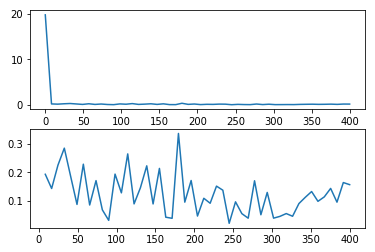

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints

# sample spacing
T = 1.0 / 800.0
x = X[1, :] 
up = np.percentile(x, 95)
down =np.percentile(x, 5)
x[x>up] = up
x[x<down] = down
N = x.shape[0]
x/=x.max()
y = 10 + np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), int(x.shape[0]/2))

plt.subplot(2, 1, 1)
plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.subplot(2, 1, 2)
plt.plot(xf[1:], 2.0/N * np.abs(yf[0:int(N/2)])[1:])

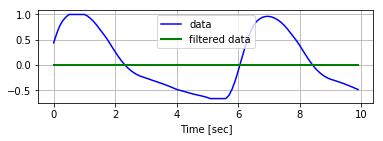

In [46]:
from scipy import signal
from scipy.signal import fir_filter_design as ffd
from scipy.signal import filter_design as ifd
from scipy.signal import lfilter, butter, freqz

Fs = 125
Fpass = 0.2
Fstop = 10
Wp = Fpass/Fs
Ws = Fstop/Fs
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 100
fs = 125       # sample rate, Hz
cutoff = 0.2  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=1000)
y = butter_lowpass_filter(x, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, x, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

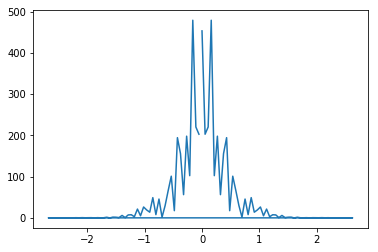

In [52]:
y = np.sin(2*np.pi*x)
f = np.fft.fft(y)
## sample frequencies
freq = np.fft.fftfreq(len(y), d=x[1]-x[0])
plt.plot(freq, abs(f)**2)